In [1]:
!pip install gspread oauth2client

In [2]:
!pip -q install gspread pandas gdown

In [3]:
!gdown --id 19eGg3FwT7B_IwJy2DPYhrvwDihKgSiNL -O colab-service-account.json

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19eGg3FwT7B_IwJy2DPYhrvwDihKgSiNL
To: /content/colab-service-account.json
100% 2.40k/2.40k [00:00<00:00, 9.55MB/s]


In [4]:
import json, pathlib
svc = json.loads(pathlib.Path('colab-service-account.json').read_text())
print("Service account email:", svc["client_email"])

Service account email: colab-service@sheetsaccessprojectintenrpro.iam.gserviceaccount.com


In [5]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

scope = [
  "https://spreadsheets.google.com/feeds",
  "https://www.googleapis.com/auth/spreadsheets",
  "https://www.googleapis.com/auth/drive"
]

creds = ServiceAccountCredentials.from_json_keyfile_name("colab-service-account.json", scope)
client = gspread.authorize(creds)

def read_sheet(spreadsheet_id, gid=None, sheet_name=None):
  """Baca sheet berdasarkan gid ATAU nama sheet."""
  sh = client.open_by_key(spreadsheet_id)
  if sheet_name:
    ws = sh.worksheet(sheet_name)
  elif gid is not None:
     ws = sh.get_worksheet_by_id(int(gid))
  else:
    ws = sh.sheet1

  data = ws.get_all_records()
  return pd.DataFrame(data)

spreadsheet_id = "18fJ2U96koMRctfbhybT1HsT2D95wgafLQMzlb-AwTvE"
gid = 0

# Baca data dari Google Sheet
df = read_sheet(spreadsheet_id, gid=gid)

In [6]:
df.head()

,Sumber Sheet,Tanggal Gabungan,Month,Product,Kategori,Hari,Bulan,Tahun,Batch,Umur,...,Channel,Mengapa memilih Dibimbing,Pernah/Tidak memiliki pengalaman di bidang yang diambil,Apakah memiliki skill bahasa inggris,Penyaluran Kerja,Blog dibimbing,Community,Pernah ikut acara dibimbing/tidak,Catatan,Pengembalian Kontrak
0,DS,2/Jan/2024,Jan 2024,Data Science,JCJC+,2,Jan,2024,26,33,...,Instagram,"Job Connector dan kualitas dari Dibimbing, ser...","Job Connector dan kualitas dari Dibimbing, ser...",,Tertarik,,-,Tidak,,-
1,DE,2/Jan/2024,Jan 2024,Data Engineering,CAJC,2,Jan,2024,4,24,...,Instagram,"Karena harga affordable, waktunya tidak mengga...","Karena harga affordable, waktunya tidak mengga...",,,Tidak,,Tidak,Pernah mengikuti Bootcamp di Altera Academy un...,
2,PMPM,2/Jan/2024,Jan 2024,Product Management,JCJC+,2,Jan,2024,9,27,...,Google Ads,Kurikulum di Dibimbing paling sesuai dan harga...,Kurikulum di Dibimbing paling sesuai dan harga...,,tertarik,Tidak,Tidak,Tidak,,
3,DM,2/Jan/2024,Jan 2024,Digital Marketing,JCJC+,2,Jan,2024,23,29,...,Instagram,"Dari sisi silabus materinya lengkap, harganya ...","Dari sisi silabus materinya lengkap, harganya ...",,Tertarik,Tidak,Tidak,Pernah (mentortalks tahun 2023),-,-
4,UIUX,3/Jan/2024,Jan 2024,UI/UX,JCJC+,3,Jan,2024,24,24,...,Refferal,di Linkedin dan di CV diperbarui sehingga dapa...,di Linkedin dan di CV diperbarui sehingga dapa...,,Tertarik,,Tidak,Tidak,Pernah mengikuti Intern di rakaming dan bekerj...,


# Proyek ini bertujuan untuk memahami pola peserta Dibimbing, membangun segmentasi peserta yang akurat, dan mengembangkan model prediktif peluang penyaluran kerja untuk mendukung keputusan bisnis berbasis data (misalnya strategi akuisisi, desain program, dan intervensi peserta).

In [7]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 34.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [8]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Data Understanding

In [9]:
df.head()

,Sumber Sheet,Tanggal Gabungan,Month,Product,Kategori,Hari,Bulan,Tahun,Batch,Umur,...,Channel,Mengapa memilih Dibimbing,Pernah/Tidak memiliki pengalaman di bidang yang diambil,Apakah memiliki skill bahasa inggris,Penyaluran Kerja,Blog dibimbing,Community,Pernah ikut acara dibimbing/tidak,Catatan,Pengembalian Kontrak
0,DS,2/Jan/2024,Jan 2024,Data Science,JCJC+,2,Jan,2024,26,33,...,Instagram,"Job Connector dan kualitas dari Dibimbing, ser...","Job Connector dan kualitas dari Dibimbing, ser...",,Tertarik,,-,Tidak,,-
1,DE,2/Jan/2024,Jan 2024,Data Engineering,CAJC,2,Jan,2024,4,24,...,Instagram,"Karena harga affordable, waktunya tidak mengga...","Karena harga affordable, waktunya tidak mengga...",,,Tidak,,Tidak,Pernah mengikuti Bootcamp di Altera Academy un...,
2,PMPM,2/Jan/2024,Jan 2024,Product Management,JCJC+,2,Jan,2024,9,27,...,Google Ads,Kurikulum di Dibimbing paling sesuai dan harga...,Kurikulum di Dibimbing paling sesuai dan harga...,,tertarik,Tidak,Tidak,Tidak,,
3,DM,2/Jan/2024,Jan 2024,Digital Marketing,JCJC+,2,Jan,2024,23,29,...,Instagram,"Dari sisi silabus materinya lengkap, harganya ...","Dari sisi silabus materinya lengkap, harganya ...",,Tertarik,Tidak,Tidak,Pernah (mentortalks tahun 2023),-,-
4,UIUX,3/Jan/2024,Jan 2024,UI/UX,JCJC+,3,Jan,2024,24,24,...,Refferal,di Linkedin dan di CV diperbarui sehingga dapa...,di Linkedin dan di CV diperbarui sehingga dapa...,,Tertarik,,Tidak,Tidak,Pernah mengikuti Intern di rakaming dan bekerj...,


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Hari,3071.0,15.834582,8.736981,1.0,8.0,16.0,23.0,31.0
Tahun,3071.0,2024.562683,0.496136,2024.0,2024.0,2025.0,2025.0,2025.0


In [11]:
df.shape

(3071, 40)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3071 entries, 0 to 3070
Data columns (total 40 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   Sumber Sheet                                             3071 non-null   object
 1   Tanggal Gabungan                                         3071 non-null   object
 2   Month                                                    3071 non-null   object
 3   Product                                                  3071 non-null   object
 4   Kategori                                                 3071 non-null   object
 5   Hari                                                     3071 non-null   int64 
 6   Bulan                                                    3071 non-null   object
 7   Tahun                                                    3071 non-null   int64 
 8   Batch                                 

# Data Cleaning & Preprocessing

In [13]:
df.duplicated().sum()

np.int64(1)

In [14]:
dupes = df[df.duplicated(keep=False)]

dupes

,Sumber Sheet,Tanggal Gabungan,Month,Product,Kategori,Hari,Bulan,Tahun,Batch,Umur,...,Channel,Mengapa memilih Dibimbing,Pernah/Tidak memiliki pengalaman di bidang yang diambil,Apakah memiliki skill bahasa inggris,Penyaluran Kerja,Blog dibimbing,Community,Pernah ikut acara dibimbing/tidak,Catatan,Pengembalian Kontrak
1733,HR,5/Mar/2025,Mar 2025,Human Resource,CAJC,5,Mar,2025,7,26,...,TikTok Ads,Jadwal di weekend dan materi sedikit lebih len...,Jadwal di weekend dan materi sedikit lebih len...,A1 Beginner (use simple phrases for basic need...,Tertarik,Tidak,Tidak,Tidak,Tiktok (tahu dibimbing dari tiktok dan mencari...,
1736,HR,5/Mar/2025,Mar 2025,Human Resource,CAJC,5,Mar,2025,7,26,...,TikTok Ads,Jadwal di weekend dan materi sedikit lebih len...,Jadwal di weekend dan materi sedikit lebih len...,A1 Beginner (use simple phrases for basic need...,Tertarik,Tidak,Tidak,Tidak,Tiktok (tahu dibimbing dari tiktok dan mencari...,


In [15]:
df_no_dupes = df.drop_duplicates(keep='first')

In [16]:
df_raw = df.copy()

similar_cols = []
cols = df_raw.columns.tolist()

for i in range(len(cols)):
  for j in range(i+1, len(cols)):
    c1, c2 = cols[i], cols[j]

    s1 = df_raw[c1].astype(str).str.strip().str.lower().replace("nan", "")
    s2 = df_raw[c2].astype(str).str.strip().str.lower().replace("nan", "")

    same_pct = (s1 == s2).mean() * 100

    if same_pct >= 85:
      similar_cols.append((c1, c2, round(same_pct, 2)))

similar_cols

[('Mengapa memilih Dibimbing',
  'Pernah/Tidak memiliki pengalaman di bidang yang diambil',
  np.float64(98.47))]

In [17]:
dup_pairs = [
  ("Mengapa memilih Dibimbing",
  "Pernah/Tidak memiliki pengalaman di bidang yang diambil")
]

cols_to_drop_dup = [p[1] for p in dup_pairs if p[1] in df.columns]
df = df.drop(columns=cols_to_drop_dup)

print("Drop karena duplikat:", cols_to_drop_dup)

Drop karena duplikat: ['Pernah/Tidak memiliki pengalaman di bidang yang diambil']


In [18]:
c1 = "Jurusan S2 (jika ada)"
c2 = "Pengembalian Kontrak"

s1 = df_raw[c1].astype(str).str.strip().str.lower().replace("nan", "")
s2 = df_raw[c2].astype(str).str.strip().str.lower().replace("nan", "")

same_pct_pair2 = (s1 == s2).mean() * 100
same_pct_pair2

np.float64(70.79127320091175)

| **Persentase Kesamaan** | **Kategori**       | **Penjelasan**                                                                                            | **Rekomendasi**                              |
| ----------------------- | ------------------ | --------------------------------------------------------------------------------------------------------- | -------------------------------------------- |
| **< 70%**               | Tidak Mirip        | Nilai dua kolom berbeda secara signifikan. Biasanya menunjukkan fungsi berbeda.                           | Tidak dianggap duplikat.                     |
| **70–85%**              | Mirip Sebagian     | Ada kemiripan, tetapi banyak nilai berbeda. Sering terjadi jika satu kolom hasil transformasi kolom lain. | Perlu cek manual, *bukan otomatis duplikat*. |
| **85–95%**              | Hampir Duplikat    | Struktur data sangat mirip; perbedaan minor biasanya karena formatting atau missing.                      | Bisa dipertimbangkan duplikat.               |
| **> 95%**               | **Duplikat Kolom** | Hampir seluruh nilai identik. Ini standar umum di literatur.                                              | Drop salah satu kolom.                       |


In [19]:
df.replace({
  "": np.nan,
  " ": np.nan,
  "-": np.nan,
  " - ": np.nan,
  "NA": np.nan,
  "N/A": np.nan,
  "n/a": np.nan,
  "None": np.nan,
  "none": np.nan,
  "Null": np.nan,
  "null": np.nan,
  "nan": np.nan
}, inplace=True)

/tmp/ipython-input-2178142681.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({


In [20]:
df.isnull().sum()

,0
Sumber Sheet,0
Tanggal Gabungan,0
Month,0
Product,1
Kategori,1
Hari,0
Bulan,0
Tahun,0
Batch,1
Umur,2


In [21]:
missing_percentage = df.isnull().sum()/df.shape[0]*100
missing_percentage.sort_values(ascending=False)

,0
Pengembalian Kontrak,100.000000
Jurusan S2 (jika ada),91.924455
Waktu terakhir bekerja (kalau lagi nggak kerja/intern),72.289157
Kegiatan yang dilakukan waktu luang/Hobi,50.732660
Blog dibimbing,45.913383
Apakah memiliki skill bahasa inggris,23.575383
Jurusan,18.723543
Community,18.658417
Jurusan pendidikan,18.137415
Alasan mengambil kategori Bootcamp,17.746662


In [22]:
cols_to_drop = missing_percentage[missing_percentage > 20].index
df_clean = df.drop(columns=cols_to_drop)

In [23]:
missing_percentage = df_clean.isnull().sum()/df_clean.shape[0]*100
missing_percentage.sort_values(ascending=False)

,0
Jurusan,18.723543
Community,18.658417
Jurusan pendidikan,18.137415
Alasan mengambil kategori Bootcamp,17.746662
Catatan,14.783458
Motivasi mengikuti bootcamp,6.903289
Penyaluran Kerja,5.503093
Kota(Jabodetabek),2.507327
Kota,2.507327
Asal Sekolah,1.139694


## Universal Missing Cleaner

In [24]:
df_clean = df_clean.replace({
  "": np.nan,
  " ": np.nan,
  "-": np.nan,
  " - ": np.nan,
  "N/A": np.nan,
  "NA": np.nan,
  "na": np.nan,
  "None": np.nan,
  "none": np.nan,
  "Null": np.nan,
  "null": np.nan,
  "nan": np.nan
})

df_clean = df_clean.replace(r'^\s*$', np.nan, regex=True)

## Konversi Kolom Numerik

In [25]:
# 1) Hari & Tahun → numerik biasa
numeric_cols = ["Hari", "Tahun"]

for col in numeric_cols:
  if col in df_clean.columns:
    df_clean[col] = (
      df_clean[col]
        .astype(str)
        .str.replace(r"[^0-9]", "", regex=True)  # hilangkan *, +, spasi, huruf dll
        .replace("", np.nan)
    )
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# 2) Umur → ambil angka pertama 1–2 digit (supaya 33.0 → 33, 25+ → 25, dst.)
if "Umur" in df_clean.columns:
  df_clean["Umur"] = (
    df_clean["Umur"]
      .astype(str)
      .str.extract(r"(\d{1,2})")[0]   # ambil grup angka pertama, max 2 digit
  )
  df_clean["Umur"] = pd.to_numeric(df_clean["Umur"], errors="coerce")

# 3) Pastikan Batch tetap teks (kategori mentah)
if "Batch" in df_clean.columns:
  df_clean["Batch"] = df_clean["Batch"].astype(str).str.strip()

## Konversi Tanggal

In [26]:
date_cols = [
  "Tanggal Gabungan"
]

for col in date_cols:
  if col in df_clean.columns:
    df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

## Konversi Category

In [27]:
categorical_cols = [
  "Sumber Sheet",
  "Month",
  "Product",
  "Kategori",
  "Bulan",
  "Batch",
  "Domisili",
  "Kota",
  "Kota(Jabodetabek)",
  "Provinsi",
  "Negara",
  "Background pendidikan",
  "Asal Sekolah",
  "Level pendidikan",
  "Jurusan pendidikan",
  "Jurusan",
  "Jurusan S2 (jika ada)",
  "Kesibukan sekarang apa",
  "Kategori Kesibukan",
  "Level Pekerjaan",
  "Kategori Pekerjaan",
  "Waktu terakhir bekerja (kalau lagi nggak kerja/intern)",
  "Kegiatan yang dilakukan waktu luang/Hobi",
  "Alasan mengambil kategori Bootcamp",
  "Blog dibimbing",
  "Community",
  "Dengar Dibimbing darimana",
  "Channel",
  "Mengapa memilih Dibimbing",
  "Penyaluran Kerja",
  "Pernah ikut acara dibimbing/tidak",
  "Catatan",
]

for col in categorical_cols:
  if col in df_clean.columns:
    df_clean[col] = df_clean[col].astype("category")

In [28]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3071 entries, 0 to 3070
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Sumber Sheet                        3071 non-null   category      
 1   Tanggal Gabungan                    1973 non-null   datetime64[ns]
 2   Month                               3071 non-null   category      
 3   Product                             3070 non-null   category      
 4   Kategori                            3070 non-null   category      
 5   Hari                                3071 non-null   int64         
 6   Bulan                               3071 non-null   category      
 7   Tahun                               3071 non-null   int64         
 8   Batch                               3071 non-null   category      
 9   Umur                                3068 non-null   float64       
 10  Domisili                

## Imputasi Missing Value

In [29]:
possible_num_cols = ["Hari", "Tahun", "Umur"]

for col in possible_num_cols:
  if col in df_clean.columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

In [30]:
for col in df_clean.columns:
  if df_clean[col].dtype == "object":
    df_clean[col] = df_clean[col].str.strip()

In [31]:
# Helper Imputasi
for col in df_clean.columns:
  if df_clean[col].dtype == "object":
    df_clean[col] = df_clean[col].replace("nan", np.nan)
    df_clean[col] = df_clean[col].replace(
      to_replace=r"^\s*nan\s*$",
      value=np.nan,
      regex=True
    )

In [32]:
# Bersihkan kolom Batch (hindari string 'nan')
if "Batch" in df_clean.columns:
  # Jadikan object dulu supaya bisa replace bebas
  df_clean["Batch"] = df_clean["Batch"].astype(str).str.strip()
  df_clean.loc[df_clean["Batch"].str.lower().isin(["nan", ""]), "Batch"] = np.nan
  # Kembalikan ke kategori
  df_clean["Batch"] = df_clean["Batch"].astype("category")

In [33]:
# Pastikan Batch bukan numerik lagi
num_cols  = df_clean.select_dtypes(include=['int64', 'float64']).columns
cat_cols  = df_clean.select_dtypes(include=['object', 'category']).columns
date_cols = df_clean.select_dtypes(include=['datetime64[ns]']).columns

print("Numerik   :", list(num_cols))
print("Kategori  :", list(cat_cols))
print("Datetime  :", list(date_cols))

Numerik   : ['Hari', 'Tahun', 'Umur']
Kategori  : ['Sumber Sheet', 'Month', 'Product', 'Kategori', 'Bulan', 'Batch', 'Domisili', 'Kota', 'Kota(Jabodetabek)', 'Provinsi', 'Negara', 'Background pendidikan', 'Asal Sekolah', 'Level pendidikan', 'Jurusan pendidikan', 'Jurusan', 'Kesibukan sekarang apa', 'Kategori Kesibukan', 'Level Pekerjaan', 'Kategori Pekerjaan', 'Alasan mengambil kategori Bootcamp', 'Motivasi mengikuti bootcamp', 'Dengar Dibimbing darimana', 'Channel', 'Mengapa memilih Dibimbing', 'Penyaluran Kerja', 'Community', 'Pernah ikut acara dibimbing/tidak', 'Catatan']
Datetime  : ['Tanggal Gabungan']


In [34]:
# Imputasi Numeric
for col in num_cols:
  df_clean[col] = df_clean[col].fillna(df_clean[col].median())

In [35]:
# Imputasi Categoric
for col in cat_cols:
  df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

In [36]:
# Imputasi Datetime
for col in date_cols:
  df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

In [37]:
for col in df_clean.columns:
  if df_clean[col].isna().any():
    if pd.api.types.is_numeric_dtype(df_clean[col]):
      df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    elif pd.api.types.is_datetime64_any_dtype(df_clean[col]):
      df_clean[col] = df_clean[col].fillna(df_clean[col].mode(dropna=True)[0])
    else:
      df_clean[col] = df_clean[col].fillna(df_clean[col].mode(dropna=True)[0])

# Cek Akhir
print("Total NaN di df_clean:", df_clean.isna().sum().sum())
df_clean.isnull().sum().sort_values(ascending=False)

Total NaN di df_clean: 0


,0
Sumber Sheet,0
Tanggal Gabungan,0
Month,0
Product,0
Kategori,0
Hari,0
Bulan,0
Tahun,0
Batch,0
Umur,0


In [38]:
# Dataframe Modelling
df_model = df_clean.copy()

# Kolom target Biner
df_model["Penyaluran_flag"] = (
  df_model["Penyaluran Kerja"]
    .astype(str)
    .str.lower()
    .str.contains("ya|sudah|tersalur|placed|berhasil")
).astype(int)

In [39]:
print("Cek string 'nan' yang tersisa:")
for col in df_clean.columns:
  n_str_nan = (df_clean[col].astype(str).str.lower() == "nan").sum()
  if n_str_nan > 0:
    print(col, n_str_nan)

Cek string 'nan' yang tersisa:


## Cek Outlier kolom Numeric

In [40]:
df = df_clean.copy()

numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
  outlier_count = len(outliers)
  outlier_percentage = (outlier_count / len(df)) * 100
  print(f"{col}: {outlier_count} outliers ({outlier_percentage:.2f}%)")

Hari: 0 outliers (0.00%)
Tahun: 0 outliers (0.00%)
Umur: 172 outliers (5.60%)


# Feature Engineering (Untuk EDA dan Modelling)

In [41]:
df_eda = df_clean.copy()

## Target biner

In [42]:
df_eda["Penyaluran_flag"] = (
  df_eda["Penyaluran Kerja"]
    .astype(str)
    .str.lower()
    .str.contains("ya|sudah|tersalur|placed|berhasil")
).astype(int)

## Bucket umur

In [43]:
umur_bins   = [0, 22, 25, 30, 100]
umur_labels = ["≤22", "23–25", "26–30", ">30"]

df_eda["Umur_bin"] = pd.cut(
  df_eda["Umur"],
  bins=umur_bins,
  labels=umur_labels,
  include_lowest=True,
  right=True
)

## Region

In [44]:
df_eda["Region"] = np.where(
  df_eda["Kota(Jabodetabek)"]
    .astype(str)
    .str.lower()
    .str.contains("jabodetabek"),
  "Jabodetabek",
  "Luar Jabodetabek"
)

## Fitur Batch

In [45]:
df_eda["Batch_str"] = df_eda["Batch"].astype(str)

In [46]:
# nomor batch
df_eda["Batch_num"] = (
  df_eda["Batch_str"]
    .str.extract(r"(\d+)", expand=False)
    .astype(float)
)

In [47]:
# kelas batch
df_eda["Batch_kelas"] = df_eda["Batch_str"].str.extract(r"([A-Za-z]+)", expand=False)

In [48]:
# flag batch job connector dari tanda '+'
df_eda["Batch_has_plus"] = df_eda["Batch_str"].str.contains(r"\+", regex=True).astype(int)

## Program Job Connector flag dari Kategori

In [49]:
df_eda["Program_jobconnect_flag"] = (
  df_eda["Kategori"]
    .astype(str)
    .str.contains(r"\+", regex=False)
).astype(int)

## Engagement

In [50]:
# Community_flag: 1 kalau join / aktif, 0 kalau jelas-jelas "tidak"
comm_series = df_eda["Community"].astype(str).str.lower()
df_eda["Community_flag"] = (~comm_series.str.contains("tidak", na=False)).astype(int)

In [51]:
# Event_flag: 1 kalau pernah ikut acara (kata kunci: 'pernah', 'sudah', 'ya')
evt_series = df_eda["Pernah ikut acara dibimbing/tidak"].astype(str).str.lower()
df_eda["Event_flag"] = evt_series.str.contains("pernah|sudah|ya", regex=True, na=False).astype(int)

In [52]:
# Level engagement gabungan
df_eda["Engagement_level"] = np.select(
  [
    (df_eda["Community_flag"] == 0) & (df_eda["Event_flag"] == 0),
    (df_eda["Community_flag"] == 1) & (df_eda["Event_flag"] == 0),
    (df_eda["Community_flag"] == 1) & (df_eda["Event_flag"] == 1),
    (df_eda["Community_flag"] == 0) & (df_eda["Event_flag"] == 1),
  ],
  ["Non-engaged", "Community only", "Community+Event", "Event only"],
  default="Non-engaged"
)

## Domain tambahan

In [53]:
def map_kategori_pekerjaan_fe(x: str) -> str:
  t = str(x).lower().strip()

  # Ibu rumah tangga dulu
  if any(k in t for k in ["ibu rumah tangga", "irt"]):
    return "Ibu Rumah Tangga"

  # Mahasiswa / pelajar
  if any(k in t for k in ["mahasiswa", "mahasiswi", "pelajar", "siswa", "student"]):
    return "Mahasiswa/Pelajar"

  # Job seeker / belum bekerja
  if any(k in t for k in [
    "job seeker", "jobseeker",
    "mencari kerja", "cari kerja",
    "belum bekerja", "tidak bekerja"
  ]):
    return "Job Seeker"

  # Freelance / part-time
  if any(k in t for k in ["freelance", "freelancer", "part time", "paruh waktu"]):
    return "Freelance/Part-time"

  # Wirausaha / usaha sendiri
  if any(k in t for k in [
    "wirausaha", "pengusaha", "entrepreneur", "enterpreuneur",
    "dagang", "pedagang", "bisnis sendiri", "usaha sendiri"
  ]):
    return "Wirausaha"

  # Tenaga pengajar
  if any(k in t for k in ["tenaga pengajar", "guru", "dosen", "pengajar"]):
    return "Tenaga Pengajar"

  # Tenaga kesehatan
  if any(k in t for k in [
    "tenaga kesehatan", "perawat", "dokter", "nakes", "bidan", "apoteker"
  ]):
    return "Tenaga Kesehatan"

  # Karyawan / pegawai
  if (
    "bekerja" in t or
    any(k in t for k in [
      "karyawan", "pegawai", "staff", "staf",
      "officer", "engineer", "developer", "analis", "analyst",
      "konsultan", "consultant", "manager", "manajer", "supervisor",
      "admin", "administrasi", "full time", "full-time", "contract",
      "kontrak", "intern", "magang"
    ]) or
    # indikasi nama perusahaan
    any(k in t for k in [" pt ", " cv ", " tbk", "ud ", "pd "])
  ):
    return "Karyawan"

  # fallback: bener-bener kategori aneh/kecil banget
  return "Lainnya"

df_eda["Kategori_Pekerjaan_FE"] = df_eda["Kategori Pekerjaan"].apply(map_kategori_pekerjaan_fe)
df_eda["Kategori_Pekerjaan_FE"] = df_eda["Kategori_Pekerjaan_FE"].astype("category")

In [54]:
# Level_Pekerjaan_FE
def map_level_pekerjaan_fe(x: str) -> str:
  t = str(x).lower().strip()

  # Case khusus
  if "handling jamaah" in t and "umroh" in t:
    return "Low"

  # High
  if t.startswith("high"):
    return "High"

  # Low
  if t.startswith("low"):
    return "Low"

  # Middle
  if t.startswith("middle") or t.startswith("mid "):
    return "Middle"

  # Job seeker
  if "job seeker" in t or "jobseeker" in t:
    return "Job Seeker"

  # Lainnya
  return x

# apply ke df_eda
df_eda["Level_Pekerjaan_FE"] = df_eda["Level Pekerjaan"].apply(map_level_pekerjaan_fe)
df_eda["Level_Pekerjaan_FE"] = df_eda["Level_Pekerjaan_FE"].astype("category")

# pastikan df_model ikut bawa kolom baru (kalau belum dieksekusi ulang)
df_model = df_eda.drop(columns=["Batch_kelas"])

In [55]:
def map_domain_pendidikan(x: str) -> str:
  t = str(x).lower()
  if any(k in t for k in [
    "informatika", "sistem informasi", "ilmu komputer",
    "statistik", "matematika", "data", "teknik elektro",
    "teknik komputer", "teknik industri"
  ]):
    return "IT/Data"
  if any(k in t for k in [
    "akuntansi", "manajemen", "bisnis", "ekonomi",
    "finance", "keuangan"
  ]):
    return "Bisnis/Manajemen"
  if any(k in t for k in [
    "komunikasi", "marketing", "periklanan",
    "public relation", "broadcast"
  ]):
    return "Marketing/Komunikasi"
  if any(k in t for k in [
    "desain", "dkv", "arsitektur", "seni rupa", "creative"
  ]):
    return "Design/Creative"
  return "Lainnya"

In [56]:
def map_domain_product(x: str) -> str:
  t = str(x).lower()
  if "data" in t or "machine learning" in t or "ai" in t:
    return "IT/Data"
  if "cyber" in t or "security" in t:
    return "IT/Data"
  if "ui" in t or "ux" in t or "product design" in t:
    return "Design/Creative"
  if "digital marketing" in t or "growth" in t or "seo" in t:
    return "Marketing/Komunikasi"
  if "product management" in t:
    return "Bisnis/Manajemen"
  return "Lainnya"

In [57]:
df_eda["Domain_pendidikan"] = df_eda["Jurusan pendidikan"].apply(map_domain_pendidikan)
df_eda["Domain_product"]    = df_eda["Product"].apply(map_domain_product)

df_eda["is_switcher"] = (df_eda["Domain_pendidikan"] != df_eda["Domain_product"]).astype(int)
df_eda["Segmen_karir"] = df_eda["is_switcher"].map({
  0: "Upskiller",
  1: "Career Switcher"
}).fillna("Unknown")

In [58]:
df_model = df_eda.drop(columns=["Batch_kelas"])

In [59]:
# Level pendidikan FE
def map_level_pendidikan(level):
  t = str(level).strip().lower()

  if t.startswith("low"):
    return "Low"
  elif t.startswith("middle"):
    return "Middle"
  elif t.startswith("high"):
    return "High"
  else:
    return "Other"

df_eda["Level_pendidikan_FE"] = df_eda["Level pendidikan"].apply(map_level_pendidikan)
df_eda["Level_pendidikan_FE"] = df_eda["Level_pendidikan_FE"].astype("category")
df_model = df_eda.drop(columns=["Batch_kelas"])

In [60]:
# Pastikan 3 kolom teks motivasi/alasan jadi string
text_cols = [
  "Motivasi mengikuti bootcamp",
  "Alasan mengambil kategori Bootcamp",
  "Mengapa memilih Dibimbing",
]

for c in text_cols:
  if c in df_eda.columns:
    df_eda[c] = df_eda[c].astype(str)
  else:
    print(f"Kolom '{c}' tidak ditemukan di df_eda")

# Gabungkan 3 kolom teks motivasi/alasan
df_eda["Motivasi_raw_all"] = (
    df_eda["Motivasi mengikuti bootcamp"] + " "
    + df_eda["Alasan mengambil kategori Bootcamp"] + " "
    + df_eda["Mengapa memilih Dibimbing"]
)


def map_motivasi_cluster(text: str) -> str:
  t = str(text).lower()
  t = t.replace("nan", " ").strip()

  if t == "":
    return "Tidak disebutkan"

  # Ganti karir / pindah bidang
  if any(k in t for k in [
    "ganti karir", "switch karir", "career switch",
    "pindah karir", "pindah bidang", "alih karir",
    "transition career"
  ]):
    return "Ganti karir"

  # Upgrade skill di kerja sekarang / upskill
  if any(k in t for k in [
    "upgrade skill", "upskill", "meningkatkan skill",
    "menambah skill", "memperdalam skill",
    "skill di pekerjaan", "untuk pekerjaan saya",
    "di tempat kerja", "support pekerjaan"
  ]):
    return "Upgrade skill di kerja"

  # Fresh graduate cari kerja pertama
  if any(k in t for k in [
    "fresh graduate", "freshgrad", "baru lulus",
    "baru wisuda", "belum punya pengalaman",
    "baru mulai karir"
  ]):
    return "Fresh graduate cari kerja"

  # Naik gaji / naik jenjang karir
  if any(k in t for k in [
    "naik gaji", "kenaikan gaji", "gaji lebih besar",
    "penghasilan", "income", "gaji tinggi", "gaji besar",
    "karir lebih baik", "jenjang karir", "promosi"
  ]):
    return "Naik gaji / karir"

  # Mau cepat kerja & ekspektasi tinggi soal hasil
  if any(k in t for k in [
    "cepat kerja", "cepat dapat kerja", "cepat dapet kerja",
    "langsung kerja", "langsung dapat kerja", "langsung dapet kerja",
    "pasti kerja", "jaminan kerja", "guarantee job"
  ]):
    return "Ingin cepat kerja & hasil tinggi"

  # Sertifikat / CV / portofolio
  if any(k in t for k in [
    "sertifikat", "certificate", "sertif",
    "cv", "curriculum vitae",
    "portofolio", "portfolio"
  ]):
    return "Sertifikat / CV / Portofolio"

  # Ikut tren / penasaran / coba-coba
  if any(k in t for k in [
    "trend", "tren", "lagi ramai", "lagi rame",
    "tiktok", "tik tok", "instagram", "ig",
    "viral", "fomo", "penasaran", "coba-coba", "cobain",
    "lihat dulu", "lihat-lihat"
  ]):
    return "Ikut tren / penasaran"

  # Disuruh / pengaruh orang lain
  if any(k in t for k in [
    "disuruh", "atas saran", "diminta",
    "orang tua", "ortu", "ayah", "ibu",
    "teman", "kawan", "sahabat",
    "pacar", "suami", "istri",
    "rekomendasi", "direkomendasikan"
  ]):
    return "Disuruh / ikut orang"

  # Default
  return "Lainnya"

In [61]:
# Kolom kategori motivasi untuk EDA & model
df_eda["Motivasi_cluster"] = df_eda["Motivasi_raw_all"].apply(map_motivasi_cluster)
df_eda["Motivasi_cluster"] = df_eda["Motivasi_cluster"].astype("category")

# Label teks untuk hasil penyaluran (enak buat dashboard / grafik)
df_eda["Penyaluran_label"] = df_eda["Penyaluran_flag"].map({
  0: "Belum tersalur",
  1: "Tersalur kerja",
}).fillna("Belum tersalur").astype("category")


def flag_misalignment(row):
  mot = row.get("Motivasi_cluster", "")
  eng = row.get("Engagement_level", "")
  is_switcher = row.get("is_switcher", 0)

  risk_score = 0

  # Motivasi dangkal / ikut-ikutan
  if mot in ["Ikut tren / penasaran", "Disuruh / ikut orang"]:
    risk_score += 1

  # Hanya kejar sertif / CV
  if mot == "Sertifikat / CV / Portofolio":
    risk_score += 1

  # Ekspektasi hasil tinggi & cepat kerja
  if mot == "Ingin cepat kerja & hasil tinggi":
    risk_score += 2

  # Career switcher biasanya butuh effort lebih
  if is_switcher == 1:
    risk_score += 1

  # Engagement
  if eng == "Non-engaged":
    risk_score += 2
  elif eng in ["Community only", "Event only"]:
    risk_score += 1

  # Mapping skor ke kategori risiko
  if risk_score >= 4:
    return "High Risk"
  elif risk_score >= 2:
    return "Medium Risk"
  else:
    return "Low Risk"

In [62]:
# Flag risiko motivasi
df_eda["Motivasi_risk_flag"] = df_eda.apply(flag_misalignment, axis=1)
df_eda["Motivasi_risk_flag"] = df_eda["Motivasi_risk_flag"].astype("category")
df_model = df_eda.drop(columns=["Batch_kelas"])

## Cek

In [63]:
# 1) List semua kolom FE yang sudah kita bikin sejauh ini
fe_cols = [
  # Target / turunan target
  "Penyaluran_flag",

  # FE demografi & lokasi
  "Umur_bin",
  "Region",

  # FE batch & job connector
  "Batch_str",
  "Batch_num",
  "Batch_has_plus",
  "Program_jobconnect_flag",

  # FE engagement
  "Community_flag",
  "Event_flag",
  "Engagement_level",

  # FE pekerjaan & level
  "Kategori_Pekerjaan_FE",
  "Level_Pekerjaan_FE",

  # FE domain pendidikan vs product
  "Domain_pendidikan",
  "Domain_product",
  "is_switcher",
  "Segmen_karir",

  # FE level pendidikan
  "Level_pendidikan_FE",

  # FE Motivasi
  "Motivasi_raw_all",
  "Motivasi_cluster",
  "Motivasi_risk_flag",
]

for c in fe_cols:
  in_eda   = c in df_eda.columns
  in_model = c in df_model.columns
  print(f"{c:25} | df_eda: {str(in_eda):5} | df_model: {str(in_model):5}")


# Filter hanya yang memang ada di df_eda untuk analisis lanjut
fe_cols_present_eda = [c for c in fe_cols if c in df_eda.columns]
fe_cols_present_model = [c for c in fe_cols if c in df_model.columns]

print("\nKolom FE yang ketemu di df_eda:", fe_cols_present_eda)
print("Kolom FE yang ketemu di df_model:", fe_cols_present_model)

Penyaluran_flag           | df_eda: True  | df_model: True 
Umur_bin                  | df_eda: True  | df_model: True 
Region                    | df_eda: True  | df_model: True 
Batch_str                 | df_eda: True  | df_model: True 
Batch_num                 | df_eda: True  | df_model: True 
Batch_has_plus            | df_eda: True  | df_model: True 
Program_jobconnect_flag   | df_eda: True  | df_model: True 
Community_flag            | df_eda: True  | df_model: True 
Event_flag                | df_eda: True  | df_model: True 
Engagement_level          | df_eda: True  | df_model: True 
Kategori_Pekerjaan_FE     | df_eda: True  | df_model: True 
Level_Pekerjaan_FE        | df_eda: True  | df_model: True 
Domain_pendidikan         | df_eda: True  | df_model: True 
Domain_product            | df_eda: True  | df_model: True 
is_switcher               | df_eda: True  | df_model: True 
Segmen_karir              | df_eda: True  | df_model: True 
Level_pendidikan_FE       | df_eda: True

In [64]:
# 2) Cek persentase missing di df_eda & df_model
if fe_cols_present_eda:
  print(">> df_eda:")
  missing_eda = (df_eda[fe_cols_present_eda].isna().mean() * 100).round(2)
  print(missing_eda.sort_values(ascending=False), "\n")

if fe_cols_present_model:
  print(">> df_model:")
  missing_model = (df_model[fe_cols_present_model].isna().mean() * 100).round(2)
  print(missing_model.sort_values(ascending=False), "\n")

>> df_eda:
Penyaluran_flag            0.0
Umur_bin                   0.0
Region                     0.0
Batch_str                  0.0
Batch_num                  0.0
Batch_has_plus             0.0
Program_jobconnect_flag    0.0
Community_flag             0.0
Event_flag                 0.0
Engagement_level           0.0
Kategori_Pekerjaan_FE      0.0
Level_Pekerjaan_FE         0.0
Domain_pendidikan          0.0
Domain_product             0.0
is_switcher                0.0
Segmen_karir               0.0
Level_pendidikan_FE        0.0
Motivasi_raw_all           0.0
Motivasi_cluster           0.0
Motivasi_risk_flag         0.0
dtype: float64 

>> df_model:
Penyaluran_flag            0.0
Umur_bin                   0.0
Region                     0.0
Batch_str                  0.0
Batch_num                  0.0
Batch_has_plus             0.0
Program_jobconnect_flag    0.0
Community_flag             0.0
Event_flag                 0.0
Engagement_level           0.0
Kategori_Pekerjaan_FE      0.

In [65]:
# 3) Ringkasan tiap kolom FE (tipe data, unik, distribusi)
for c in fe_cols_present_eda:
  s = df_eda[c]
  print(f"Kolom : {c}")
  print(f"Tipe : {s.dtype}")
  print(f"N : {len(s)}")
  print(f"Unique: {s.nunique()}")
  print(f"Missing (%): {s.isna().mean() * 100:.2f}")

  # Numerik pakai describe
  if pd.api.types.is_numeric_dtype(s):
    print("\nDescriptive stats (numeric):")
    print(s.describe())
  else:
    # Kategorik / object pakai top kategori
    print("\nTop 10 kategori (value_counts):")
    print(s.value_counts(dropna=False).head(10))
  print()  # spasi antar kolom

Kolom : Penyaluran_flag
Tipe : int64
N : 3071
Unique: 2
Missing (%): 0.00

Descriptive stats (numeric):
count    3071.000000
mean        0.002279
std         0.047696
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Penyaluran_flag, dtype: float64

Kolom : Umur_bin
Tipe : category
N : 3071
Unique: 4
Missing (%): 0.00

Top 10 kategori (value_counts):
Umur_bin
23–25    1143
26–30     889
≤22       689
>30       350
Name: count, dtype: int64

Kolom : Region
Tipe : object
N : 3071
Unique: 2
Missing (%): 0.00

Top 10 kategori (value_counts):
Region
Luar Jabodetabek    1605
Jabodetabek         1466
Name: count, dtype: int64

Kolom : Batch_str
Tipe : object
N : 3071
Unique: 91
Missing (%): 0.00

Top 10 kategori (value_counts):
Batch_str
1      291
2      161
3      123
7      115
4       97
6       94
5       86
8       81
12      76
27+     72
Name: count, dtype: int64

Kolom : Batch_num
Tipe : float64
N : 3071
Unique: 42
Missing 

In [66]:
# 4) Cek konsistensi nilai FE antara df_eda dan df_model
for c in fe_cols:
  if (c in df_eda.columns) and (c in df_model.columns):
    # Samakan index dulu supaya fair
    s1 = df_eda[c].reset_index(drop=True)
    s2 = df_model[c].reset_index(drop=True)

    same = s1.equals(s2)
    print(f"{c:25} | sama di df_eda & df_model? -> {same}")

Penyaluran_flag           | sama di df_eda & df_model? -> True
Umur_bin                  | sama di df_eda & df_model? -> True
Region                    | sama di df_eda & df_model? -> True
Batch_str                 | sama di df_eda & df_model? -> True
Batch_num                 | sama di df_eda & df_model? -> True
Batch_has_plus            | sama di df_eda & df_model? -> True
Program_jobconnect_flag   | sama di df_eda & df_model? -> True
Community_flag            | sama di df_eda & df_model? -> True
Event_flag                | sama di df_eda & df_model? -> True
Engagement_level          | sama di df_eda & df_model? -> True
Kategori_Pekerjaan_FE     | sama di df_eda & df_model? -> True
Level_Pekerjaan_FE        | sama di df_eda & df_model? -> True
Domain_pendidikan         | sama di df_eda & df_model? -> True
Domain_product            | sama di df_eda & df_model? -> True
is_switcher               | sama di df_eda & df_model? -> True
Segmen_karir              | sama di df_eda & df_model? 

# Export Artefact

## Cek

In [67]:
fe_cols_expected = [
  # Target / turunan target
  "Penyaluran_flag",
  "Penyaluran_label",

  # FE demografi & lokasi
  "Umur_bin",
  "Region",

  # FE batch & job connector
  "Batch_str",
  "Batch_num",
  "Batch_has_plus",
  "Program_jobconnect_flag",

  # FE engagement
  "Community_flag",
  "Event_flag",
  "Engagement_level",

  # FE pekerjaan & level
  "Kategori_Pekerjaan_FE",
  "Level_Pekerjaan_FE",

  # FE domain pendidikan vs product
  "Domain_pendidikan",
  "Domain_product",
  "is_switcher",
  "Segmen_karir",

  # FE level pendidikan
  "Level_pendidikan_FE",

  # FE motivasi
  "Motivasi_raw_all",
  "Motivasi_cluster",
  "Motivasi_risk_flag",
]

print("Total kolom FE yang diharapkan:", len(fe_cols_expected))

missing_fe = [c for c in fe_cols_expected if c not in df_eda.columns]
present_fe = [c for c in fe_cols_expected if c in df_eda.columns]

print("\nKolom FE yang SUDAH ada di df_eda:")
for c in present_fe:
  print("  -", c)

if missing_fe:
  print("\n>> Ada kolom FE yang ada di df_eda:")
  for c in missing_fe:
    print("  ✗", c)
else:
  print("\nSemua kolom FE yang diharapkan sudah ada di df_eda")

Total kolom FE yang diharapkan: 21

Kolom FE yang SUDAH ada di df_eda:
  - Penyaluran_flag
  - Penyaluran_label
  - Umur_bin
  - Region
  - Batch_str
  - Batch_num
  - Batch_has_plus
  - Program_jobconnect_flag
  - Community_flag
  - Event_flag
  - Engagement_level
  - Kategori_Pekerjaan_FE
  - Level_Pekerjaan_FE
  - Domain_pendidikan
  - Domain_product
  - is_switcher
  - Segmen_karir
  - Level_pendidikan_FE
  - Motivasi_raw_all
  - Motivasi_cluster
  - Motivasi_risk_flag

Semua kolom FE yang diharapkan sudah ada di df_eda


In [68]:
base_cols = list(df_clean.columns)

# FE yang dari atas
expected_cols_all = sorted(set(base_cols).union(fe_cols_expected))

missing_in_df_eda = [c for c in expected_cols_all if c not in df_eda.columns]
extra_in_df_eda   = [c for c in df_eda.columns if c not in expected_cols_all]

print("Total kolom base (df_clean):", len(base_cols))
print("Total kolom expected (base + FE):", len(expected_cols_all))
print("Total kolom di df_eda:", len(df_eda.columns))

if missing_in_df_eda:
  print("\n Kolom yang tidak ada di df_eda:")
  for c in missing_in_df_eda:
    print("  ✗", c)
else:
  print("\nTidak ada kolom expected yang hilang dari df_eda")

if extra_in_df_eda:
  print("\n Kolom yang ada di df_eda tapi tidak termasuk daftar expected (mungkin FE tambahan / helper):")
  for c in extra_in_df_eda:
    print("  -", c)

Total kolom base (df_clean): 33
Total kolom expected (base + FE): 54
Total kolom di df_eda: 55

Tidak ada kolom expected yang hilang dari df_eda

 Kolom yang ada di df_eda tapi tidak termasuk daftar expected (mungkin FE tambahan / helper):
  - Batch_kelas


In [69]:
missing_per_col = df_eda.isna().sum()
total_missing   = int(missing_per_col.sum())

print("\n Check missing values df_eda")
print("Total sel yang masih NaN :", total_missing)

if total_missing == 0:
  print("Tidak ada missing values di df_eda")
else:
  print("Masih ada missing values. Top 10 kolom dengan missing:")
  display(missing_per_col[missing_per_col > 0].sort_values(ascending=False).head(10))

# Cek duplikat baris
dup_count = df_eda.duplicated().sum()

print("\n Check duplikat baris df_eda")
print("Jumlah baris duplikat (exact duplicates):", dup_count)

if dup_count == 0:
  print("Tidak ada duplikat baris di df_eda")
else:
  print(f"Ada {dup_count} baris duplikat di df_eda.")
  display(df_eda[df_eda.duplicated(keep=False)].head())


 Check missing values df_eda
Total sel yang masih NaN : 3000
Masih ada missing values. Top 10 kolom dengan missing:


,0
Batch_kelas,3000



 Check duplikat baris df_eda
Jumlah baris duplikat (exact duplicates): 23
Ada 23 baris duplikat di df_eda.


,Sumber Sheet,Tanggal Gabungan,Month,Product,Kategori,Hari,Bulan,Tahun,Batch,Umur,...,Level_Pekerjaan_FE,Domain_pendidikan,Domain_product,is_switcher,Segmen_karir,Level_pendidikan_FE,Motivasi_raw_all,Motivasi_cluster,Penyaluran_label,Motivasi_risk_flag
1733,HR,2025-03-05,Mar 2025,Human Resource,CAJC,5,Mar,2025,7,26.0,...,Middle,Bisnis/Manajemen,Lainnya,1,Career Switcher,Middle,Motivasi mengikuti bootcamp ini adalah agar bi...,Lainnya,Belum tersalur,Medium Risk
1736,HR,2025-03-05,Mar 2025,Human Resource,CAJC,5,Mar,2025,7,26.0,...,Middle,Bisnis/Manajemen,Lainnya,1,Career Switcher,Middle,Motivasi mengikuti bootcamp ini adalah agar bi...,Lainnya,Belum tersalur,Medium Risk
2020,DS,2025-06-26,Mei 2025,Data Science,JCJC+,8,Mei,2025,35+,28.0,...,Low,Bisnis/Manajemen,IT/Data,1,Career Switcher,Middle,Tujuannya untuk cari kerja dan yang linier den...,Lainnya,Belum tersalur,Medium Risk
2022,DS,2025-06-26,Mei 2025,Data Science,JCJC+,8,Mei,2025,35+,28.0,...,Low,Bisnis/Manajemen,IT/Data,1,Career Switcher,Middle,Tujuannya untuk cari kerja dan yang linier den...,Lainnya,Belum tersalur,Medium Risk
2276,DS,2025-06-25,Jun 2025,Data Science,JCJC+,25,Jun,2025,39,31.0,...,Middle,Bisnis/Manajemen,IT/Data,1,Career Switcher,Middle,Awalnya melihat KOL yang tinggal di Jepang ker...,Upgrade skill di kerja,Belum tersalur,Medium Risk


In [70]:
# Hapus Batch_kelas dari df_eda
if "Batch_kelas" in df_eda.columns:
  df_eda = df_eda.drop(columns=["Batch_kelas"])

print("Apakah Batch_kelas masih ada di df_eda?", "Batch_kelas" in df_eda.columns)

Apakah Batch_kelas masih ada di df_eda? False


In [71]:
# Buat versi final untuk EDA / Tableau
df_eda_final = df_eda.copy()

# Drop exact duplicate rows (semua kolom sama persis)
n_before = len(df_eda_final)
df_eda_final = df_eda_final.drop_duplicates(keep="first").reset_index(drop=True)
n_after = len(df_eda_final)

print(f"Baris sebelum drop duplikat : {n_before}")
print(f"Baris sesudah drop duplikat  : {n_after}")
print(f"Baris duplikat yang dihapus  : {n_before - n_after}")

Baris sebelum drop duplikat : 3071
Baris sesudah drop duplikat  : 3048
Baris duplikat yang dihapus  : 23


In [72]:
# CHECK MISSING
missing_per_col = df_eda_final.isna().sum()
total_missing   = int(missing_per_col.sum())

print("\n CHECK MISSING VALUES df_eda_final")
print("Total sel yang masih NaN :", total_missing)
if total_missing == 0:
  print("Tidak ada missing values di df_eda_final")
else:
  display(missing_per_col[missing_per_col > 0].sort_values(ascending=False).head(10))

# CHECK DUPLICATE ROWS
dup_count = df_eda_final.duplicated().sum()
print("\n CHECK DUPLIKAT BARIS df_eda_final")
print("Jumlah baris duplikat (exact duplicates):", dup_count)


 CHECK MISSING VALUES df_eda_final
Total sel yang masih NaN : 0
Tidak ada missing values di df_eda_final

 CHECK DUPLIKAT BARIS df_eda_final
Jumlah baris duplikat (exact duplicates): 0


In [73]:
schema_summary = []

for col in df_eda.columns:
  s = df_eda[col]
  schema_summary.append({
    "column": col,
    "dtype": str(s.dtype),
    "n_unique": int(s.nunique()),
    "missing_cnt": int(s.isna().sum()),
    "missing_pct": float(s.isna().mean() * 100),
  })

schema_df = pd.DataFrame(schema_summary).sort_values("column").reset_index(drop=True)

print("\n SCHEMA SUMMARY df_eda")
display(schema_df)


 SCHEMA SUMMARY df_eda


,column,dtype,n_unique,missing_cnt,missing_pct
0,Alasan mengambil kategori Bootcamp,object,2425,0,0.0
1,Asal Sekolah,category,509,0,0.0
2,Background pendidikan,category,1331,0,0.0
3,Batch,category,91,0,0.0
4,Batch_has_plus,int64,2,0,0.0
5,Batch_num,float64,42,0,0.0
6,Batch_str,object,91,0,0.0
7,Bulan,category,13,0,0.0
8,Catatan,category,2265,0,0.0
9,Channel,category,13,0,0.0


In [74]:
df_std = df_eda.copy()

# Kolom yang memang mau dibuang
cols_to_drop = []
if "Batch_kelas" in df_std.columns:
  cols_to_drop.append("Batch_kelas")

df_std = df_std.drop(columns=cols_to_drop)
print("Drop kolom dari df_std:", cols_to_drop)

# Hapus baris duplikat (exact duplicate di semua kolom)
n_before = len(df_std)
df_std = df_std.drop_duplicates(keep="first").reset_index(drop=True)
n_after = len(df_std)

print(f"Baris sebelum drop duplikat : {n_before}")
print(f"Baris sesudah drop duplikat  : {n_after}")
print(f"Baris duplikat yang dihapus  : {n_before - n_after}")

Drop kolom dari df_std: []
Baris sebelum drop duplikat : 3071
Baris sesudah drop duplikat  : 3048
Baris duplikat yang dihapus  : 23


In [75]:
# Missing
missing_per_col = df_std.isna().sum()
total_missing   = int(missing_per_col.sum())

print("Total sel yang masih NaN :", total_missing)
if total_missing == 0:
  print("Tidak ada missing values di df_std")
else:
  print("WARNING – Masih ada missing values. Top 10 kolom dengan missing:")
  display(missing_per_col[missing_per_col > 0].sort_values(ascending=False).head(10))

# Duplikat
dup_count = df_std.duplicated().sum()
print("Jumlah baris duplikat (exact duplicates):", dup_count)

Total sel yang masih NaN : 0
Tidak ada missing values di df_std
Jumlah baris duplikat (exact duplicates): 0


# EDA (Exploratory Data Analysis)

## Q1: Driver Penyaluran Kerja

In [76]:
# Copy dataframe untuk EDA Q1
df_q1 = df_std.copy()

print("Q1 Data Shape:", df_q1.shape)
print("Penyaluran Flag Distribution:")
print(df_q1["Penyaluran_flag"].value_counts(normalize=True) * 100)

Q1 Data Shape: (3048, 54)
Penyaluran Flag Distribution:
Penyaluran_flag
0    99.770341
1     0.229659
Name: proportion, dtype: float64


### Placement Rate per Product Domain (Domain_product)

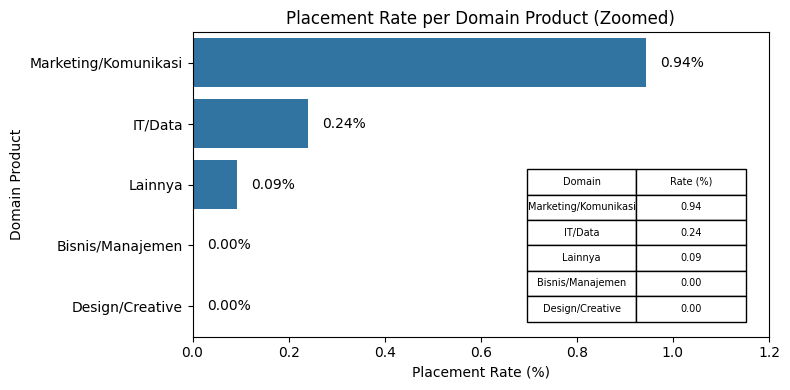

In [77]:
# Placement rate per domain product
placement_domain = (
  df_q1.groupby("Domain_product")["Penyaluran_flag"]
    .mean()
    .mul(100)
    .sort_values(ascending=False)
)

# Biar gampang dibaca sebagai tabel juga
table_df = placement_domain.reset_index()
table_df.columns = ["Domain", "Rate (%)"]
fig, ax = plt.subplots(figsize=(8,4))

# Barplot
sns.barplot(
  x=placement_domain.values,
  y=placement_domain.index,
  orient="h",
  ax=ax
)

ax.set_title("Placement Rate per Domain Product (Zoomed)")
ax.set_xlabel("Placement Rate (%)")
ax.set_ylabel("Domain Product")

# Zoom 0–1.2% supaya kelihatan
ax.set_xlim(0, 1.2)

# tulis angka di ujung bar
for i, v in enumerate(placement_domain.values):
  ax.text(v + 0.03, i, f"{v:.2f}%", va="center")

# Legend
tbl = ax.table(
  cellText=[[d, f"{r:.2f}"] for d, r in zip(table_df["Domain"], table_df["Rate (%)"])],
  colLabels=["Domain", "Rate (%)"],
  cellLoc="center",
  loc="center",
  bbox=[0.58, 0.05, 0.38, 0.5]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(7)
plt.tight_layout()
plt.show()

 ### Placement Rate per Segmen Karir (Career Switcher vs Upskiller)

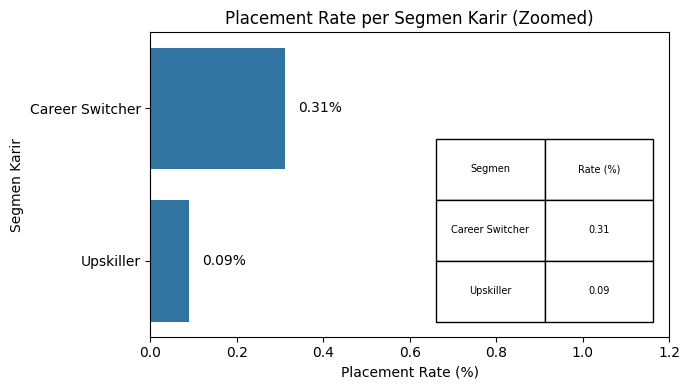

In [78]:
# Placement rate per Segmen Karir (dalam %)
placement_segmen = (
  df_q1.groupby("Segmen_karir")["Penyaluran_flag"]
    .mean()
    .mul(100)
    .sort_values(ascending=False)
)

# Biar enak dipakai buat tabel
seg_table = placement_segmen.reset_index()
seg_table.columns = ["Segmen karir", "Rate (%)"]
fig, ax = plt.subplots(figsize=(7,4))

# Barplot
sns.barplot(
  x=placement_segmen.values,
  y=placement_segmen.index,
  orient="h",
  ax=ax
)

ax.set_title("Placement Rate per Segmen Karir (Zoomed)")
ax.set_xlabel("Placement Rate (%)")
ax.set_ylabel("Segmen Karir")

# Zoom skala
ax.set_xlim(0, 1.2)

# Tulis angkanya di ujung bar
for i, v in enumerate(placement_segmen.values):
  ax.text(v + 0.03, i, f"{v:.2f}%", va="center")

# Legend
tbl = ax.table(
  cellText=[[d, f"{r:.2f}"] for d, r in zip(seg_table["Segmen karir"], seg_table["Rate (%)"])],
  colLabels=["Segmen", "Rate (%)"],
  cellLoc="center",
  bbox=[0.55, 0.05, 0.42, 0.6]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(7)
plt.tight_layout()
plt.show()

### Placement Rate per Umur

/tmp/ipython-input-2643234752.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_q1.groupby("Umur_bin")["Penyaluran_flag"]


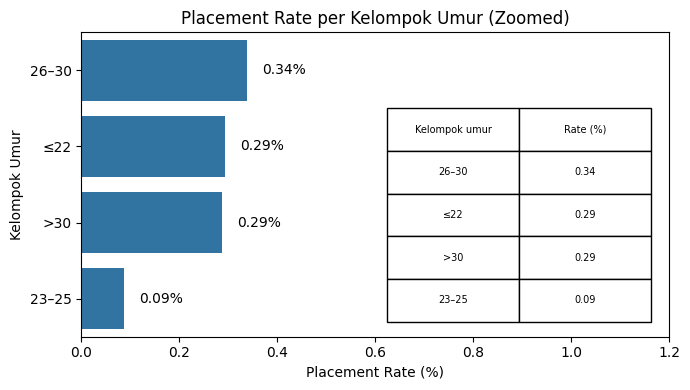

In [79]:
# Placement rate per kelompok umur (dalam %)
placement_umur = (
  df_q1.groupby("Umur_bin")["Penyaluran_flag"]
    .mean()
    .mul(100)
    .sort_values(ascending=False)
)

# Biar enak dipakai buat tabel
umur_table = placement_umur.reset_index()
umur_table.columns = ["Kelompok umur", "Rate (%)"]
fig, ax = plt.subplots(figsize=(7,4))

# Barplot
sns.barplot(
  x=placement_umur.values,
  y=placement_umur.index.astype(str),
  orient="h",
  ax=ax
)

ax.set_title("Placement Rate per Kelompok Umur (Zoomed)")
ax.set_xlabel("Placement Rate (%)")
ax.set_ylabel("Kelompok Umur")

# Zoom skala biar kebaca (0–1% an)
ax.set_xlim(0, 1.2)

# Tulis angkanya di ujung bar
for i, v in enumerate(placement_umur.values):
  ax.text(v + 0.03, i, f"{v:.2f}%", va="center")

# Tabel
tbl = ax.table(
  cellText=[[u, f"{r:.2f}"] for u, r in zip(umur_table["Kelompok umur"], umur_table["Rate (%)"])],
  colLabels=["Kelompok umur", "Rate (%)"],
  cellLoc="center",
  bbox=[0.52, 0.05, 0.45, 0.7]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(7)
plt.tight_layout()
plt.show()

### Placement Rate per Region (Jabodetabek vs luar)

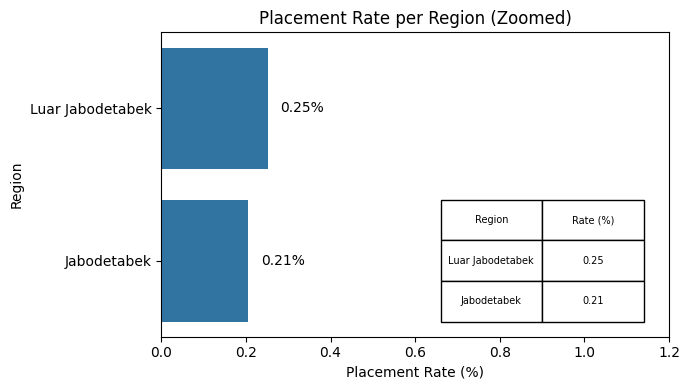

In [80]:
# Placement rate per region (dalam %)
placement_region = (
  df_q1.groupby("Region")["Penyaluran_flag"]
    .mean()
    .mul(100)
    .sort_values(ascending=False)
)

# buat tabelnya
region_table = placement_region.reset_index()
region_table.columns = ["Region", "Rate (%)"]
fig, ax = plt.subplots(figsize=(7,4))

# Barplot
sns.barplot(
  x=placement_region.values,
  y=placement_region.index.astype(str),
  orient="h",
  ax=ax
)

ax.set_title("Placement Rate per Region (Zoomed)")
ax.set_xlabel("Placement Rate (%)")
ax.set_ylabel("Region")

# zoom supaya keliatan
ax.set_xlim(0, 1.2)

# tulis angka % di ujung bar
for i, v in enumerate(placement_region.values):
  ax.text(v + 0.03, i, f"{v:.2f}%", va="center")

# Legend
tbl = ax.table(
  cellText=[[r, f"{v:.2f}"] for r, v in zip(region_table["Region"], region_table["Rate (%)"])],
  colLabels=["Region", "Rate (%)"],
  cellLoc="center",
  bbox=[0.55, 0.05, 0.40, 0.40]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(7)
plt.tight_layout()
plt.show()

### Placement Rate per Program Job Connector Flag

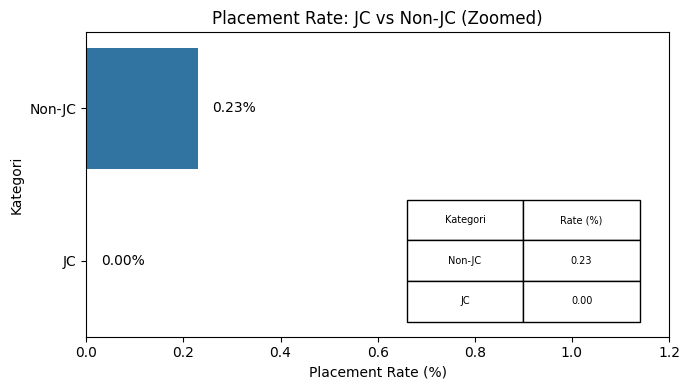

In [81]:
# Placement rate JC vs Non-JC (dalam %)
placement_jc = (
  df_q1.groupby("Program_jobconnect_flag")["Penyaluran_flag"]
    .mean()
    .mul(100)
    .reindex([0, 1])
    .fillna(0.0)
)

# ganti index ke label teks
placement_jc.index = ["Non-JC", "JC"]

# buat tabelnya
jc_table = placement_jc.reset_index()
jc_table.columns = ["Kategori", "Rate (%)"]
fig, ax = plt.subplots(figsize=(7, 4))

# Barplot
sns.barplot(
  x=placement_jc.values,
  y=placement_jc.index.astype(str),
  orient="h",
  ax=ax
)

ax.set_title("Placement Rate: JC vs Non-JC (Zoomed)")
ax.set_xlabel("Placement Rate (%)")
ax.set_ylabel("Kategori")

# zoom supaya keliatan (angka < 1%)
ax.set_xlim(0, 1.2)

# tulis angka % di ujung bar
for i, v in enumerate(placement_jc.values):
  ax.text(v + 0.03, i, f"{v:.2f}%", va="center")

# tabel kecil di dalam kotak grafik
tbl = ax.table(
  cellText=[[r, f"{v:.2f}"] for r, v in zip(jc_table["Kategori"], jc_table["Rate (%)"])],
  colLabels=["Kategori", "Rate (%)"],
  cellLoc="center",
  bbox=[0.55, 0.05, 0.40, 0.40]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(7)
plt.tight_layout()
plt.show()

### Placement Rate by Engagement Level

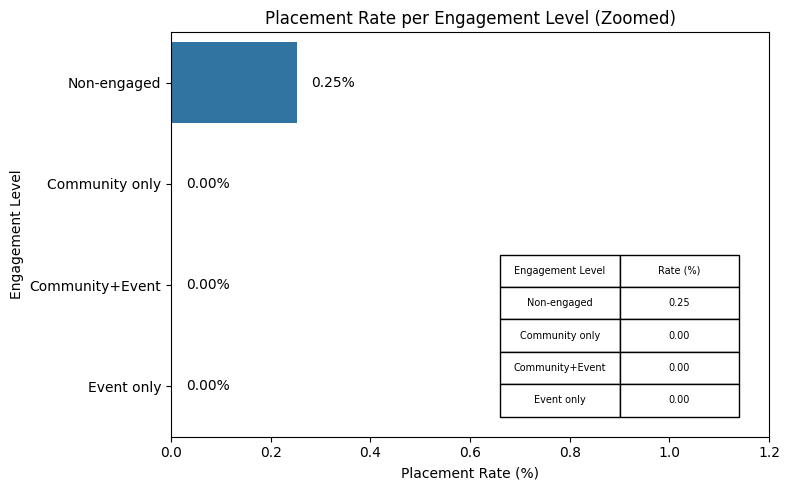

In [82]:
# Placement rate per Engagement Level (dalam %)
placement_eng = (
  df_q1.groupby("Engagement_level")["Penyaluran_flag"]
    .mean()
    .mul(100)
    .sort_values(ascending=False)
)

# tabel ringkas
eng_table = placement_eng.reset_index()
eng_table.columns = ["Engagement Level", "Rate (%)"]

fig, ax = plt.subplots(figsize=(8, 5))

# barplot horizontal
sns.barplot(
  x=placement_eng.values,
  y=placement_eng.index.astype(str),
  orient="h",
  ax=ax
)

ax.set_title("Placement Rate per Engagement Level (Zoomed)")
ax.set_xlabel("Placement Rate (%)")
ax.set_ylabel("Engagement Level")

# zoom biar kebaca (karena angkanya < 1%)
ax.set_xlim(0, 1.2)

# tulis angka % di ujung bar
for i, v in enumerate(placement_eng.values):
  ax.text(v + 0.03, i, f"{v:.2f}%", va="center")

# tabel kecil di dalam area grafik (kanan bawah)
tbl = ax.table(
  cellText=[[r, f"{v:.2f}"] for r, v in zip(eng_table["Engagement Level"], eng_table["Rate (%)"])],
  colLabels=["Engagement Level", "Rate (%)"],
  cellLoc="center",
  bbox=[0.55, 0.05, 0.40, 0.40]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(7)
plt.tight_layout()
plt.show()

### Placement Rate per Batch_num (numeric)

In [83]:
# Copy dataframe
df_batchgroup = df_q1[df_q1["Batch_num"].notna()].copy()

# Buat kelompok batch
df_batchgroup["Batch_group"] = pd.cut(
  df_batchgroup["Batch_num"],
  bins=[0, 10, 20, 30, 40, 100],
  labels=["1–10", "11–20", "21–30", "31–40", "41+"],
  right=True
)

In [84]:
# Hapus kategori 41+ kalau tidak ada datanya
df_batchgroup = df_batchgroup[df_batchgroup["Batch_group"].notna()]

# Hitung placement per kelompok
placement_group = (
  df_batchgroup.groupby("Batch_group")["Penyaluran_flag"]
    .mean()
    .mul(100)
    .sort_index()
)

/tmp/ipython-input-397231273.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_batchgroup.groupby("Batch_group")["Penyaluran_flag"]


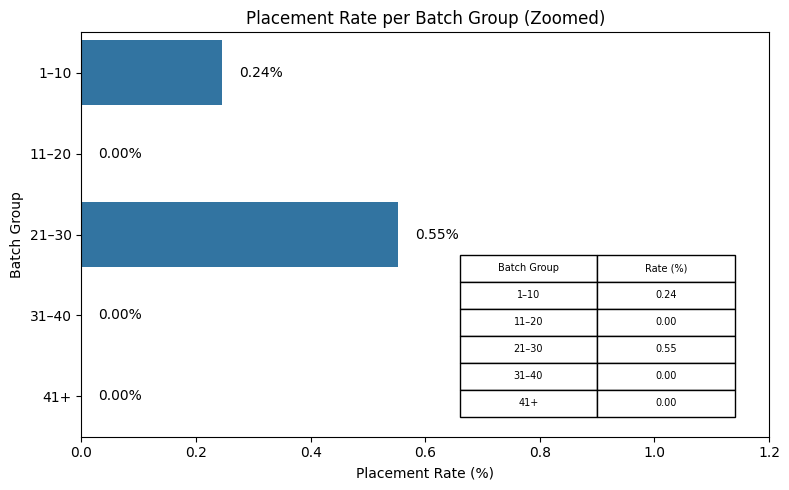

In [85]:
# Siapkan tabel
batch_table = placement_group.reset_index()
batch_table.columns = ["Batch Group", "Rate (%)"]
fig, ax = plt.subplots(figsize=(8, 5))

# Barplot horizontal
sns.barplot(
  x=placement_group.values,
  y=placement_group.index.astype(str),
  orient="h",
  ax=ax
)

ax.set_title("Placement Rate per Batch Group (Zoomed)")
ax.set_xlabel("Placement Rate (%)")
ax.set_ylabel("Batch Group")

# Zoom karena angkanya kecil
ax.set_xlim(0, 1.2)

# Label angka % di ujung bar
for i, v in enumerate(placement_group.values):
  ax.text(v + 0.03, i, f"{v:.2f}%", va="center")

# Tabel dalam grafik
tbl = ax.table(
  cellText=[[r, f"{v:.2f}"] for r, v in zip(batch_table["Batch Group"], batch_table["Rate (%)"])],
  colLabels=["Batch Group", "Rate (%)"],
  cellLoc="center",
  bbox=[0.55, 0.05, 0.40, 0.40]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(7)
plt.tight_layout()
plt.show()

### Heatmap Driver Kombinasi (Umur_bin × Segmen_karir)

/tmp/ipython-input-2011001873.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_q1.pivot_table(


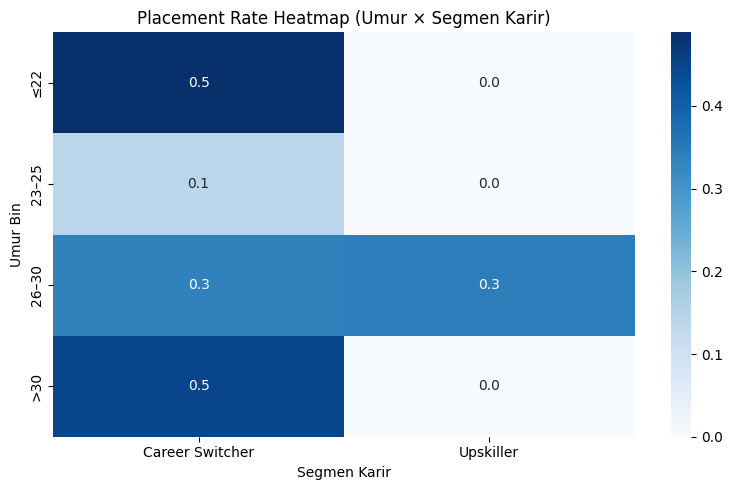

In [86]:
pivot_driver = (
  df_q1.pivot_table(
    index="Umur_bin",
    columns="Segmen_karir",
    values="Penyaluran_flag",
    aggfunc="mean"
  ) * 100
)

plt.figure(figsize=(8,5))
sns.heatmap(pivot_driver, annot=True, fmt=".1f", cmap="Blues")
plt.title("Placement Rate Heatmap (Umur × Segmen Karir)")
plt.ylabel("Umur Bin")
plt.xlabel("Segmen Karir")
plt.tight_layout()
plt.show()

## Q2: Persona peserta (switch vs upskill)

In [87]:
df_q2 = df_std.copy()

# Safety check
for col in ["Segmen_karir", "is_switcher", "Umur_bin", "Region"]:
  print(col, ":", col in df_q2.columns)

# Biar jelas tipenya
df_q2["Segmen_karir"] = df_q2["Segmen_karir"].astype("category")
df_q2["is_switcher"] = df_q2["is_switcher"].astype(int)

print("\nDistribusi segmen karir (%):")
print(df_q2["Segmen_karir"].value_counts(normalize=True) * 100)

Segmen_karir : True
is_switcher : True
Umur_bin : True
Region : True

Distribusi segmen karir (%):
Segmen_karir
Career Switcher    63.287402
Upskiller          36.712598
Name: proportion, dtype: float64


In [88]:
# Helper
def summarize_categorical_by_segment(df, seg_col, feat_col, top_n=10):
  # cek kolom
  if seg_col not in df.columns:
    raise KeyError(f"Kolom segmen '{seg_col}' tidak ada di df.")
  if feat_col not in df.columns:
    raise KeyError(f"Kolom fitur '{feat_col}' tidak ada di df.")

  # crosstab persen
  ct = pd.crosstab(df[feat_col], df[seg_col], normalize="columns") * 100
  top = df[feat_col].value_counts().head(top_n).index
  ct = ct.loc[top]

  # long format untuk barplot
  long_df = (
    ct.reset_index()
      .melt(id_vars=feat_col, var_name=seg_col, value_name="percent")
  )

  fig, ax = plt.subplots(figsize=(12, 4.8))

  # Bar
  sns.barplot(
    data=long_df,
      x="percent",
      y=feat_col,
      hue=seg_col,
      ax=ax
  )

  # X axis
  ax.set_xlim(0, 100)
  ax.set_xticks(np.arange(0, 101, 20))
  ax.set_xticklabels([f"{t:.0f}" for t in np.arange(0, 101, 20)])
  ax.set_xlabel("Percentage (%)")
  ax.set_title(f"{feat_col} per {seg_col} (Top {top_n})")

  # Label
  label_zone_max = 60

  for p in ax.patches:
    width = p.get_width()
    if width <= 0.01:
      continue

    y = p.get_y() + p.get_height() / 2

    # posisi natural di luar bar
    x_raw = width + 1.0
    # clamp supaya tidak lewat 60
    x_text = min(x_raw, label_zone_max - 1.0)

    ax.text(
      x_text,
      y,
      f"{width:.2f}%",
      va="center",
      ha="left",
      fontsize=8
    )

  # legend di bawah
  ax.legend(
    title=seg_col,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.20),
    ncol=2,
    frameon=False
  )

  # Tabel
  cell_text = [
    [idx] + [f"{v:.2f}" for v in row]
    for idx, row in ct.iterrows()
  ]
  col_labels = [feat_col] + list(ct.columns)

  # Box
  tbl = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    cellLoc="center",
    bbox=[0.62, 0.15, 0.35, 0.70]
  )
  tbl.auto_set_font_size(False)
  tbl.set_fontsize(7)
  tbl.scale(0.9, 1.05)

  fig.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.25)
  plt.show()

### Umur & Region

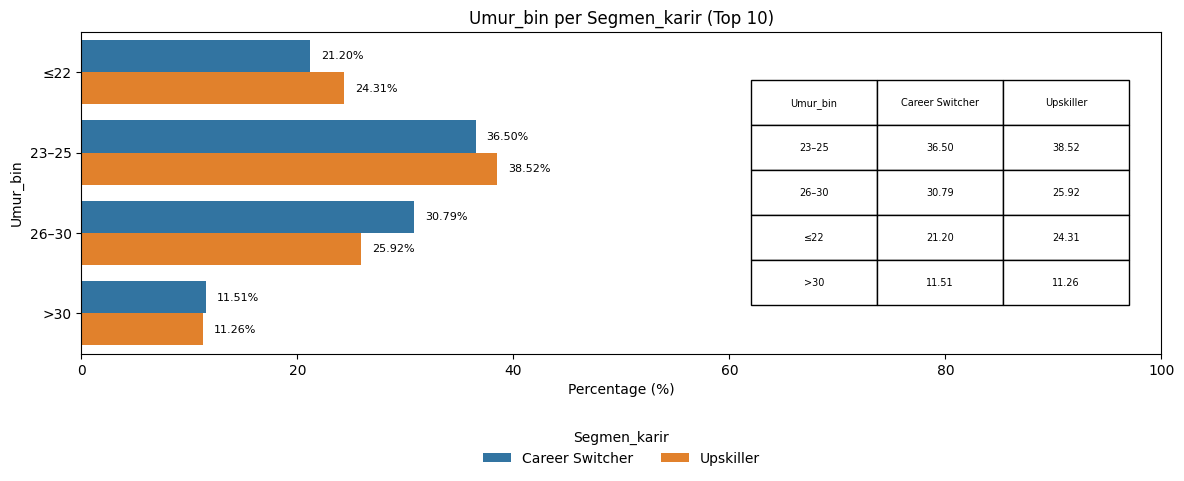

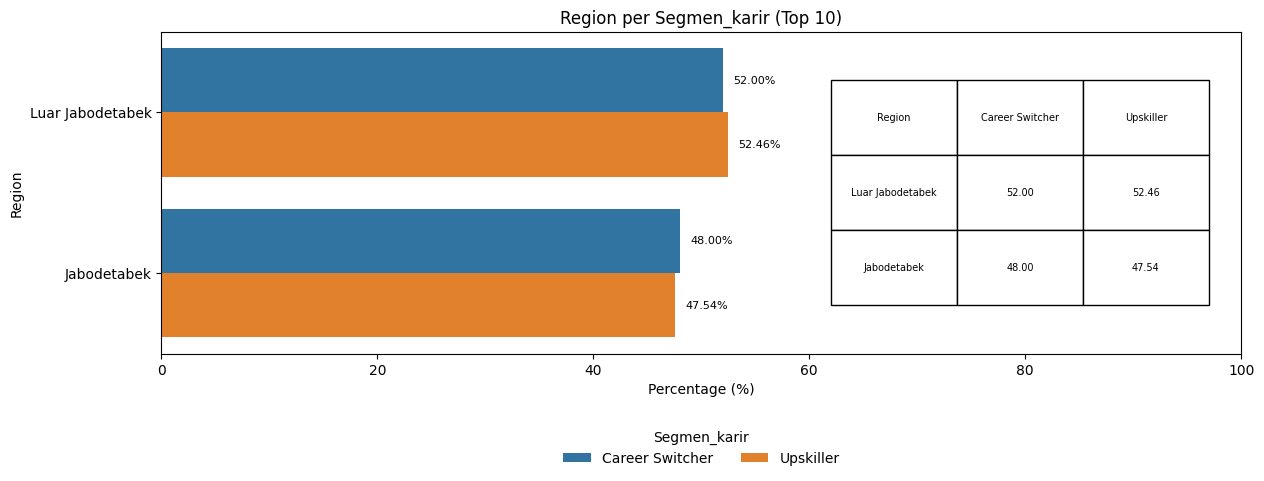

In [89]:
# Umur bin vs segmen karir
summarize_categorical_by_segment(df_q2, "Segmen_karir", "Umur_bin", top_n=10)

# Region vs segmen karir
summarize_categorical_by_segment(df_q2, "Segmen_karir", "Region", top_n=10)

### Domain pendidikan & domain product

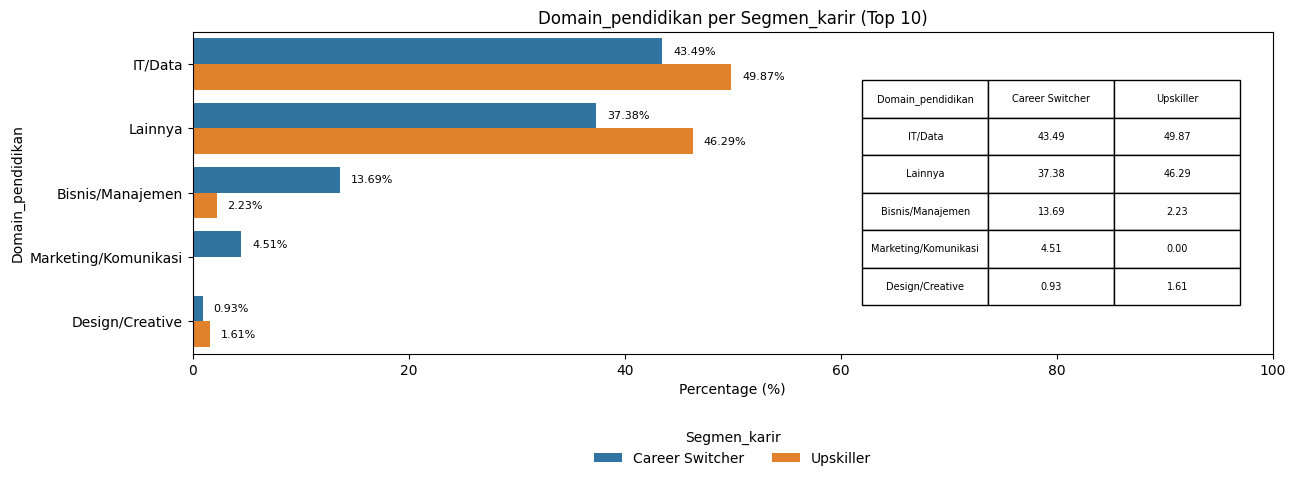

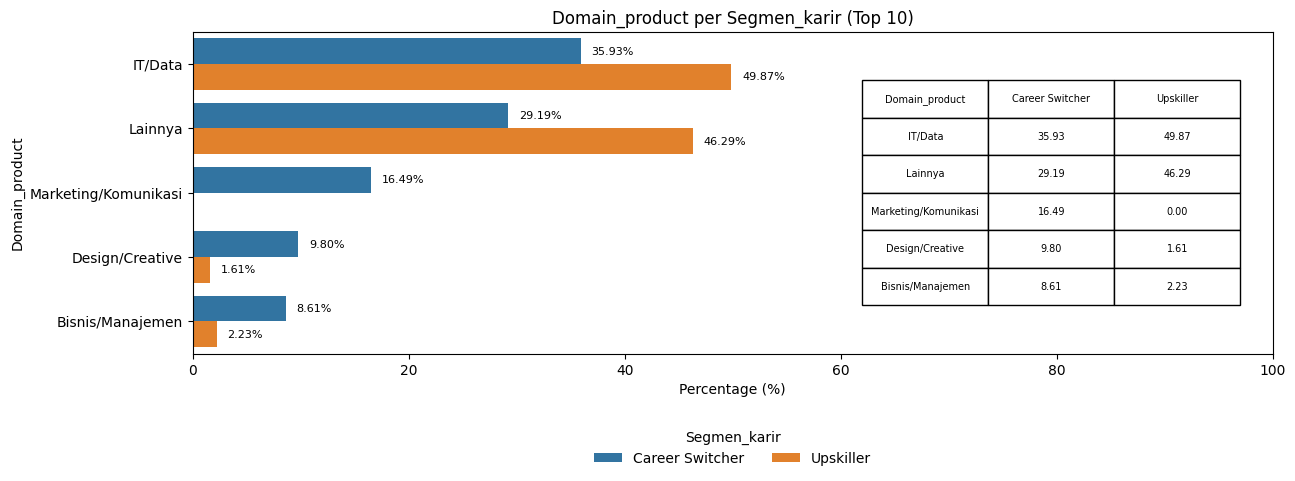

In [90]:
# Domain pendidikan vs segmen karir
summarize_categorical_by_segment(df_q2, "Segmen_karir", "Domain_pendidikan", top_n=10)

# Domain product vs segmen karir
summarize_categorical_by_segment(df_q2, "Segmen_karir", "Domain_product", top_n=10)

### Kesibukan & level pekerjaan

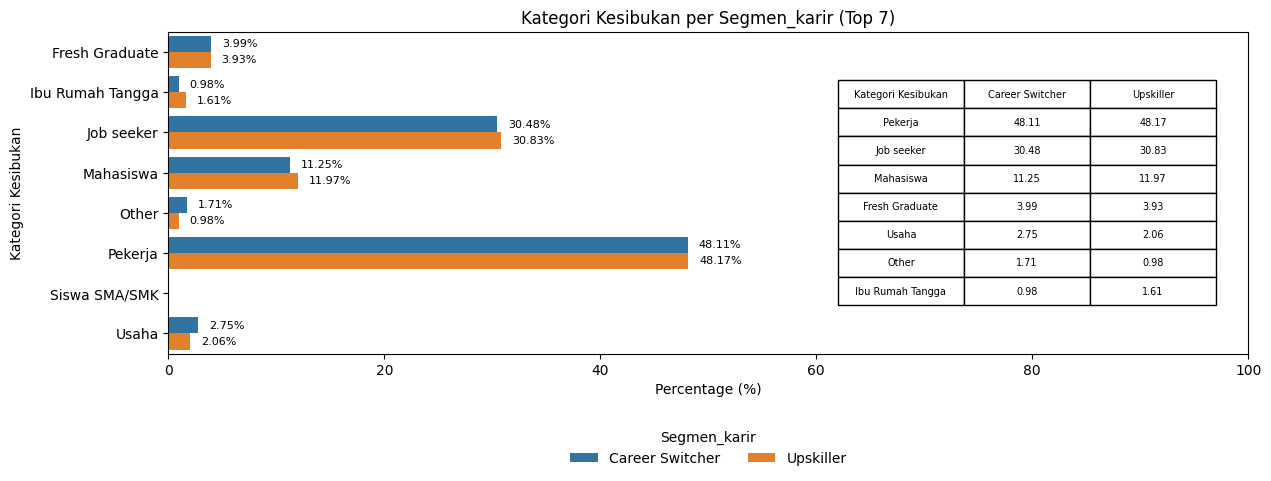

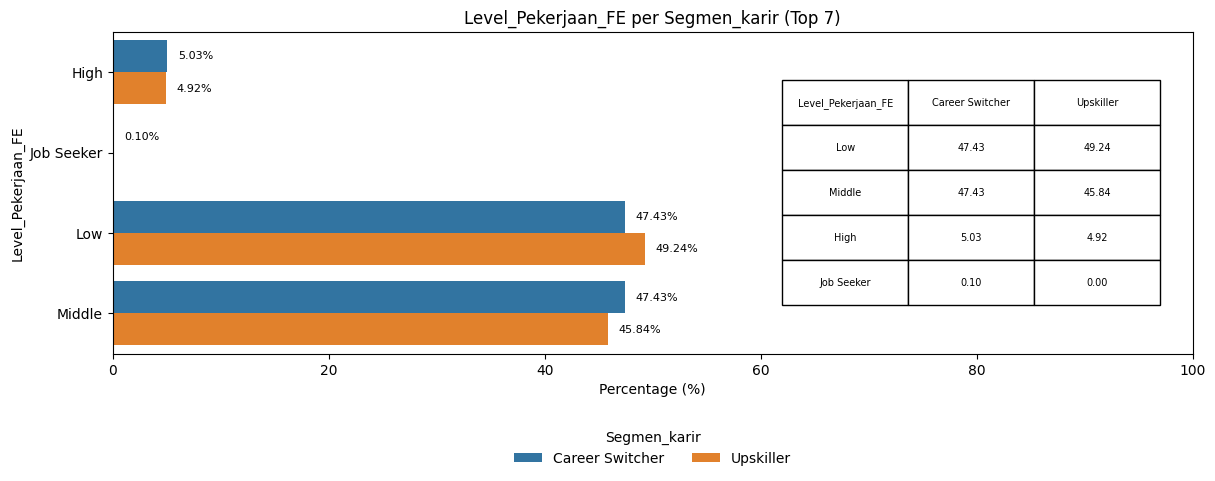

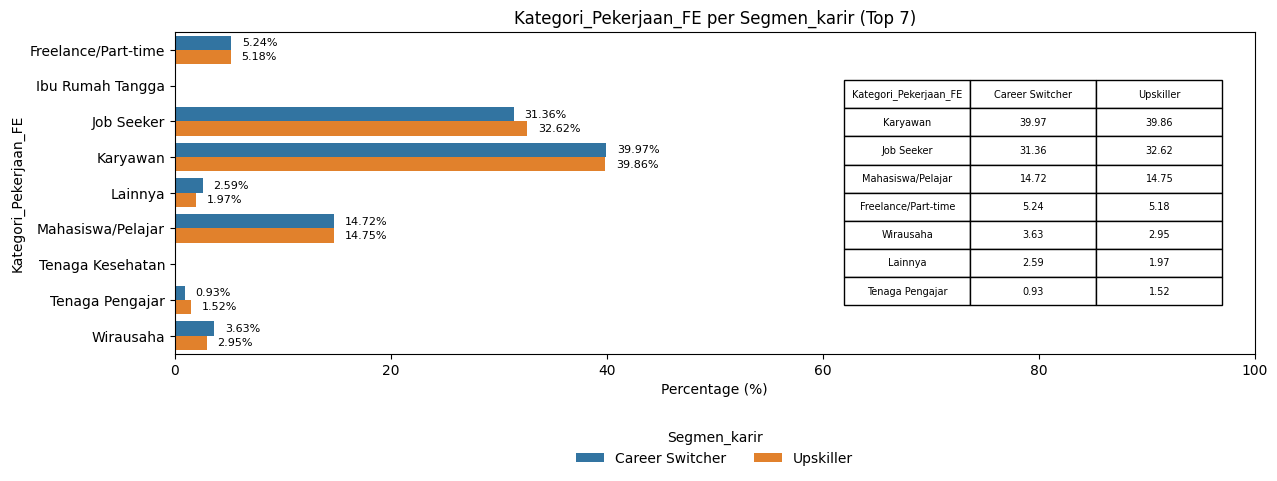

In [91]:
# Kategori Kesibukan → dipakai
summarize_categorical_by_segment(df_q2, "Segmen_karir", "Kategori Kesibukan", top_n=7)

# Level Pekerjaan → pakai versi FE yang sudah dirapikan
summarize_categorical_by_segment(df_q2, "Segmen_karir", "Level_Pekerjaan_FE", top_n=7)

# Kategori Pekerjaan → pakai FE baru
summarize_categorical_by_segment(df_q2, "Segmen_karir", "Kategori_Pekerjaan_FE", top_n=7)

### Pendidikan & engagement

In [92]:
def summarize_categorical_with_table(
  df,
  seg_col,
  feat_col,
  top_n=10
):
  # Cek kolom
  if seg_col not in df.columns:
    raise KeyError(f"Kolom segmen '{seg_col}' tidak ada di df.")
  if feat_col not in df.columns:
    raise KeyError(f"Kolom fitur '{feat_col}' tidak ada di df.")

  # Untuk JC, kita nggak perlu tabel
  show_table = (feat_col != "Program_JC_label")

  # Crosstab proporsi
  ct = pd.crosstab(df[feat_col], df[seg_col], normalize="columns") * 100
  top = df[feat_col].value_counts().head(top_n).index
  ct = ct.loc[top]

  # Long format untuk barplot
  long_df = (
    ct.reset_index()
    .melt(id_vars=feat_col, var_name=seg_col, value_name="percent")
  )

  fig, ax = plt.subplots(figsize=(10, 4.5))

  # Bar Plot
  sns.barplot(
    data=long_df,
    x="percent",
    y=feat_col,
    hue=seg_col,
    ax=ax
  )

  ax.set_xlim(0, 100)
  ax.set_xticks(np.arange(0, 101, 20))
  ax.set_xticklabels([f"{t:.0f}" for t in np.arange(0, 101, 20)])
  ax.set_xlabel("Percentage (%)")
  ax.set_ylabel(feat_col)
  ax.set_title(f"{feat_col} per {seg_col} (Top {top_n})")

  # Label
  label_zone_max = 60

  for p in ax.patches:
    width = p.get_width()
    if width <= 0:
      continue

    y = p.get_y() + p.get_height() / 2.0

    # posisi natural sedikit di luar bar
    x_raw = width + 1.0
    # clamp biar maksimal di sekitar 59%
    x_text = min(x_raw, label_zone_max - 1.0)

    ax.text(
      x_text,
      y,
      f"{width:.2f}%",
      va="center",
      ha="left",
      fontsize=8
    )

  # Tabel
  if show_table:
    cell_text = [
      [idx] + [f"{v:.2f}" for v in row]
      for idx, row in ct.iterrows()
    ]
    col_labels = [feat_col] + list(ct.columns)
    tbl = ax.table(
      cellText=cell_text,
      colLabels=col_labels,
      cellLoc="center",
      bbox=[0.60, 0.05, 0.38, 0.30]
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(7)
    tbl.scale(0.9, 1.05)

    # Legend
  handles, labels = ax.get_legend_handles_labels()
  if ax.get_legend() is not None:
    ax.get_legend().remove()

  # Legend di luar
  if handles:
    fig.legend(
      handles,
      labels,
      title=seg_col,
      loc="lower center",
      ncol=len(labels),
      bbox_to_anchor=(0.5, 0.01),
      frameon=False,
    )

  # Sedikit ruang ekstra buat legend bawah
  fig.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.22)
  plt.show()

In [93]:
"Level_pendidikan_FE" in df_q2.columns, df_q2["Level_pendidikan_FE"].value_counts()

(True,
 Level_pendidikan_FE
 Middle    1551
 High      1379
 Low        118
 Name: count, dtype: int64)

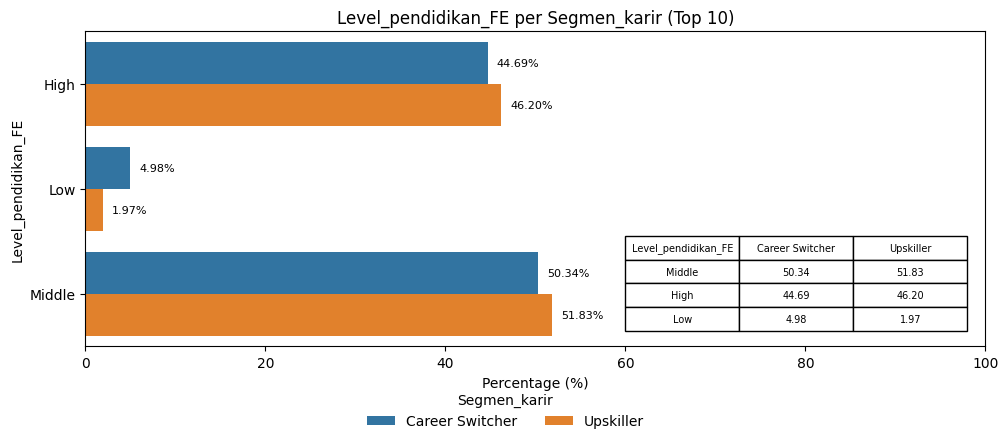

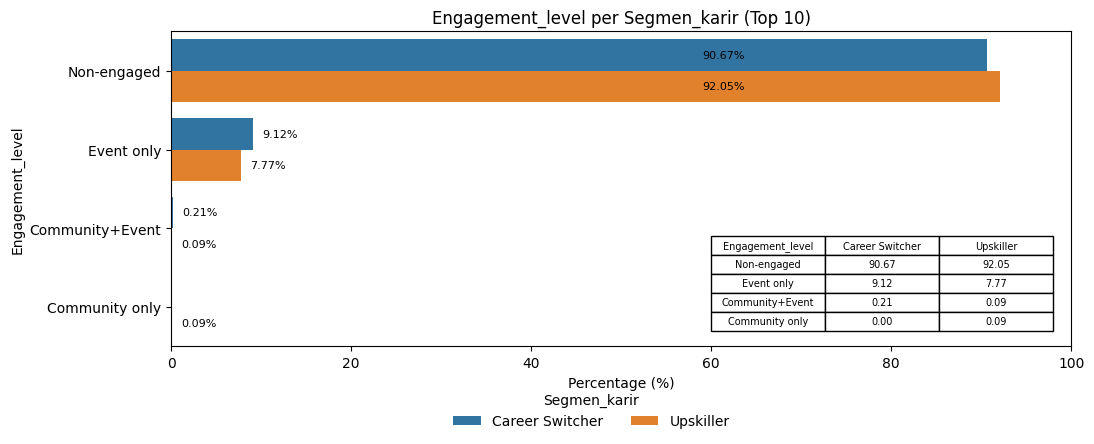

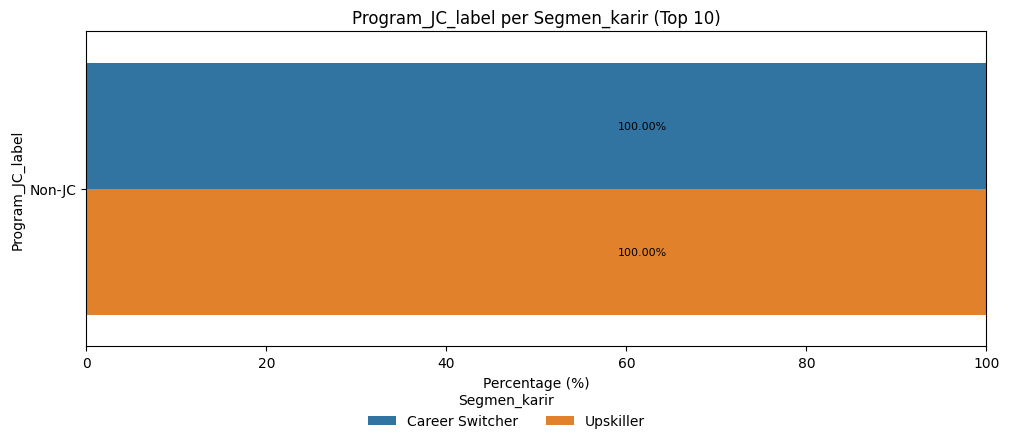

In [94]:
# Level pendidikan vs segmen karir
summarize_categorical_with_table(
  df_q2,
  "Segmen_karir",
  "Level_pendidikan_FE",
  top_n=10
)

# Engagement level vs segmen karir
summarize_categorical_with_table(df_q2, "Segmen_karir", "Engagement_level", top_n=10)

# Program JC (tanpa tabel)
df_q2["Program_JC_label"] = df_q2["Program_jobconnect_flag"].map({0: "Non-JC", 1: "JC"})
summarize_categorical_with_table(df_q2, "Segmen_karir", "Program_JC_label", top_n=10)

## Q3: Funnel akuisisi & kualitas channel

In [95]:
df_q3 = df_std.copy()

print("Q3 Data Shape:", df_q3.shape)
print("\nKolom penting Q3:")
for c in ["Channel", "Dengar Dibimbing darimana", "Penyaluran_flag"]:
  print(f"{c:30} ->", c in df_q3.columns)

Q3 Data Shape: (3048, 54)

Kolom penting Q3:
Channel                        -> True
Dengar Dibimbing darimana      -> True
Penyaluran_flag                -> True


In [96]:
import textwrap

def plot_bar_with_side_table(
  stats_df,
  cat_col,
  value_main_col,
  other_value_cols=None,
  title="",
  x_label="Percentage (%)",
  y_label=None,
  top_n=None,
  x_lim=None,
  value_fmt="{:.1f}%"
):

  df_plot = stats_df.copy()

  # sort desc by main value
  df_plot = df_plot.sort_values(value_main_col, ascending=False)

  # top-N saja
  if top_n is not None:
    df_plot = df_plot.head(top_n)

  labels    = df_plot[cat_col].astype(str).tolist()
  main_vals = df_plot[value_main_col].values

  fig, (ax, ax_tbl) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 4.5),
    gridspec_kw={"width_ratios": [3, 2]}
  )

  # Chart
  ax.barh(labels, main_vals)
  ax.invert_yaxis()

  # x-limit
  if x_lim is None:
    if len(main_vals) == 0:
      max_val = 1.0
    else:
      max_val = float(np.nanmax(main_vals)) if np.nanmax(main_vals) > 0 else 1.0
    x_lim = max_val * 1.30
  ax.set_xlim(0, x_lim)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label if y_label else cat_col)
  ax.set_title(title)

  # label di ujung bar
  for i, v in enumerate(main_vals):
    if pd.isna(v):
      continue
    x_text = min(v + 0.02 * x_lim, x_lim * 0.98)
    ax.text(
      x_text,
      i,
      value_fmt.format(v),
      va="center",
      ha="left",
      fontsize=8
  )

  # Table
  ax_tbl.axis("off")

  wrapped_labels = [
    "\n".join(textwrap.wrap(str(lbl), width=18))
    for lbl in df_plot[cat_col]
  ]

  if other_value_cols is None:
    other_value_cols = []

  # header tabel
  col_labels = [y_label if y_label else cat_col, value_main_col] + other_value_cols

  # isi tabel
  cell_text = []
  for lbl, (_, row) in zip(wrapped_labels, df_plot.iterrows()):
    row_vals = []

    # nilai utama
    main_val = row[value_main_col]
    row_vals.append(value_fmt.format(main_val))

    # kolom N
    for col in other_value_cols:
      val = row[col]
      if isinstance(val, (int, float, np.floating)) and not pd.isna(val):
        if "%" in col or "rate" in col.lower():
          row_vals.append(f"{val:.2f}")
        else:
          row_vals.append(f"{val:,.0f}")
      else:
        row_vals.append(str(val))

    cell_text.append([lbl] + row_vals)

  tbl = ax_tbl.table(
    cellText=cell_text,
    colLabels=col_labels,
    cellLoc="center",
    loc="center"
  )
  tbl.auto_set_font_size(False)
  tbl.set_fontsize(8)

  # skala vertikal menyesuaikan jumlah baris
  scale_y = 1.0 + max(0, len(df_plot) - 6) * 0.20
  tbl.scale(1.2, scale_y)

  # layout
  plt.subplots_adjust(
    left=0.10,
    right=0.98,
    top=0.88,
    bottom=0.15,
    wspace=0.40
  )
  plt.show()

### Volume peserta per channel akuisisi

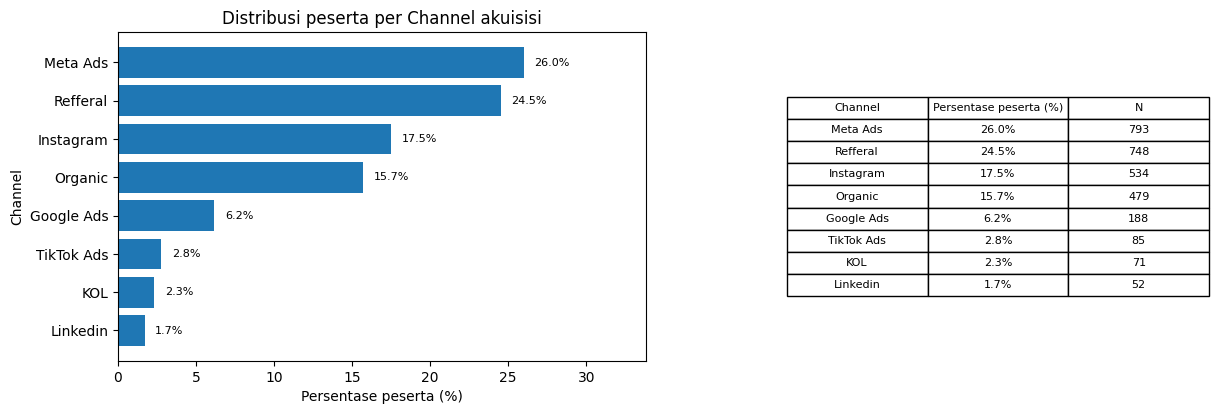

In [97]:
col = "Channel"

counts = df_q3[col].value_counts()
percent = counts / len(df_q3) * 100

stats_channel = pd.DataFrame({
  col: counts.index,
  "Persentase peserta (%)": percent.values,
  "N": counts.values
})

plot_bar_with_side_table(
  stats_df=stats_channel,
  cat_col=col,
  value_main_col="Persentase peserta (%)",
  other_value_cols=["N"],
  title="Distribusi peserta per Channel akuisisi",
  x_label="Persentase peserta (%)",
  y_label="Channel",
  top_n=8,
  value_fmt="{:.1f}%"
)

### Sumber awareness: peserta pertama kali dengar Dibimbing darimana?

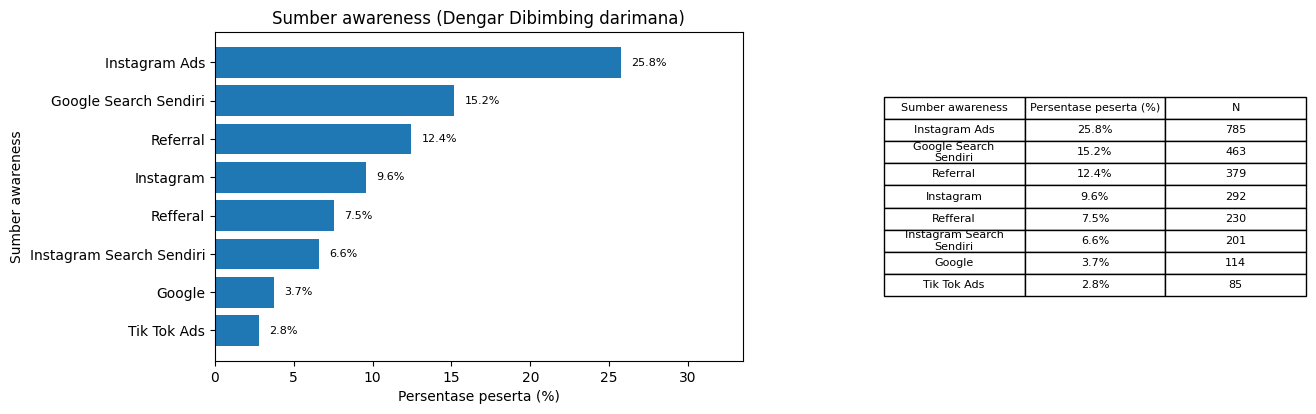

In [98]:
col = "Dengar Dibimbing darimana"

counts = df_q3[col].value_counts()
percent = counts / len(df_q3) * 100

stats_awareness = pd.DataFrame({
  col: counts.index,
  "Persentase peserta (%)": percent.values,
  "N": counts.values
})

plot_bar_with_side_table(
  stats_df=stats_awareness,
  cat_col=col,
  value_main_col="Persentase peserta (%)",
  other_value_cols=["N"],
  title="Sumber awareness (Dengar Dibimbing darimana)",
  x_label="Persentase peserta (%)",
  y_label="Sumber awareness",
  top_n=8,
  value_fmt="{:.1f}%"
)

### Kualitas channel: Placement rate per Channel

/tmp/ipython-input-2525638280.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(col)["Penyaluran_flag"]


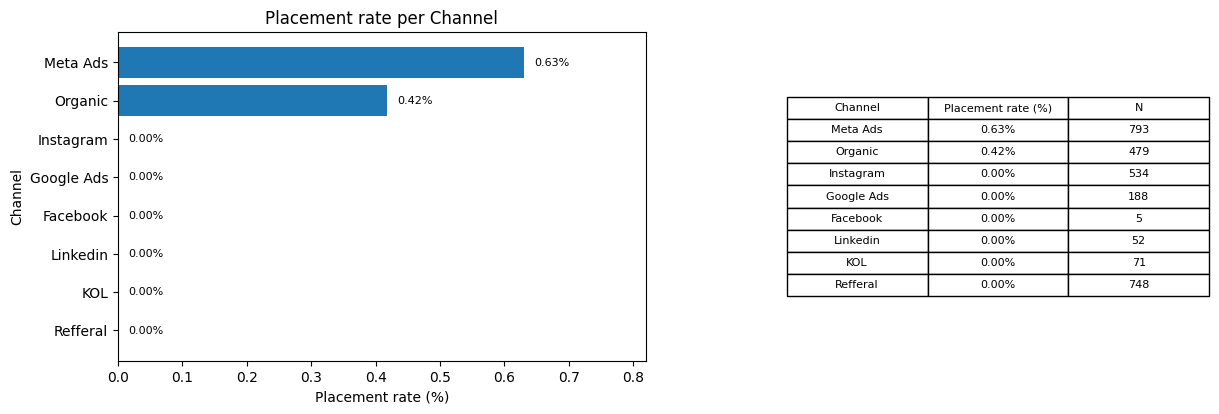

In [99]:
col = "Channel"

placement_stats = (
  df_q3
    .groupby(col)["Penyaluran_flag"]
    .agg(
      **{
        "Placement rate (%)": lambda s: s.mean() * 100,
        "N": "size"
      }
    )
    .reset_index()
)

plot_bar_with_side_table(
  stats_df=placement_stats,
  cat_col=col,
  value_main_col="Placement rate (%)",
  other_value_cols=["N"],
  title="Placement rate per Channel",
  x_label="Placement rate (%)",
  y_label="Channel",
  top_n=8,
  value_fmt="{:.2f}%"
)

## Q4: Motivasi, Ekspektasi, dan Risiko Ketidakcocokan

In [100]:
df_q4 = df_std.copy()

cols_q4 = [
  "Motivasi_cluster",
  "Motivasi_risk_flag",
  "Motivasi_raw_all",
  "Penyaluran_flag",
  "Penyaluran_label",
  "Segmen_karir",
  "Engagement_level",
]

print("Cek kolom penting Q4:")
for c in cols_q4:
  print(f"{c:22}:", c in df_q4.columns)

Cek kolom penting Q4:
Motivasi_cluster      : True
Motivasi_risk_flag    : True
Motivasi_raw_all      : True
Penyaluran_flag       : True
Penyaluran_label      : True
Segmen_karir          : True
Engagement_level      : True


In [101]:
# Helper sederhana: frekuensi + persentase
def make_freq_table(df, cat_col):
  counts  = df[cat_col].value_counts()
  percent = counts / len(df) * 100

  stats = pd.DataFrame({
    cat_col: counts.index,
    "Persentase (%)": percent.values,
    "N": counts.values,
  })

  # urutkan dari kecil ke besar biar bar enak dibaca
  stats = stats.sort_values("Persentase (%)", ascending=True)
  return stats.reset_index(drop=True)

In [102]:
import textwrap

def plot_freq_with_table(stats_df, title,
  x_label="Persentase peserta (%)",
  y_label="Kategori"):

  # Urutkan dari persentase terbesar → terkecil
  stats_df = (
    stats_df
      .sort_values("Persentase (%)", ascending=False)
      .reset_index(drop=True)
  )

  cat_col = stats_df.columns[0]
  labels  = stats_df[cat_col].astype(str).tolist()
  values  = stats_df["Persentase (%)"].values
  counts  = stats_df["N"].values

  fig, ax = plt.subplots(figsize=(10, 4.5))

  # Barplot horizontal 0–100%
  ax.barh(labels, values)
  ax.invert_yaxis()
  ax.set_xlim(0, 100)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.set_title(title)

  # Label % di ujung bar
  for i, v in enumerate(values):
    if v > 0:
      ax.text(
        v + 1, i, f"{v:.2f}%",
        va="center", ha="left", fontsize=8
      )

  # Tabel legend
  # Wrap teks supaya kalimat panjang kebaca semua
  wrapped = ["\n".join(textwrap.wrap(t, width=18)) for t in labels]

  cell_text = [
    [m, f"{p:.2f}", n]
    for m, p, n in zip(wrapped, values, counts)
  ]

  tbl = ax.table(
    cellText=cell_text,
    colLabels=[y_label, "Persentase (%)", "N"],
    cellLoc="center",
    colWidths=[0.35, 0.45, 0.20],
    bbox=[0.60, 0.10, 0.37, 0.80],
  )
  tbl.auto_set_font_size(False)
  tbl.set_fontsize(7)
  tbl.scale(1.0, 1.1)

  plt.subplots_adjust(left=0.12, right=0.98, top=0.90, bottom=0.15)
  plt.show()

### Distribusi motivasi utama peserta

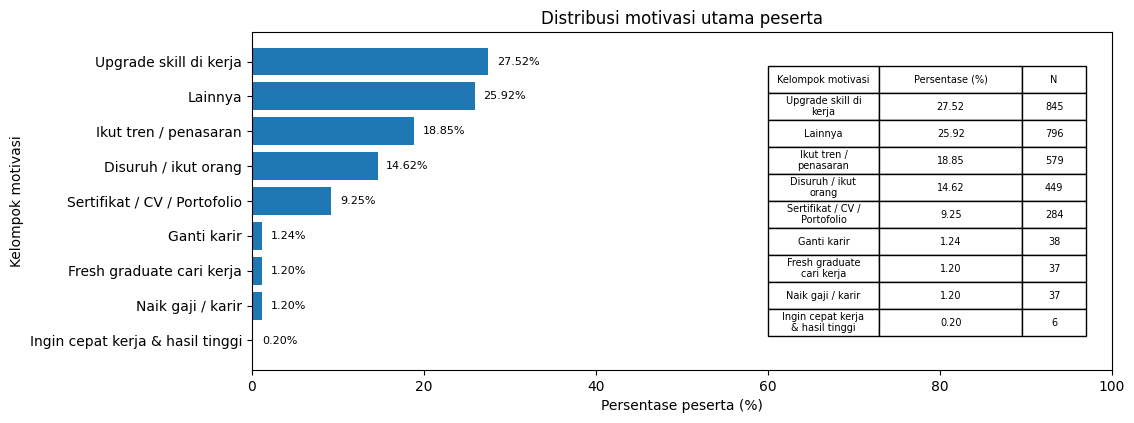

In [103]:
df_q4 = df_model.copy()

stats_mot = make_freq_table(df_q4, "Motivasi_cluster")

plot_freq_with_table(
  stats_mot,
  title="Distribusi motivasi utama peserta",
  x_label="Persentase peserta (%)",
  y_label="Kelompok motivasi"
)

### Placement rate per motivasi

/tmp/ipython-input-1959086819.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_q4.groupby("Motivasi_cluster")["Penyaluran_flag"].mean() * 100


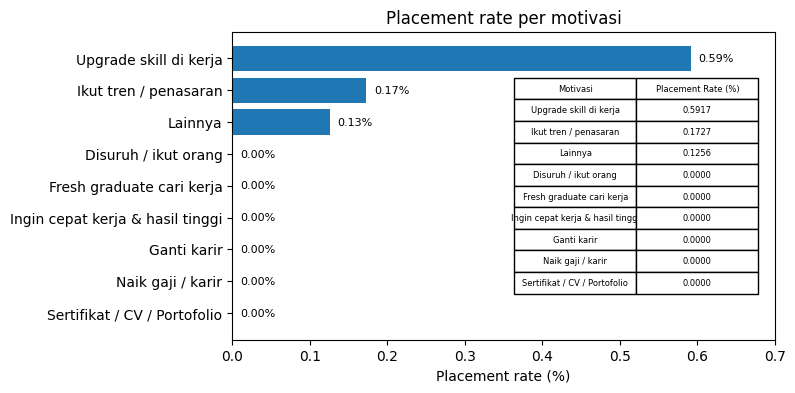

In [104]:
pct = (
  df_q4.groupby("Motivasi_cluster")["Penyaluran_flag"].mean() * 100
).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(7, 4))
ax.barh(pct.index, pct.values)
ax.invert_yaxis()

ax.set_xlim(0, 0.7)
ax.set_xlabel("Placement rate (%)")
ax.set_title("Placement rate per motivasi")

for i, v in enumerate(pct.values):
  ax.text(v + 0.01, i, f"{v:.2f}%", va="center", ha="left", fontsize=8)

tbl = ax.table(
  cellText=[[m, f"{r:.4f}"] for m, r in zip(pct.index, pct.values)],
  colLabels=["Motivasi", "Placement Rate (%)"],
  cellLoc="center",
  bbox=[0.52, 0.15, 0.45, 0.70]
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(6)
tbl.scale(1.05, 1.1)

plt.show()

### Placement rate per kategori risiko


/tmp/ipython-input-1489785194.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pct = (df_q4.groupby("Motivasi_risk_flag")["Penyaluran_flag"].mean() * 100)\


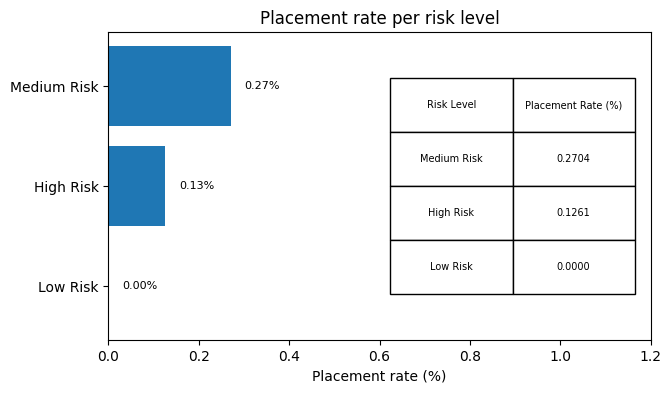

In [105]:
pct = (df_q4.groupby("Motivasi_risk_flag")["Penyaluran_flag"].mean() * 100)\
  .sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(7, 4))
ax.barh(pct.index, pct.values)
ax.invert_yaxis()

ax.set_xlim(0, 1.2)
ax.set_xlabel("Placement rate (%)")
ax.set_title("Placement rate per risk level")

for i, v in enumerate(pct.values):
  ax.text(v + 0.03, i, f"{v:.2f}%", va="center", ha="left", fontsize=8)

tbl = ax.table(
  cellText=[[lvl, f"{r:.4f}"] for lvl, r in zip(pct.index, pct.values)],
  colLabels=["Risk Level", "Placement Rate (%)"],
  cellLoc="center",
  bbox=[0.52, 0.15, 0.45, 0.70]
)

plt.show()

### Motivasi: Career Switcher vs Upskiller

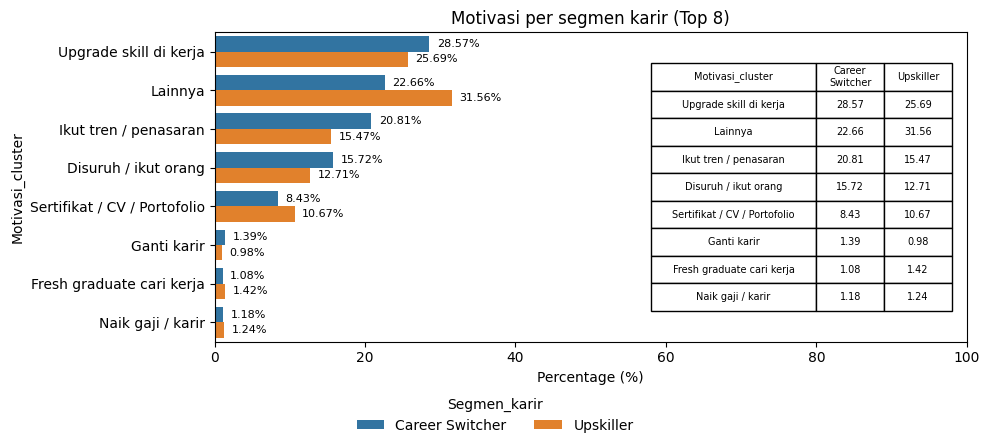

In [106]:
ct = pd.crosstab(df_q4["Motivasi_cluster"], df_q4["Segmen_karir"], normalize="columns")*100
top8 = df_q4["Motivasi_cluster"].value_counts().head(8).index
ct = ct.loc[top8]

long_df = ct.reset_index().melt(id_vars="Motivasi_cluster",
  var_name="Segmen_karir",
  value_name="percent")

fig, ax = plt.subplots(figsize=(10, 4.5))
sns.barplot(data=long_df,
  x="percent", y="Motivasi_cluster",
  hue="Segmen_karir", order=top8, ax=ax)

ax.set_xlim(0, 100)
ax.set_xlabel("Percentage (%)")
ax.set_ylabel("Motivasi_cluster")
ax.set_title("Motivasi per segmen karir (Top 8)")

# label persen di ujung bar
for p in ax.patches:
  v = p.get_width()
  if v > 0:
    ax.text(v + 1,
      p.get_y() + p.get_height()/2,
      f"{v:.2f}%",
      va="center", ha="left", fontsize=8)

# legend dipindah ke bawah
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()
fig.legend(handles, labels, title="Segmen_karir",
  loc="lower center", bbox_to_anchor=(0.5, 0.00),
  ncol=2, frameon=False)

# tabel di kanan
col_labels = ["Motivasi_cluster"] + [
  c.replace("Career Switcher", "Career\nSwitcher") for c in ct.columns
]

tbl = ax.table(
  cellText=[[idx] + [f"{v:.2f}" for v in row] for idx, row in ct.iterrows()],
  colLabels=col_labels,
  cellLoc="center",
  colWidths=[0.55, 0.225, 0.225],
  bbox=[0.58, 0.10, 0.40, 0.80],
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(7)
tbl.scale(0.9, 1.05)

plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.show()

### Risk level per Engagement level

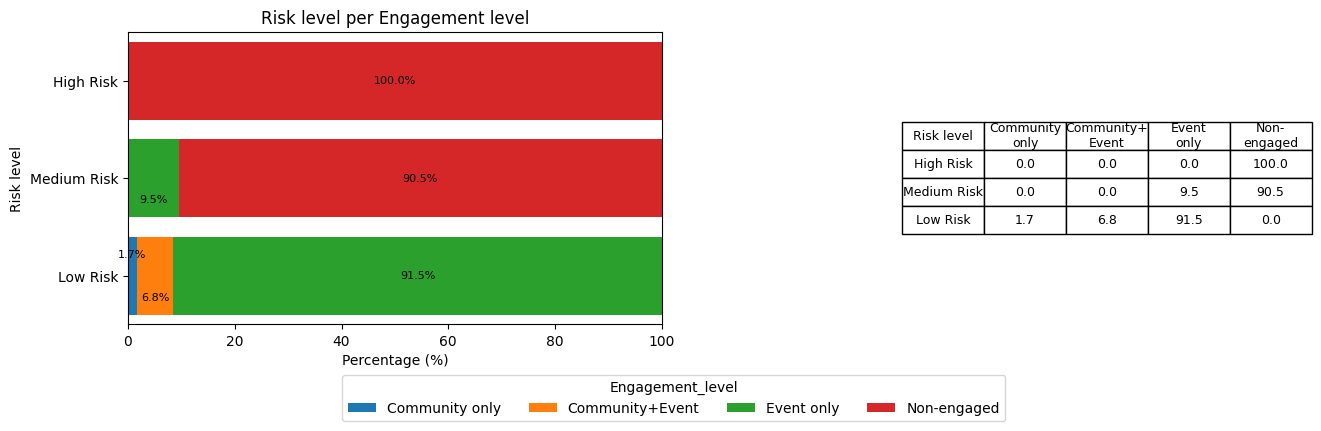

In [107]:
ct = (
  pd.crosstab(
    df_q4["Motivasi_risk_flag"],
    df_q4["Engagement_level"],
    normalize="index"
  ) * 100
)

# Urutan kolom biar warna konsisten
col_order = ["Community only", "Community+Event", "Event only", "Non-engaged"]
cols = [c for c in col_order if c in ct.columns]
ct = ct[cols]

# Urutan baris secara eksplisit
row_order = ["High Risk", "Medium Risk", "Low Risk"]
rows = [r for r in row_order if r in ct.index]
ct = ct.loc[rows]

fig, (ax, ax_tbl) = plt.subplots(
  nrows=1, ncols=2,
  figsize=(13, 4.5),
  gridspec_kw={"width_ratios": [3, 2]}
)

# Chart
bottom = np.zeros(len(ct))
for col in ct.columns:
  ax.barh(ct.index, ct[col].values, left=bottom, label=col)
  bottom += ct[col].values

ax.set_xlim(0, 100)
ax.set_xlabel("Percentage (%)")
ax.set_ylabel("Risk level")
ax.set_title("Risk level per Engagement level")

# Segmen kecil di-stagger
for i, (_, row) in enumerate(ct.iterrows()):
  cum = 0
  small_parts = []

  for j, v in enumerate(row):
    if v < 1:
      cum += v
      continue

    if v < 10:
      small_parts.append((j, v, cum))
    else:
      x = cum + v / 2
      y = i
      ax.text(x, y, f"{v:.1f}%", ha="center", va="center", fontsize=8)

    cum += v

  n_small = len(small_parts)
  if n_small == 1:
    ys = [i + 0.22]
  elif n_small == 2:
    ys = [i - 0.22, i + 0.22]
  elif n_small == 3:
    ys = [i - 0.25, i, i + 0.25]
  else:
    ys = [i + (k - (n_small-1)/2)*0.18 for k in range(n_small)]

  for (j, v, cum_before), y in zip(small_parts, ys):
    x = cum_before + v / 2
    ax.text(x, y, f"{v:.1f}%", ha="center", va="center", fontsize=8)

ax.set_ylim(-0.5, len(ct) - 0.5)
ax.invert_yaxis()

# Table
ax_tbl.axis("off")
header_map = {
  "Community only": "Community\nonly",
  "Community+Event": "Community+\nEvent",
  "Event only": "Event\nonly",
  "Non-engaged": "Non-\nengaged"
}
wrapped_headers = [header_map.get(c, c) for c in ct.columns]

cell_text = [
  [idx] + [f"{v:.1f}" for v in row]
  for idx, row in ct.iterrows()
]
col_labels = ["Risk level"] + wrapped_headers

tbl = ax_tbl.table(
  cellText=cell_text,
  colLabels=col_labels,
  cellLoc="center",
  loc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1.15, 2.0)

# Legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(
  handles, labels,
  title="Engagement_level",
  loc="lower center",
  bbox_to_anchor=(0.5, 0.02),
  ncol=len(ct.columns)
)

plt.subplots_adjust(
  left=0.08,
  right=0.97,
  top=0.9,
  bottom=0.25,
  wspace=0.6
)

plt.show()

In [108]:
import csv

# Mulai dari df_eda yang paling terbaru
df_eda_final = df_eda.copy()

# Hapus baris duplikat
df_eda_final = df_eda_final.drop_duplicates(keep="first").reset_index(drop=True)

# Hapus kolom Batch_kelas
if "Batch_kelas" in df_eda_final.columns:
  df_eda_final = df_eda_final.drop(columns=["Batch_kelas"])

# Bersihkan teks panjang dari newline yang suka bikin CSV pecah di Tableau
text_cols_to_clean = [
  "Motivasi_raw_all",
  "Catatan",
  "Kegiatan yang dilakukan waktu luang/Hobi",
]

for c in text_cols_to_clean:
  if c in df_eda_final.columns:
    df_eda_final[c] = (
      df_eda_final[c]
        .astype(str)
        .str.replace("\r\n", " ", regex=False)
        .str.replace("\n", " ", regex=False)
        .str.replace("\r", " ", regex=False)
    )

In [109]:
# Export artefak final untuk Tableau: pakai df_std
file_name = "dibimbing_eda_for_tableau.csv"

df_eda_final.to_csv(
  file_name,
  index=False,
  encoding="utf-8-sig",
  sep=",",
  quoting=csv.QUOTE_ALL
)

file_name

'dibimbing_eda_for_tableau.csv'

# Clustering (Unsupervised Persona Segmentation)

In [110]:
# Core
import numpy as np
import pandas as pd

# Preprocessing & Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Clustering
from sklearn.cluster import MiniBatchKMeans

# Metrics (pemilihan K)
from sklearn.metrics import silhouette_score

# Dimensionality Reduction buat visualisasi sparse OHE
from sklearn.decomposition import TruncatedSVD

# Plot
import matplotlib.pyplot as plt

In [111]:
# Pakai df_eda_final (biar konsisten sama Tableau)
df_cluster = df_eda_final.copy()

# Drop kolom target & kolom teks/datetime mentah
drop_cols = [
  "Penyaluran_flag", "Penyaluran_label",
  "Motivasi_raw_all",
  "Tanggal Gabungan",
  "Catatan"
]
drop_cols = [c for c in drop_cols if c in df_cluster.columns]
df_cluster = df_cluster.drop(columns=drop_cols)

# Fokus hanya kolom FE persona (lebih bersih)
fe_persona_cols = [
  "Umur", "Umur_bin", "Region",
  "Batch_num", "Batch_has_plus",
  "Community_flag", "Event_flag", "Engagement_level",
  "Kategori_Pekerjaan_FE", "Level_Pekerjaan_FE",
  "Domain_pendidikan", "Domain_product",
  "Segmen_karir", "Level_pendidikan_FE",
  "Motivasi_cluster", "Motivasi_risk_flag",
]
fe_persona_cols = [c for c in fe_persona_cols if c in df_cluster.columns]

# Kalau kolom FE cukup banyak, pakai itu. Kalau tidak, fallback: pakai semua kolom tersisa.
X_df = df_cluster[fe_persona_cols].copy() if len(fe_persona_cols) >= 8 else df_cluster.copy()

print("Shape X_df:", X_df.shape)
print("Kolom dipakai:", X_df.columns.tolist())

Shape X_df: (3048, 16)
Kolom dipakai: ['Umur', 'Umur_bin', 'Region', 'Batch_num', 'Batch_has_plus', 'Community_flag', 'Event_flag', 'Engagement_level', 'Kategori_Pekerjaan_FE', 'Level_Pekerjaan_FE', 'Domain_pendidikan', 'Domain_product', 'Segmen_karir', 'Level_pendidikan_FE', 'Motivasi_cluster', 'Motivasi_risk_flag']


## Preprocess

In [112]:
# Drop kolom yang bukan fitur (kalau ada)
X_df = X_df.copy()

manual_drop = [
  "Penyaluran_flag", "Penyaluran_label",
  "Tanggal Gabungan", "Catatan", "Motivasi_raw_all"
]
manual_drop = [c for c in manual_drop if c in X_df.columns]

# auto-drop yang biasanya bikin clustering “ngaco” (ID/nama/email/telepon/tanggal)
auto_drop = []
for c in X_df.columns:
  cl = c.lower()
  if any(k in cl for k in ["email", "e-mail", "nama", "name", "phone", "telepon", "no hp", "no_hp", "hp"]):
    auto_drop.append(c)
  if cl in ["id", "user_id", "id_user", "id_peserta"] or cl.endswith("_id") or cl.startswith("id_"):
    auto_drop.append(c)
  if "tanggal" in cl or "date" in cl:
    auto_drop.append(c)

drop_cols = sorted(set(manual_drop + auto_drop))
if drop_cols:
  X_df = X_df.drop(columns=drop_cols)

print("Dropped cols:", drop_cols)
print("Shape X_df:", X_df.shape)

Dropped cols: []
Shape X_df: (3048, 16)


In [113]:
# Pisah tipe fitur
num_cols = X_df.select_dtypes(include=[np.number, "bool"]).columns.tolist()
cat_cols = X_df.select_dtypes(include=["object", "category"]).columns.tolist()

# kalau ada kolom "lain-lain" (jarang), masukin ke kategorikal biar aman
other_cols = [c for c in X_df.columns if c not in num_cols + cat_cols]
cat_cols += other_cols

print("Numerik:", num_cols)
print("Kategorikal:", cat_cols)

Numerik: ['Umur', 'Batch_num', 'Batch_has_plus', 'Community_flag', 'Event_flag']
Kategorikal: ['Umur_bin', 'Region', 'Engagement_level', 'Kategori_Pekerjaan_FE', 'Level_Pekerjaan_FE', 'Domain_pendidikan', 'Domain_product', 'Segmen_karir', 'Level_pendidikan_FE', 'Motivasi_cluster', 'Motivasi_risk_flag']


In [114]:
# OneHotEncoder yang compatible lintas versi sklearn
try:
  ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
  ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

preprocess = ColumnTransformer(
  transformers=[
    ("num", StandardScaler(), num_cols),
    ("cat", ohe, cat_cols),
  ],
  remainder="drop",
)

In [115]:
# Cari K terbaik (silhouette + inertia)
k_range = range(2, 11)
results = []

for k in k_range:
  model = MiniBatchKMeans(
    n_clusters=k,
    random_state=42,
    batch_size=1024,
    n_init="auto"
  )
  pipe = Pipeline([("prep", preprocess), ("km", model)])
  pipe.fit(X_df)

  X_trans = pipe.named_steps["prep"].transform(X_df)
  labels = pipe.named_steps["km"].labels_

  sil = silhouette_score(X_trans, labels, metric="euclidean")
  inertia = pipe.named_steps["km"].inertia_

  results.append({"k": k, "silhouette": sil, "inertia": inertia})
  print(f"k={k:2d} | silhouette={sil:.4f} | inertia={inertia:,.2f}")

res_df = pd.DataFrame(results).sort_values("silhouette", ascending=False).reset_index(drop=True)
res_df

k= 2 | silhouette=0.0919 | inertia=31,130.39
k= 3 | silhouette=0.1063 | inertia=28,194.13
k= 4 | silhouette=0.0571 | inertia=27,865.40
k= 5 | silhouette=0.0719 | inertia=26,420.81
k= 6 | silhouette=0.0880 | inertia=25,054.02
k= 7 | silhouette=0.0591 | inertia=25,284.20
k= 8 | silhouette=0.0785 | inertia=22,337.09
k= 9 | silhouette=0.0895 | inertia=21,657.14
k=10 | silhouette=0.0895 | inertia=21,369.25


,k,silhouette,inertia
0,3,0.106252,28194.133205
1,2,0.091928,31130.385572
2,9,0.089471,21657.139858
3,10,0.089457,21369.246818
4,6,0.087963,25054.016335
5,8,0.078513,22337.094173
6,5,0.071881,26420.813759
7,7,0.059076,25284.203302
8,4,0.057118,27865.397352


Catatan:
- Silhouette mengukur seberapa kompak anggota dalam 1 cluster dan seberapa jauh antar cluster.
- Dari hasil percobaan k=2..10, silhouette tertinggi diperoleh pada k=3,
- Sehingga k=3 dipilih sebagai jumlah cluster untuk persona,
best_k = 3


## Fit model final + simpan label cluster & cluster id

In [116]:
# Ambil best_k dari hasil res_df (silhouette tertinggi)
best_k = int(res_df.iloc[0]["k"])
print("Best k:", best_k)

final_model = MiniBatchKMeans(
  n_clusters=best_k,
  random_state=42,
  batch_size=1024,
  n_init="auto"
)

final_pipe = Pipeline([("prep", preprocess), ("km", final_model)])
final_pipe.fit(X_df)

Best k: 3


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('km', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spar

In [117]:
# Label cluster
cluster_id = final_pipe.named_steps["km"].labels_

df_out = df_eda_final.copy()
df_out["cluster_id"] = cluster_id

In [118]:
# Tempel ke df_eda_final
df_out = df_eda_final.copy()
df_out["cluster_id"] = cluster_id

In [119]:
# Label yang lebih enak dibaca
df_out["cluster_label"] = "Cluster " + (df_out["cluster_id"] + 1).astype(str)

# Cek distribusi
df_out["cluster_id"].value_counts().sort_index()

,count
cluster_id,
0,904
1,1051
2,1093


In [120]:
"cluster_label" in df_out.columns

True

## Profiling cluster

In [121]:
# Ukuran cluster (N & %)
cluster_summary = (
  df_out["cluster_id"]
  .value_counts()
  .sort_index()
  .rename("N")
  .to_frame()
)

cluster_summary["Pct(%)"] = (cluster_summary["N"] / len(df_out) * 100).round(2)
cluster_summary

,N,Pct(%)
cluster_id,,
0,904,29.66
1,1051,34.48
2,1093,35.86


In [122]:
# Ringkasan numerik per cluster (ambil yang penting saja)
candidate_num = ["Umur", "Batch_num", "Community_flag", "Event_flag"]
num_to_profile = [c for c in candidate_num if c in df_out.columns]

df_out.groupby(["cluster_id", "cluster_label"])[num_to_profile] \
  .agg(["mean", "median", "min", "max"]) \
  .round(2)

Umur                    Batch_num              \
                           mean median   min   max      mean median  min   
cluster_id cluster_label                                                   
0          Cluster 1      22.64   23.0  15.0  34.0     10.36    7.0  1.0   
1          Cluster 2      28.57   27.0  20.0  55.0     10.01    7.0  1.0   
2          Cluster 3      25.30   25.0  16.0  42.0     29.09   30.0  2.0   

                               Community_flag                Event_flag  \
                           max           mean median min max       mean   
cluster_id cluster_label                                                  
0          Cluster 1      40.0           0.01    0.0   0   1       0.18   
1          Cluster 2      40.0           0.00    0.0   0   0       0.03   
2          Cluster 3      42.0           0.00    0.0   0   0       0.07   

                                         
                         median min max  
cluster_id cluster_label                 
0          Cluster 1        0.0   0   1  
1          Cluster 2        0.0   0   1  
2          Cluster 3        0.0   0   1

In [123]:
# Top kategori per cluster
def top_kategori_per_cluster(df, col, top_n=5):
  if col not in df.columns:
    return None
  tmp = (
    df.groupby(["cluster_id", "cluster_label"])[col]
      .value_counts(dropna=False, normalize=True)
      .mul(100)
      .rename("pct")
      .reset_index()
      .sort_values(["cluster_id", "pct"], ascending=[True, False])
  )
  return tmp.groupby(["cluster_id", "cluster_label"]).head(top_n)

cat_to_profile = [
  "Umur_bin", "Region", "Segmen_karir",
  "Kategori_Pekerjaan_FE", "Level_Pekerjaan_FE",
  "Engagement_level", "Motivasi_cluster", "Motivasi_risk_flag",
  "Domain_pendidikan", "Domain_product",
]
cat_to_profile = [c for c in cat_to_profile if c in df_out.columns]

for col in cat_to_profile:
  t = top_kategori_per_cluster(df_out, col, top_n=5)
  print("\n", col)
  display(t)


 Umur_bin


,cluster_id,cluster_label,Umur_bin,pct
0,0,Cluster 1,≤22,48.561947
1,0,Cluster 1,23–25,41.592920
2,0,Cluster 1,26–30,9.513274
3,0,Cluster 1,>30,0.331858
4,0,Cluster 2,≤22,0.000000
5,0,Cluster 2,23–25,0.000000
6,0,Cluster 2,26–30,0.000000
7,0,Cluster 2,>30,0.000000
8,0,Cluster 3,≤22,0.000000
9,0,Cluster 3,23–25,0.000000



 Region


,cluster_id,cluster_label,Region,pct
0,0,Cluster 1,Luar Jabodetabek,60.398230
1,0,Cluster 1,Jabodetabek,39.601770
2,1,Cluster 2,Jabodetabek,55.566127
3,1,Cluster 2,Luar Jabodetabek,44.433873
4,2,Cluster 3,Luar Jabodetabek,52.790485
5,2,Cluster 3,Jabodetabek,47.209515



 Segmen_karir


,cluster_id,cluster_label,Segmen_karir,pct
0,0,Cluster 1,Career Switcher,54.646018
1,0,Cluster 1,Upskiller,45.353982
2,1,Cluster 2,Career Switcher,55.566127
3,1,Cluster 2,Upskiller,44.433873
4,2,Cluster 3,Career Switcher,77.859103
5,2,Cluster 3,Upskiller,22.140897



 Kategori_Pekerjaan_FE


,cluster_id,cluster_label,Kategori_Pekerjaan_FE,pct
0,0,Cluster 1,Job Seeker,54.203540
1,0,Cluster 1,Mahasiswa/Pelajar,34.513274
2,0,Cluster 1,Karyawan,6.415929
3,0,Cluster 1,Freelance/Part-time,2.433628
4,0,Cluster 1,Lainnya,1.216814
9,0,Cluster 2,Freelance/Part-time,0.000000
10,0,Cluster 2,Ibu Rumah Tangga,0.000000
11,0,Cluster 2,Job Seeker,0.000000
12,0,Cluster 2,Karyawan,0.000000
13,0,Cluster 2,Lainnya,0.000000



 Level_Pekerjaan_FE


,cluster_id,cluster_label,Level_Pekerjaan_FE,pct
0,0,Cluster 1,Low,90.707965
1,0,Cluster 1,Middle,8.960177
2,0,Cluster 1,High,0.331858
3,0,Cluster 1,Job Seeker,0.000000
4,0,Cluster 2,High,0.000000
5,0,Cluster 2,Job Seeker,0.000000
6,0,Cluster 2,Low,0.000000
7,0,Cluster 2,Middle,0.000000
8,0,Cluster 3,High,0.000000
9,0,Cluster 3,Job Seeker,0.000000



 Engagement_level


,cluster_id,cluster_label,Engagement_level,pct
0,0,Cluster 1,Non-engaged,81.858407
1,0,Cluster 1,Event only,17.477876
2,0,Cluster 1,Community+Event,0.553097
3,0,Cluster 1,Community only,0.110619
4,1,Cluster 2,Non-engaged,97.050428
5,1,Cluster 2,Event only,2.949572
6,2,Cluster 3,Non-engaged,93.229643
7,2,Cluster 3,Event only,6.770357



 Motivasi_cluster


,cluster_id,cluster_label,Motivasi_cluster,pct
0,0,Cluster 1,Upgrade skill di kerja,26.880531
1,0,Cluster 1,Lainnya,25.884956
2,0,Cluster 1,Ikut tren / penasaran,17.035398
3,0,Cluster 1,Disuruh / ikut orang,15.154867
4,0,Cluster 1,Sertifikat / CV / Portofolio,11.172566
9,0,Cluster 2,Disuruh / ikut orang,0.000000
10,0,Cluster 2,Fresh graduate cari kerja,0.000000
11,0,Cluster 2,Ganti karir,0.000000
12,0,Cluster 2,Ikut tren / penasaran,0.000000
13,0,Cluster 2,Ingin cepat kerja & hasil tinggi,0.000000



 Motivasi_risk_flag


,cluster_id,cluster_label,Motivasi_risk_flag,pct
0,0,Cluster 1,Medium Risk,76.548673
1,0,Cluster 1,High Risk,19.137168
2,0,Cluster 1,Low Risk,4.314159
3,0,Cluster 2,High Risk,0.000000
4,0,Cluster 2,Low Risk,0.000000
5,0,Cluster 2,Medium Risk,0.000000
6,0,Cluster 3,High Risk,0.000000
7,0,Cluster 3,Low Risk,0.000000
8,0,Cluster 3,Medium Risk,0.000000
12,1,Cluster 2,Medium Risk,78.496670



 Domain_pendidikan


,cluster_id,cluster_label,Domain_pendidikan,pct
0,0,Cluster 1,IT/Data,44.469027
1,0,Cluster 1,Lainnya,43.805310
2,0,Cluster 1,Bisnis/Manajemen,9.513274
3,0,Cluster 1,Marketing/Komunikasi,1.880531
4,0,Cluster 1,Design/Creative,0.331858
5,1,Cluster 2,IT/Data,44.529020
6,1,Cluster 2,Lainnya,39.961941
7,1,Cluster 2,Bisnis/Manajemen,10.466223
8,1,Cluster 2,Marketing/Komunikasi,4.091342
9,1,Cluster 2,Design/Creative,0.951475



 Domain_product


,cluster_id,cluster_label,Domain_product,pct
0,0,Cluster 1,Lainnya,52.876106
1,0,Cluster 1,IT/Data,32.964602
2,0,Cluster 1,Bisnis/Manajemen,6.084071
3,0,Cluster 1,Marketing/Komunikasi,5.199115
4,0,Cluster 1,Design/Creative,2.876106
5,1,Cluster 2,Lainnya,50.523311
6,1,Cluster 2,IT/Data,35.680304
7,1,Cluster 2,Bisnis/Manajemen,7.136061
8,1,Cluster 2,Marketing/Komunikasi,3.615604
9,1,Cluster 2,Design/Creative,3.044719


## Visualisasi 2D

In [124]:
from sklearn.decomposition import TruncatedSVD

In [125]:
# Transform fitur dengan preprocess yang sama
X_trans = final_pipe.named_steps["prep"].transform(X_df)

In [126]:
# Reduce ke 2D
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_trans)

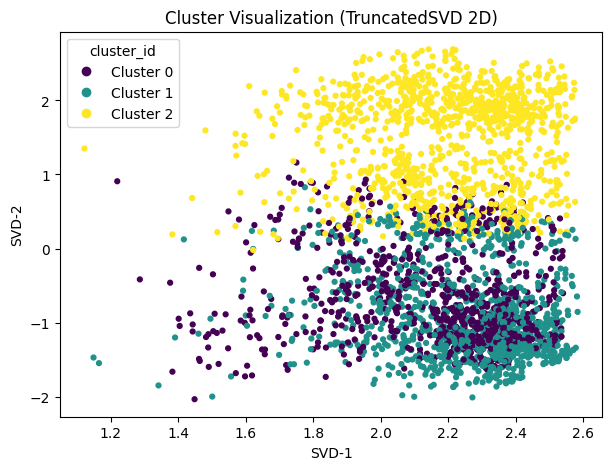

In [127]:
# Plot
plt.figure(figsize=(7,5))
sc = plt.scatter(
  X_2d[:, 0],
  X_2d[:, 1],
  c=df_out["cluster_id"].values,
  s=12
)

plt.title("Cluster Visualization (TruncatedSVD 2D)")
plt.xlabel("SVD-1")
plt.ylabel("SVD-2")

# Legend sederhana
handles, _ = sc.legend_elements()
labels = [f"Cluster {i}" for i in sorted(df_out["cluster_id"].unique())]
plt.legend(handles, labels, title="cluster_id", loc="best")
plt.show()

In [128]:
# Transform fitur dengan preprocess yang sama
X_trans = final_pipe.named_steps["prep"].transform(X_df)

In [129]:
# contoh mapping (nanti kamu isi berdasarkan hasil profiling)
persona_map = {
  0: "High Engagement Career Switcher",
  1: "Fresh Graduate Explorer",
  2: "Working Professional Upskiller"
}

df_out["cluster_name"] = df_out["cluster_id"].map(persona_map)

# fallback kalau ada yang belum ke-map
df_out["cluster_name"] = df_out["cluster_name"].fillna(
  "Cluster " + (df_out["cluster_id"] + 1).astype(str)
)

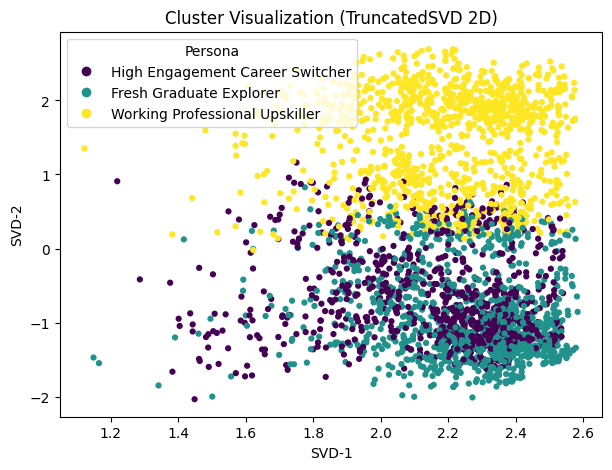

In [130]:
# Reduce ke 2D (aman buat sparse)
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_trans)

plt.figure(figsize=(7,5))

sc = plt.scatter(
  X_2d[:, 0],
  X_2d[:, 1],
  c=df_out["cluster_id"].values,
  s=12
)

plt.title("Cluster Visualization (TruncatedSVD 2D)")
plt.xlabel("SVD-1")
plt.ylabel("SVD-2")

# Legend pakai cluster_name (bukan cluster_label)
uniq = (
  df_out[["cluster_id", "cluster_name"]]
  .drop_duplicates()
  .sort_values("cluster_id")
)

handles, _ = sc.legend_elements()
plt.legend(
  handles,
  uniq["cluster_name"].tolist(),
  title="Persona",
  loc="best"
)

plt.show()

# Feature Engineering (Untuk Supervised Task)

In [131]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
  accuracy_score,
  f1_score,
  precision_score,
  recall_score,
  roc_auc_score,
  log_loss,
  classification_report,
  roc_curve,
  auc
)

import matplotlib.pyplot as plt

In [132]:
# Pemilihan kolom yang paling penting
target = "Penyaluran_flag"

core_cols = [
  "Umur", "Umur_bin", "Region",
  "Product", "Kategori", "Batch_num", "Batch_has_plus",
  "Community_flag", "Event_flag", "Engagement_level",
  "Kategori_Pekerjaan_FE", "Level_Pekerjaan_FE", "Segmen_karir", "is_switcher",
  "Level_pendidikan_FE", "Domain_pendidikan", "Domain_product",
  "Motivasi_cluster", "Motivasi_risk_flag",
  "Channel", "Month",
  "cluster_id"
]

use_cols = [c for c in core_cols if c in df_eda_final.columns]

X = df_eda_final[use_cols].copy()
y = df_eda_final[target].copy()

print("Fitur dipakai:", use_cols)
print("X shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Fitur dipakai: ['Umur', 'Umur_bin', 'Region', 'Product', 'Kategori', 'Batch_num', 'Batch_has_plus', 'Community_flag', 'Event_flag', 'Engagement_level', 'Kategori_Pekerjaan_FE', 'Level_Pekerjaan_FE', 'Segmen_karir', 'is_switcher', 'Level_pendidikan_FE', 'Domain_pendidikan', 'Domain_product', 'Motivasi_cluster', 'Motivasi_risk_flag', 'Channel', 'Month']
X shape: (3048, 21)
Target distribution:
 Penyaluran_flag
0    3041
1       7
Name: count, dtype: int64


Kenapa fitur yang dipakai cuma yang “penting”?
1) Relevan ke peluang penyaluran kerja:
- profil peserta (umur/region), latar pendidikan & domain,
- program/cohort (product/kategori/batch),
- aktivitas/engagement (komunitas/event),
- kondisi karier (segmen/level/switcher),
- motivasi (ringkasan hasil clustering motivasi).

2) Datanya sudah diringkas (hasil feature engineering), jadi lebih rapi dan konsisten dibanding kolom mentah yang banyak variasinya.

3) Menghindari “noise” yang bikin model gampang salah belajar:
- kolom teks panjang atau kategori terlalu banyak (mis. jawaban bebas),
- kolom mentah yang detail banget,
- kolom yang tidak menambah informasi.

Dengan cara ini, model lebih stabil, lebih mudah dijelaskan, dan lebih aman untuk tuning.


## Cleaning khusus supervised

In [133]:
X = X.copy()

# numerik to numeric
for c in ["Umur", "Batch_num"]:
  if c in X.columns:
    X[c] = pd.to_numeric(X[c], errors="coerce")

# kategorikal to string
for c in X.columns:
  if X[c].dtype == "object":
    X[c] = X[c].astype(str).str.strip()

## Preprocess pipeline (belum fit)

In [134]:
from sklearn.impute import SimpleImputer

# deteksi kolom numerik/kategorikal
num_cols = X.select_dtypes(include=[np.number, "bool"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# OneHotEncoder compatible lintas versi sklearn
try:
  ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
  ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

numeric_pipe = Pipeline([
  ("imp", SimpleImputer(strategy="median")),
  ("sc", StandardScaler())
])

categorical_pipe = Pipeline([
  ("imp", SimpleImputer(strategy="constant", fill_value="Unknown")),
  ("ohe", ohe)
])

preprocess = ColumnTransformer(
  transformers=[
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
  ],
  remainder="drop"
)

print("Numerik:", num_cols)
print("Kategorikal:", cat_cols)

Numerik: ['Umur', 'Batch_num', 'Batch_has_plus', 'Community_flag', 'Event_flag', 'is_switcher']
Kategorikal: ['Umur_bin', 'Region', 'Product', 'Kategori', 'Engagement_level', 'Kategori_Pekerjaan_FE', 'Level_Pekerjaan_FE', 'Segmen_karir', 'Level_pendidikan_FE', 'Domain_pendidikan', 'Domain_product', 'Motivasi_cluster', 'Motivasi_risk_flag', 'Channel', 'Month']


# Train-Test Split

Karena target kita yang 1 cuma 7, ada 2 hal penting biar split-nya nggak “zonk”:
1. Wajib stratify=y
2. Pakai test_size kecil biar test tetap kebagian minimal 1 positif (mis. 0.2 biasanya aman, jadi 7×0.2 jadi sekitar 1–2 positif)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  test_size=0.2,
  random_state=42,
  stratify=y
)

print("Train target:\n", y_train.value_counts())
print("Test target:\n", y_test.value_counts())

Train target:
 Penyaluran_flag
0    2432
1       6
Name: count, dtype: int64
Test target:
 Penyaluran_flag
0    609
1      1
Name: count, dtype: int64


# Baseline Modeling

Karena positive cuma sedikit, baseline yang paling stabil biasanya Logistic Regression + class_weight="balanced".

In [136]:
# Logistic Regression (imbangin kelas)
clf = LogisticRegression(
  max_iter=2000,
  class_weight="balanced",
  solver="liblinear" # untuk data imbalanced
)

model_pipe = Pipeline([
  ("prep", preprocess),
  ("clf", clf)
])

# Fit ke train
model_pipe.fit(X_train, y_train)

print("Model already fitted")

Model already fitted


## Cek performa model

In [137]:
# Classification behavior
from sklearn.metrics import classification_report, confusion_matrix

y_proba = model_pipe.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

Confusion matrix:
 [[597  12]
 [  1   0]]

Classification report:
               precision    recall  f1-score   support

           0      0.998     0.980     0.989       609
           1      0.000     0.000     0.000         1

    accuracy                          0.979       610
   macro avg      0.499     0.490     0.495       610
weighted avg      0.997     0.979     0.988       610



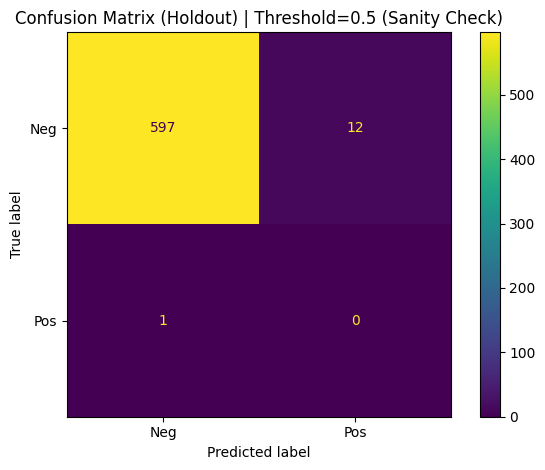

NOTE: Confusion matrix ini hanya sanity check threshold=0.5; keputusan utama pakai ranking Top-K.


In [138]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# y_proba sudah ada
y_pred = (y_proba >= 0.5).astype(int)

disp = ConfusionMatrixDisplay.from_predictions(
  y_test,
  y_pred,
  display_labels=["Neg", "Pos"],
  values_format="d"
)

plt.title("Confusion Matrix (Holdout) | Threshold=0.5 (Sanity Check)")
plt.tight_layout()
plt.show()
print("NOTE: Confusion matrix ini hanya sanity check threshold=0.5; keputusan utama pakai ranking Top-K.")

## Cek Treshold

In [139]:
from sklearn.metrics import confusion_matrix

for t in [0.5, 0.2, 0.1, 0.05, 0.02]:
  y_pred_t = (y_proba >= t).astype(int)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
  print(f"thr={t:>4} | TP={tp} FN={fn} FP={fp} TN={tn}")

thr= 0.5 | TP=0 FN=1 FP=12 TN=597
thr= 0.2 | TP=0 FN=1 FP=26 TN=583
thr= 0.1 | TP=0 FN=1 FP=32 TN=577
thr=0.05 | TP=0 FN=1 FP=43 TN=566
thr=0.02 | TP=0 FN=1 FP=68 TN=541


## Ranking FN ke Top-K

In [140]:
score_df = pd.DataFrame({
  "y_true": y_test.values,
  "proba": y_proba
}).sort_values("proba", ascending=False).reset_index(drop=True)

# posisi si positif (0 = paling tinggi)
pos_rank = score_df.index[score_df["y_true"] == 1].tolist()
print("Rank positif di test:", pos_rank)

# apakah masuk Top-K
for k in [10, 20, 50, 100, 200]:
  hit = score_df.head(k)["y_true"].sum()
  print(f"Top-{k}: positif ketangkep = {int(hit)}")

Rank positif di test: [82]
Top-10: positif ketangkep = 0
Top-20: positif ketangkep = 0
Top-50: positif ketangkep = 0
Top-100: positif ketangkep = 1
Top-200: positif ketangkep = 1


# Model Tuning #1

## Cari Best Model dengan Pakai CV yang stratified dan shuffle

Biar pembagian fold lebih stabil.

In [141]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [142]:
pipe = Pipeline([
  ("prep", preprocess),
  ("clf", LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    solver="liblinear"
  ))
])

param_grid = {"clf__C": [0.01, 0.1, 1, 10, 100]}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

gs = GridSearchCV(
  pipe,
  param_grid=param_grid,
  scoring="average_precision",
  cv=cv,
  n_jobs=-1
)

gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV PR-AUC:", gs.best_score_)
best_model = gs.best_estimator_

Best params: {'clf__C': 100}
Best CV PR-AUC: 0.2591434968239092


Alasan scoring tuning pakai PR-AUC (Average Precision): Karena target positif sangat jarang, PR-AUC lebih representatif untuk menilai kemampuan model dalam memprioritaskan kandidat positif (ranking/top-K), dibanding accuracy/ROC-AUC yang bisa menipu pada data timpang. Kode dibawah sebagai perbandingan


In [143]:
from sklearn.metrics import (
  average_precision_score, roc_auc_score, log_loss, brier_score_loss,
  confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
)

In [144]:
def eval_model(name, model, X_test, y_test, thresholds=(0.5, 0.2, 0.1, 0.05), topk=(20, 50, 100, 200)):
  # proba kelas 1
  y_proba = model.predict_proba(X_test)[:, 1]

  out = {
    "model": name,
    "PR-AUC (AvgPrec)": average_precision_score(y_test, y_proba),
    "ROC-AUC": roc_auc_score(y_test, y_proba),
    "LogLoss": log_loss(y_test, y_proba, labels=[0, 1]),
    "Brier": brier_score_loss(y_test, y_proba),
    "Proba_min": float(np.min(y_proba)),
    "Proba_max": float(np.max(y_proba)),
  }

  # Threshold metrics
  thr_rows = []
  for t in thresholds:
    y_pred = (y_proba >= t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    thr_rows.append({
      "model": name,
      "thr": t,
      "TP": tp, "FN": fn, "FP": fp, "TN": tn,
      "precision": precision_score(y_test, y_pred, zero_division=0),
      "recall": recall_score(y_test, y_pred, zero_division=0),
      "f1": f1_score(y_test, y_pred, zero_division=0),
      "accuracy": accuracy_score(y_test, y_pred),
    })

  thr_df = pd.DataFrame(thr_rows)

  # Top-K capture + rank positive
  score_df = pd.DataFrame({"y_true": np.array(y_test), "proba": y_proba}) \
    .sort_values("proba", ascending=False).reset_index(drop=True)

  pos_rank = score_df.index[score_df["y_true"] == 1].tolist()
  out["Pos_rank_0based"] = pos_rank[0] if len(pos_rank) else None
  out["Pos_rank_1based"] = (pos_rank[0] + 1) if len(pos_rank) else None

  for k in topk:
    out[f"Top-{k} hit"] = int(score_df.head(k)["y_true"].sum())

  return out, thr_df, score_df

In [145]:
# Jalankan evaluasi untuk model yang tersedia
summary_rows = []
thr_all = []

if "model_pipe" in globals():
  s, tdf, _ = eval_model("Baseline (LogReg)", model_pipe, X_test, y_test)
  summary_rows.append(s); thr_all.append(tdf)

if "best_model" in globals():
  s, tdf, _ = eval_model("Tuned (Best CV)", best_model, X_test, y_test)
  summary_rows.append(s); thr_all.append(tdf)

summary_df = pd.DataFrame(summary_rows)
thr_df = pd.concat(thr_all, ignore_index=True) if thr_all else pd.DataFrame()

print("Summary (probability-based metrics + ranking)")
display(summary_df)

Summary (probability-based metrics + ranking)


,model,PR-AUC (AvgPrec),ROC-AUC,LogLoss,Brier,Proba_min,Proba_max,Pos_rank_0based,Pos_rank_1based,Top-20 hit,Top-50 hit,Top-100 hit,Top-200 hit
0,Baseline (LogReg),0.012048,0.865353,0.053612,0.015907,2.177801e-09,0.977165,82,83,0,0,1,1
1,Tuned (Best CV),0.020000,0.919540,0.038354,0.008660,2.580687e-26,0.927822,49,50,0,1,1,1


Saya memilih menggunakan PR-AUC karena target positif sangat jarang (data timpang), ROC-AUC bisa terlihat tinggi walaupun model belum efektif untuk memprioritaskan kandidat positif.


In [146]:
print("\n Threshold metrics (lihat trade-off precision/recall/FN/FP)")
display(thr_df.sort_values(["model", "thr"]))


 Threshold metrics (lihat trade-off precision/recall/FN/FP)


,model,thr,TP,FN,FP,TN,precision,recall,f1,accuracy
3,Baseline (LogReg),0.05,0,1,43,566,0.0,0.0,0.0,0.927869
2,Baseline (LogReg),0.10,0,1,32,577,0.0,0.0,0.0,0.945902
1,Baseline (LogReg),0.20,0,1,26,583,0.0,0.0,0.0,0.955738
0,Baseline (LogReg),0.50,0,1,12,597,0.0,0.0,0.0,0.978689
7,Tuned (Best CV),0.05,0,1,13,596,0.0,0.0,0.0,0.977049
6,Tuned (Best CV),0.10,0,1,10,599,0.0,0.0,0.0,0.981967
5,Tuned (Best CV),0.20,0,1,10,599,0.0,0.0,0.0,0.981967
4,Tuned (Best CV),0.50,0,1,6,603,0.0,0.0,0.0,0.988525


Hasil ini menunjukkan bahwa target positif sangat jarang, kita fokus memakai model sebagai alat prioritisasi (ranking/Top-K). Ini membantu melihat apakah peserta yang benar-benar tersalur berada di daftar prioritas (mis. Top-50/Top-100), sehingga intervensi bisa diarahkan ke kandidat dengan skor tertinggi. Pendekatan threshold kurang stabil pada data timpang karena skor probabilitas cenderung kecil dan bisa membuat kasus positif tetap terlewat. Hal ini sejalan dengan penggunakaan PR-AUC karena PR-AUC dan evaluasi ranking lebih representatif untuk model use-cased intervensi

Catatan pemilihan metrik evaluasi:
- Target positif ("tersalur kerja") sangat jarang, sehingga metrik umum seperti accuracy/ROC-AUC bisa terlihat tinggi namun kurang merepresentasikan kebutuhan bisnis (prioritisasi kandidat untuk intervensi).
- Metrik utama yang dipakai adalah PR-AUC (Average Precision) karena fokus pada kelas positif dan kualitas ranking (apakah kandidat positif terdorong ke urutan atas/Top-K).
- Selain itu ditambahkan LogLoss dan Brier sebagai metrik pelengkap untuk mengecek kualitas probabilitas/score: LogLoss akan menghukum prediksi FN, sedangkan Brier mengukur kalibrasi (seberapa masuk akal angka probabilitasnya). Ini relevan karena output model digunakan sebagai score/ranking untuk prioritisasi.
- Untuk konteks keputusan (webinar/intervensi mass), evaluasi juga ditinjau dengan pendekatan ranking Top-K (mis. Top-50/Top-100 capture), bukan hanya threshold biner.


## Model Evaluation (Holdout Test)

In [147]:
# proba dari best model
y_proba_best = best_model.predict_proba(X_test)[:, 1]

score_df = pd.DataFrame({
  "y_true": y_test.values,
  "proba": y_proba_best
}).sort_values("proba", ascending=False).reset_index(drop=True)

pos_rank = score_df.index[score_df["y_true"] == 1].tolist()
print("Rank positif (0=tertinggi):", pos_rank)

for k in [20, 50, 100, 200]:
  hit = int(score_df.head(k)["y_true"].sum())
  print(f"Top-{k}: positif ketangkep = {hit}")

Rank positif (0=tertinggi): [49]
Top-20: positif ketangkep = 0
Top-50: positif ketangkep = 1
Top-100: positif ketangkep = 1
Top-200: positif ketangkep = 1


Catatan evaluasi model (penting dibaca):
- Target "tersalur kerja" sangat jarang (data timpang), sehingga metrik seperti accuracy bisa terlihat tinggi, namun kurang representatif untuk tujuan bisnis.
- Fokus utama model ini bukan mencari "model paling sempurna", melainkan:
  1) membantu prioritisasi peserta untuk intervensi (mis. undangan webinar / career program), dan
  2) menekan kasus peserta potensial yang terlewat (FN ditekan / recall ditingkatkan), dengan konsekuensi wajar: false alarm (FP) bisa meningkat.
- Karena itu, selain PR-AUC, evaluasi juga dilihat dari pendekatan ranking (Top-K): "Apakah peserta yang benar-benar tersalur masuk ke daftar prioritas (mis. Top 50/100)?", untuk di-push intervensinya agar tujuan bisnis tercapai lebih optimal.

Hasil tuning meningkatkan kemampuan ranking:
- Positif di holdout naik dari rank ~82 (baseline) menjadi ~49 (tuned).
- Artinya peserta tersalur sudah masuk shortlist Top-50 untuk prioritas intervensi/webinar.


In [148]:
print("Best params:", gs.best_params_)
print("Best CV PR-AUC:", gs.best_score_)

Best params: {'clf__C': 100}
Best CV PR-AUC: 0.2591434968239092


In [149]:
y_proba_best = best_model.predict_proba(X_test)[:, 1]

score_df = pd.DataFrame({
  "y_true": y_test.values,
  "proba": y_proba_best
}).sort_values("proba", ascending=False).reset_index(drop=True)

pos_rank = score_df.index[score_df["y_true"] == 1].tolist()
print("Rank positif (0=tertinggi):", pos_rank)

for k in [20, 50, 100, 200]:
  hit = int(score_df.head(k)["y_true"].sum())
  print(f"Top-{k}: positif ketangkep = {hit}")

Rank positif (0=tertinggi): [49]
Top-20: positif ketangkep = 0
Top-50: positif ketangkep = 1
Top-100: positif ketangkep = 1
Top-200: positif ketangkep = 1


## Visualisasi

PR Curve (Holdout) + PR-AUC

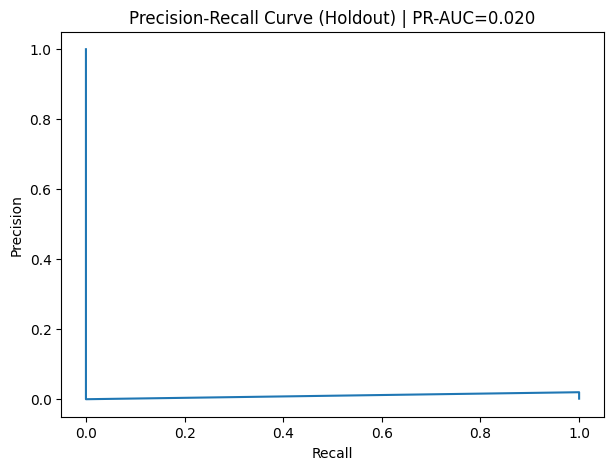

In [150]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

y_proba = best_model.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_proba)
prec, rec, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (Holdout) | PR-AUC={pr_auc:.3f}")
plt.show()

Top-K Capture Plot (Holdout)

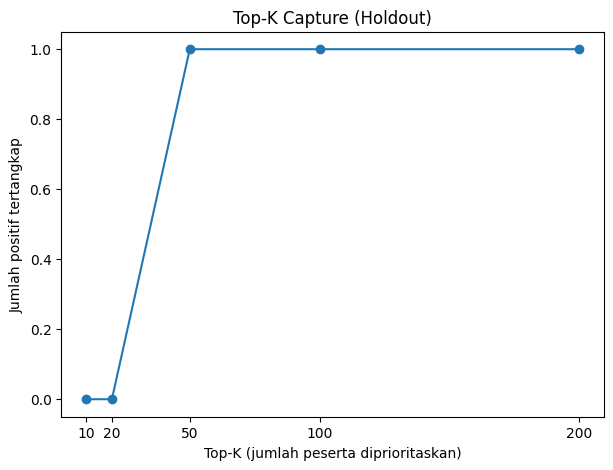

Rank positif (0-based): [49] | (1-based): [50]


In [151]:
y_proba = best_model.predict_proba(X_test)[:, 1]
score_df = pd.DataFrame({"y_true": y_test.values, "proba": y_proba})\
  .sort_values("proba", ascending=False).reset_index(drop=True)

K_list = [10, 20, 50, 100, 200]
hits = [int(score_df.head(k)["y_true"].sum()) for k in K_list]

plt.figure(figsize=(7,5))
plt.plot(K_list, hits, marker="o")
plt.xlabel("Top-K (jumlah peserta diprioritaskan)")
plt.ylabel("Jumlah positif tertangkap")
plt.title("Top-K Capture (Holdout)")
plt.xticks(K_list)
plt.show()

# bonus: print rank positif (biar jelas)
pos_rank = score_df.index[score_df["y_true"] == 1].tolist()
print("Rank positif (0-based):", pos_rank, "| (1-based):", [r+1 for r in pos_rank])

Nilai PR-AUC ditampilkan sebagai pembanding evaluasi model pada skema pengujian standar (randomized holdout). Mengingat target bersifat extremely imbalanced, nilai PR-AUC yang diperoleh merepresentasikan batas performa model pada evaluasi berbasis probabilistik global. Namun, model ini tidak digunakan sebagai classifier berbasis threshold, melainkan sebagai ranking system. Oleh karena itu, keputusan operasional selanjutnya didasarkan pada evaluasi Top-K prioritization, yang lebih relevan dengan tujuan penggunaan model.

Top-K Capture Curve

In [152]:
def topk_rates_table(y_true, y_score, K_list):
  y_true = np.asarray(y_true).astype(int)
  y_score = np.asarray(y_score).astype(float)

  # sort descending by predicted score
  order = np.argsort(-y_score)
  y_sorted = y_true[order]

  total_pos = int(y_sorted.sum())
  if total_pos == 0:
    raise ValueError("total_positive = 0 di y_true. Recall@K tidak bisa dihitung.")

  rows = []
  for K in K_list:
    K = int(K)
    K_eff = min(K, len(y_sorted))  # safety kalau K > N
    captured_pos = int(y_sorted[:K_eff].sum())
    precision_at_k = captured_pos / K_eff if K_eff > 0 else 0.0
    recall_at_k = captured_pos / total_pos

    rows.append({
      "K": K_eff,
      "Positives captured": captured_pos,
      "Precision@K": precision_at_k,
      "Recall@K": recall_at_k
    })

  return pd.DataFrame(rows), total_pos

In [153]:
N = len(y_test)
K_list = sorted(set([
  10, 20, 50, 100,
  int(0.005*N), int(0.01*N), int(0.02*N), int(0.05*N), int(0.1*N)
]))
K_list = [k for k in K_list if k > 0]

df_topk, total_pos = topk_rates_table(y_test, y_proba, K_list)

In [154]:
# tabel kecil output
from IPython.display import display

df_show_fmt = df_topk.copy()
df_show_fmt["Precision@K"] = (df_show_fmt["Precision@K"] * 100).map(lambda x: f"{x:.2f}%")
df_show_fmt["Recall@K"]    = (df_show_fmt["Recall@K"] * 100).map(lambda x: f"{x:.2f}%")

display(df_show_fmt[["K","Positives captured","Precision@K","Recall@K"]])

,K,Positives captured,Precision@K,Recall@K
0,3,0,0.00%,0.00%
1,6,0,0.00%,0.00%
2,10,0,0.00%,0.00%
3,12,0,0.00%,0.00%
4,20,0,0.00%,0.00%
5,30,0,0.00%,0.00%
6,50,1,2.00%,100.00%
7,61,1,1.64%,100.00%
8,100,1,1.00%,100.00%


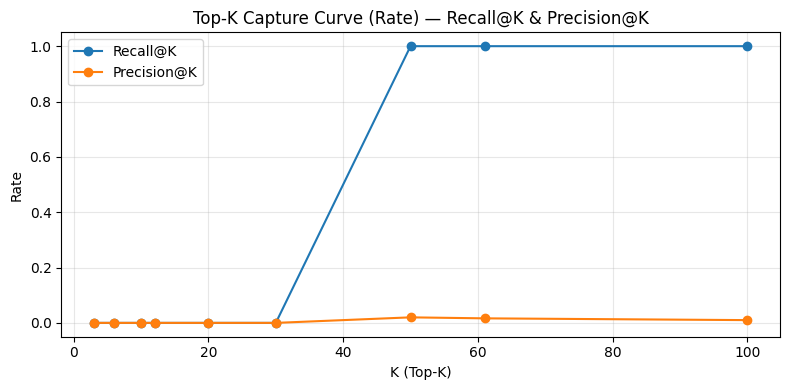

In [155]:
# 1 plot gabungan (Precision@K & Recall@K)
plt.figure(figsize=(8,4))
plt.plot(df_topk["K"], df_topk["Recall@K"], marker="o", label="Recall@K")
plt.plot(df_topk["K"], df_topk["Precision@K"], marker="o", label="Precision@K")

plt.xlabel("K (Top-K)")
plt.ylabel("Rate")
plt.title("Top-K Capture Curve (Rate) — Recall@K & Precision@K")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Grafik ini menampilkan Recall@K dan Precision@K sebagai fungsi dari K. Pada holdout dengan 1 positive, Recall@K melonjak ke 100% saat positive pertama kali masuk Top-K (sekitar K 50), sementara Precision@K tetap rendah karena base rate yang sangat kecil. Visualisasi ini digunakan untuk menentukan K operasional, bukan untuk menilai performa klasifikasi berbasis threshold.

Lift / Gains Chart (cumulative lift)

In [156]:
N = len(y_test)
prevalence = total_pos / N  # base rate

df_lift = df_topk.copy()
df_lift["Prevalence"] = prevalence
df_lift["Lift@K"] = df_lift["Precision@K"] / prevalence

In [157]:
# random baselines
df_lift["Random Recall"] = df_lift["K"] / N # expected recall if random pick K
df_lift["Random Precision"] = prevalence # expected precision random
df_lift["Random Lift"] = 1.0

In [158]:
# tabel kecil (business)
df_show = df_lift[["K", "Positives captured", "Precision@K", "Recall@K", "Lift@K"]].copy()
df_show["Precision@K"] = (df_show["Precision@K"] * 100).map(lambda x: f"{x:.2f}%")
df_show["Recall@K"]    = (df_show["Recall@K"] * 100).map(lambda x: f"{x:.2f}%")
df_show["Lift@K"]      = df_show["Lift@K"].map(lambda x: f"{x:.2f}x")

print(f"N holdout = {N}, total positive = {total_pos}, prevalence = {prevalence:.4f} ({prevalence*100:.2f}%)")
display(df_show)

N holdout = 610, total positive = 1, prevalence = 0.0016 (0.16%)


,K,Positives captured,Precision@K,Recall@K,Lift@K
0,3,0,0.00%,0.00%,0.00x
1,6,0,0.00%,0.00%,0.00x
2,10,0,0.00%,0.00%,0.00x
3,12,0,0.00%,0.00%,0.00x
4,20,0,0.00%,0.00%,0.00x
5,30,0,0.00%,0.00%,0.00x
6,50,1,2.00%,100.00%,12.20x
7,61,1,1.64%,100.00%,10.00x
8,100,1,1.00%,100.00%,6.10x


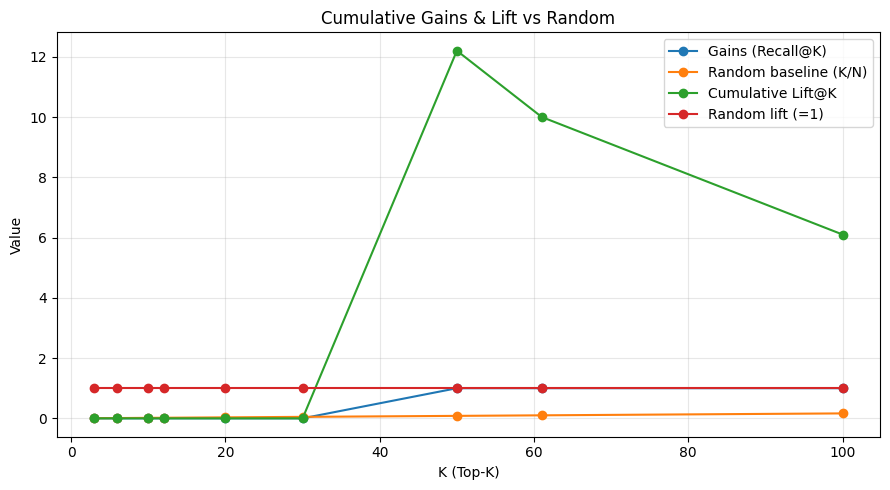

In [159]:
# plot gabungan: Gains (Recall) + Lift
plt.figure(figsize=(9,5))

# Gains chart (cumulative gains) = Recall@K
plt.plot(df_lift["K"], df_lift["Recall@K"], marker="o", label="Gains (Recall@K)")
plt.plot(df_lift["K"], df_lift["Random Recall"], marker="o", label="Random baseline (K/N)")

# Lift chart (cumulative lift)
plt.plot(df_lift["K"], df_lift["Lift@K"], marker="o", label="Cumulative Lift@K")
plt.plot(df_lift["K"], df_lift["Random Lift"], marker="o", label="Random lift (=1)")

plt.xlabel("K (Top-K)")
plt.ylabel("Value")
plt.title("Cumulative Gains & Lift vs Random")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Di holdout ini positive cuma satu, jadi begitu ketangkep di Top-50, recall langsung 100% dan lift terlihat tinggi. Itu bukan berarti model sempurna, ini efek sampel yang kecil, tapi tetap menunjukkan bahwa Top-K selection jauh lebih efektif dibanding random.

Distribusi skor: positive vs negative

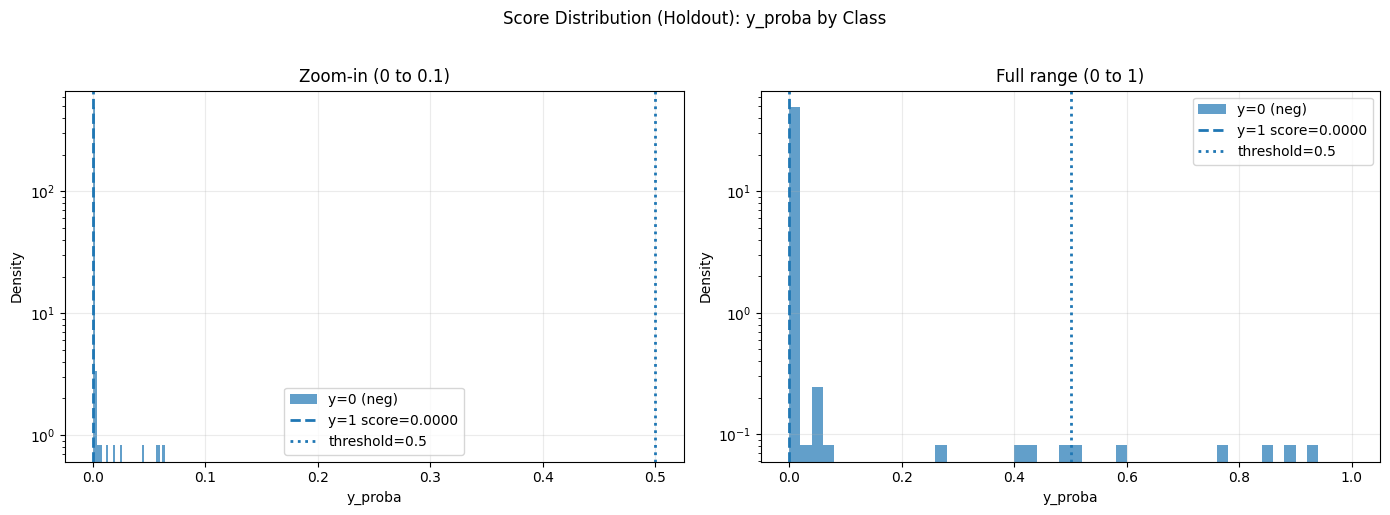

In [160]:
y_true = np.asarray(y_test).astype(int)
y_proba = np.asarray(y_proba)

neg_scores = y_proba[y_true == 0]
pos_scores = y_proba[y_true == 1]

pos_score = pos_scores[0] if len(pos_scores) > 0 else None

# Parameter zoom (silakan tweak)
x_zoom_max = 0.10
bins_full = 50
bins_zoom = 50

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Histogram
ax = axes[0]
ax.hist(neg_scores, bins=bins_zoom, range=(0, x_zoom_max), alpha=0.7, density=True, label="y=0 (neg)")

if pos_score is not None:
  ax.axvline(pos_score, linestyle="--", linewidth=2, label=f"y=1 score={pos_score:.4f}")

ax.axvline(0.5, linestyle=":", linewidth=2, label="threshold=0.5")  # kalau mau tetap ada
ax.set_title(f"Zoom-in (0 to {x_zoom_max})")
ax.set_xlabel("y_proba")
ax.set_ylabel("Density")
ax.grid(True, alpha=0.25)
ax.legend()

# Full-range histogram
ax = axes[1]
ax.hist(neg_scores, bins=bins_full, range=(0, 1.0), alpha=0.7, density=True, label="y=0 (neg)")

if pos_score is not None:
  ax.axvline(pos_score, linestyle="--", linewidth=2, label=f"y=1 score={pos_score:.4f}")

ax.axvline(0.5, linestyle=":", linewidth=2, label="threshold=0.5")
ax.set_title("Full range (0 to 1)")
ax.set_xlabel("y_proba")
ax.set_ylabel("Density")
ax.grid(True, alpha=0.25)
ax.legend()
axes[0].set_yscale("log")
axes[1].set_yscale("log")

plt.suptitle("Score Distribution (Holdout): y_proba by Class", y=1.02)
plt.tight_layout()
plt.show()

Distribusi skor probabilitas (y_proba) menunjukkan bahwa mayoritas data (kelas negatif) memiliki skor yang sangat rendah dan terpusat di dekat nol, dengan beberapa outlier bernilai tinggi. Skor untuk kelas positif pada holdout berada di rentang yang sangat rendah dan memiliki overlap besar dengan kelas negatif. Kondisi ini menjelaskan mengapa PR-AUC global menjadi rendah, karena model tidak menghasilkan pemisahan probabilistik yang kuat antar kelas.
Namun, meskipun pemisahan probabilistik lemah, pendekatan ranking Top-K tetap dapat digunakan, karena keputusan operasional didasarkan pada urutan relatif skor, bukan pada threshold absolut. Oleh karena itu, evaluasi dan penggunaan model difokuskan pada Top-K prioritization, bukan pada klasifikasi berbasis threshold.

CDF/Percentile plot

Positif ada di percentile ke berapa di antara negatif?

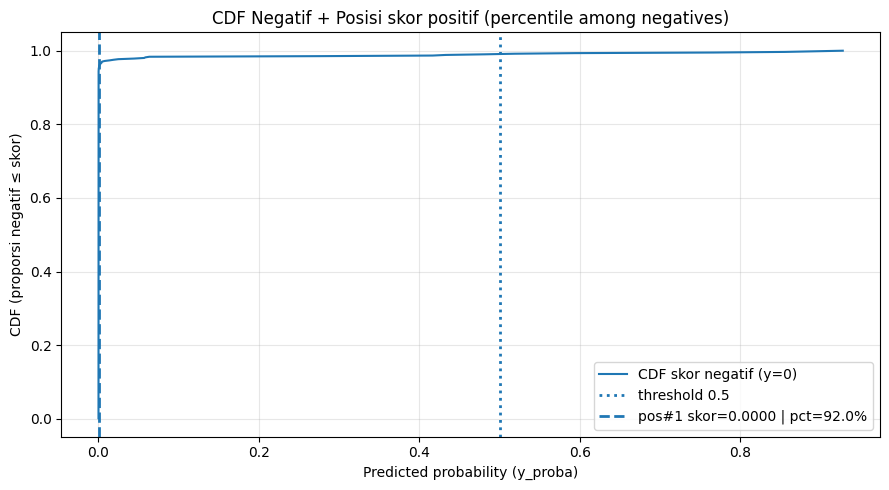

Ringkasan percentile skor positif di antara negatif:
- pos#1: skor=0.000015 -> percentile among negatives = 91.95%


In [161]:
y_true = np.asarray(y_test).astype(int)
y_score = np.asarray(y_proba).astype(float)

neg = y_score[y_true == 0]
pos = y_score[y_true == 1]

if len(pos) == 0:
  raise ValueError("Tidak ada sampel positif (y=1) di holdout, CDF plot tidak bisa dibuat.")
if len(neg) == 0:
  raise ValueError("Tidak ada sampel negatif (y=0) di holdout, CDF plot tidak bisa dibuat.")

# CDF negatif
neg_sorted = np.sort(neg)
cdf = np.arange(1, len(neg_sorted) + 1) / len(neg_sorted)

# Untuk kasus pos > 1, kita plot semua garis + ringkasan
pos_percentiles = [100.0 * (np.searchsorted(neg_sorted, s, side="right") / len(neg_sorted)) for s in pos]

plt.figure(figsize=(9, 5))
plt.plot(neg_sorted, cdf, label="CDF skor negatif (y=0)")
plt.xlabel("Predicted probability (y_proba)")
plt.ylabel("CDF (proporsi negatif ≤ skor)")
plt.title("CDF Negatif + Posisi skor positif (percentile among negatives)")
plt.grid(True, alpha=0.3)

# garis threshold 0.5 (kalau kamu mau tetap ada konteks)
plt.axvline(0.5, linestyle=":", linewidth=2, label="threshold 0.5")

# plot posisi positive
for i, (s, pctl) in enumerate(zip(pos, pos_percentiles), start=1):
  plt.axvline(s, linestyle="--", linewidth=2, label=f"pos#{i} skor={s:.4f} | pct={pctl:.1f}%")

plt.legend()
plt.tight_layout()
plt.show()

# Print ringkas buat narasi
print("Ringkasan percentile skor positif di antara negatif:")
for i, (s, pctl) in enumerate(zip(pos, pos_percentiles), start=1):
  print(f"- pos#{i}: skor={s:.6f} -> percentile among negatives = {pctl:.2f}%")

Grafik CDF menunjukkan posisi skor positif relatif terhadap distribusi skor negatif. <br><br>
Meskipun skor probabilitas absolut untuk kelas positif sangat rendah dan berada jauh di bawah threshold klasifikasi standar, skor tersebut berada pada percentile ke-sekitar 92% dibandingkan data negatif.<br><br>
Hal ini menunjukkan bahwa secara ranking relatif, skor positif masih lebih tinggi dibanding mayoritas data negatif, sehingga pendekatan Top-K prioritization tetap mampu menangkap kasus positif pada nilai K tertentu (misalnya Top-50).<br><br>
Temuan ini menjelaskan mengapa PR-AUC global rendah akibat overlap distribusi, namun pendekatan ranking tetap dapat digunakan untuk kebutuhan shortlist dan prioritisasi.<br><br>
Jadi walaupun skor positifnya kecil, ia masih lebih tinggi daripada sekitar 92% peserta lain, sehingga ketika kita ambil Top-50 prioritas, kasus ini tetap ikut terangkat.

# Feature Importance & Interpretability

## Importance dari Koefisien

In [162]:
y_proba = model_pipe.predict_proba(X_test)[:, 1]

# cek base rate & konteks imbalance
N = len(y_test)
total_pos = int(np.sum(y_test))
prevalence = total_pos / N if N else 0

print(f"Holdout size (N): {N}")
print(f"Total positive: {total_pos}")
print(f"Prevalence (base rate): {prevalence:.4f}")
print("NOTE: Model digunakan untuk ranking (Top-K), bukan keputusan threshold tunggal.")

Holdout size (N): 610
Total positive: 1
Prevalence (base rate): 0.0016
NOTE: Model digunakan untuk ranking (Top-K), bukan keputusan threshold tunggal.


## Global interpretabilityCoefficient importance (Logistic)

In [163]:
def get_feature_names_from_pipeline(pipe):
  # cari preprocessor di pipeline
  pre = None
  for name, step in pipe.named_steps.items():
    if hasattr(step, "get_feature_names_out"):
      pre = step
      break
    if name.lower() in ["preprocess", "preprocessor", "columntransformer"]:
      pre = step
      break

  if pre is None:
    pre = pipe.named_steps.get("preprocessor") or pipe.named_steps.get("preprocess")

  if pre is None:
    raise ValueError("Tidak menemukan preprocessor/transformer yang punya get_feature_names_out.")

  feature_names = pre.get_feature_names_out()
  return feature_names

def get_logreg_coef(pipe):
  # cari classifier
  clf = None
  for name, step in pipe.named_steps.items():
    if hasattr(step, "coef_"):
      clf = step
      break
  if clf is None:
    raise ValueError("Tidak menemukan model dengan atribut coef_ di pipeline.")
  return clf.coef_.ravel()

feature_names = get_feature_names_from_pipeline(model_pipe)
coef = get_logreg_coef(model_pipe)

df_coef = pd.DataFrame({"feature": feature_names, "coef": coef})
df_coef["abs_coef"] = df_coef["coef"].abs()
df_coef = df_coef.sort_values("abs_coef", ascending=False).reset_index(drop=True)

df_coef.head(15)

,feature,coef,abs_coef
0,cat__Month_Agu 2024,3.651230,3.651230
1,cat__Month_Okt 2024,2.754019,2.754019
2,cat__Level_Pekerjaan_FE_Low,-2.318886,2.318886
3,cat__Kategori_Pekerjaan_FE_Tenaga Kesehatan,1.970237,1.970237
4,cat__Product_AI Machine Learning,1.946618,1.946618
5,cat__Channel_Meta Ads,1.920211,1.920211
6,cat__Channel_Refferal,-1.909433,1.909433
7,cat__Product_Digital Marketing,1.730407,1.730407
8,cat__Domain_product_Marketing/Komunikasi,1.727402,1.727402
9,cat__Motivasi_cluster_Upgrade skill di kerja,1.716835,1.716835


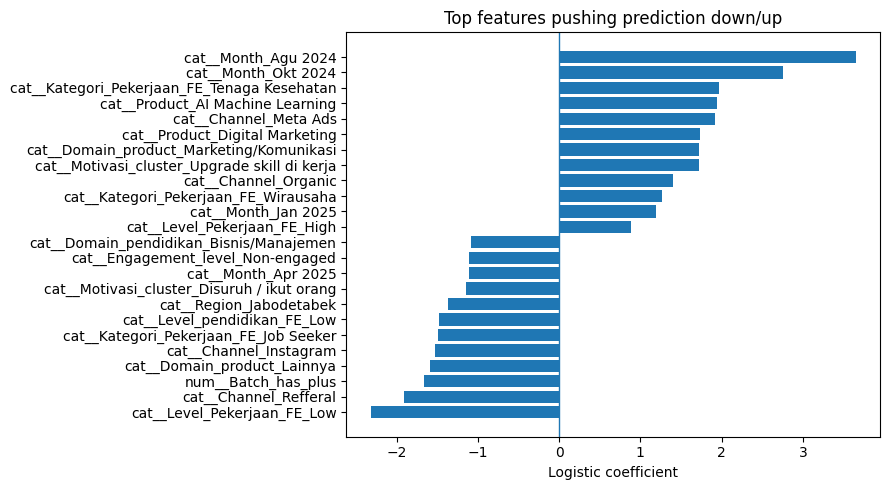

In [164]:
def plot_top_coef(df_coef, top_n=15, title="Top features pushing prediction down/up"):
  df_top = pd.concat([
    df_coef.sort_values("coef").head(top_n),
    df_coef.sort_values("coef").tail(top_n)
  ], axis=0)

  plt.figure(figsize=(9, 5))
  plt.barh(df_top["feature"], df_top["coef"])
  plt.axvline(0, linewidth=1)
  plt.title(title)
  plt.xlabel("Logistic coefficient")
  plt.tight_layout()
  plt.show()

plot_top_coef(df_coef, top_n=12)

Feature importance dianalisis menggunakan koefisien Logistic Regression untuk memberikan interpretasi yang stabil pada kondisi class imbalance ekstrem. Koefisien positif menunjukkan fitur yang mendorong peningkatan skor prediksi, sementara koefisien negatif menunjukkan fitur yang menurunkan skor.<br><br>
Hasil menunjukkan bahwa fitur terkait kesiapan (engagement & motivasi), profil profesional, dan channel yang relevan berkontribusi positif terhadap ranking peserta, sedangkan fitur yang merepresentasikan low engagement atau early-stage readiness mendorong penurunan skor.<br><br>
Jadi model memprioritaskan peserta dengan sinyal kesiapan dan relevansi yang lebih kuat, dan secara konsisten menurunkan ranking peserta dengan indikasi low engagement.

## Validasi: Permutation importance di Holdout

In [165]:
def recall_at_k(y_true, y_score, k):
  y_true = np.asarray(y_true)
  y_score = np.asarray(y_score)
  total_pos = int(y_true.sum())
  if total_pos == 0:
    return 0.0
  k = min(k, len(y_true))
  top_idx = np.argsort(-y_score)[:k]
  captured = int(y_true[top_idx].sum())
  return captured / total_pos

In [166]:
# Scorer: Reciprocal Rank (semakin tinggi semakin bagus)
from sklearn.inspection import permutation_importance

def reciprocal_rank(y_true, y_score):
  y_true = np.asarray(y_true)
  y_score = np.asarray(y_score)
  pos_idx = np.where(y_true == 1)[0]
  if len(pos_idx) == 0:
    return 0.0

  order = np.argsort(-y_score)
  ranks = [np.where(order == i)[0][0] + 1 for i in pos_idx]
  return float(np.mean([1.0/r for r in ranks]))  # MRR

def rank_scorer_mrr(estimator, X, y):
  proba = estimator.predict_proba(X)[:, 1]
  return reciprocal_rank(y, proba)

perm = permutation_importance(
  model_pipe, X_test, y_test,
  scoring=rank_scorer_mrr,
  n_repeats=20,
  random_state=42,
  n_jobs=-1
)

df_perm = pd.DataFrame({
  "feature": X_test.columns,
  "importance_mean": perm.importances_mean,
  "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False).reset_index(drop=True)

df_perm.head(15)

,feature,importance_mean,importance_std
0,Month,0.007631,0.002782
1,Channel,0.004951,0.003324
2,Batch_has_plus,0.003293,0.003690
3,Domain_pendidikan,0.002522,0.002256
4,Umur,0.002392,0.001802
5,is_switcher,0.001663,0.002428
6,Event_flag,0.001363,0.002413
7,Kategori_Pekerjaan_FE,0.000813,0.004708
8,Domain_product,0.000610,0.007544
9,Level_pendidikan_FE,0.000497,0.000598


## Gabungan

In [167]:
from sklearn.inspection import permutation_importance

steps = model_pipe.named_steps

# Detect classifier (punya predict_proba)
clf_key = None
for k, v in steps.items():
  if hasattr(v, "predict_proba"):
    clf_key = k
    break

# Detect preprocessor (transform + get_feature_names_out)
pre_key = None
for k, v in steps.items():
  if k == clf_key:
    continue
  if hasattr(v, "transform") and hasattr(v, "get_feature_names_out"):
    pre_key = k
    break

print("Detected preprocessor step:", pre_key)
print("Detected classifier step:", clf_key)

pre = steps[pre_key]
clf = steps[clf_key]

# Encode X_test to one-hot space
X_test_enc = pre.transform(X_test)

# CSR to dense array
if hasattr(X_test_enc, "toarray"):
  X_test_enc = X_test_enc.toarray()

# Feature names
try:
  feature_names = pre.get_feature_names_out()
except TypeError:
  feature_names = pre.get_feature_names_out(pre.feature_names_in_)

Detected preprocessor step: prep
Detected classifier step: clf


In [168]:
# Scorer: MRR / reciprocal rank
def reciprocal_rank(y_true, y_score):
  y_true = np.asarray(y_true)
  y_score = np.asarray(y_score)
  pos_idx = np.where(y_true == 1)[0]
  if len(pos_idx) == 0:
    return 0.0
  order = np.argsort(-y_score)
  ranks = [np.where(order == i)[0][0] + 1 for i in pos_idx]
  return float(np.mean([1.0 / r for r in ranks]))

def rank_scorer_mrr(estimator, X, y):
  proba = estimator.predict_proba(X)[:, 1]
  return reciprocal_rank(y, proba)

perm = permutation_importance(
  clf,
  X_test_enc,
  y_test,
  scoring=rank_scorer_mrr,
  n_repeats=20,
  random_state=42,
  n_jobs=-1
)

df_perm_ohe = pd.DataFrame({
  "feature": feature_names,
  "importance_mean": perm.importances_mean,
  "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False).reset_index(drop=True)

In [169]:
# Coef table
if hasattr(clf, "coef_"):
  df_coef_ohe = pd.DataFrame({
    "feature": feature_names,
    "coef": clf.coef_.ravel()
  })
  df_merge = df_perm_ohe.merge(df_coef_ohe, on="feature", how="left")
  df_merge["direction"] = np.where(df_merge["coef"] >= 0, "push_up", "push_down")
  print("NaN coef count:", df_merge["coef"].isna().sum())
  df_merge.head(20)
else:
  print("Classifier has no coef_ (bukan linear / belum fitted). Output permutation importance saja.")
  df_perm_ohe.head(20)

display(df_merge[["feature","importance_mean","importance_std","coef","direction"]].head(20))

NaN coef count: 0


,feature,importance_mean,importance_std,coef,direction
0,cat__Month_Agu 2024,0.007438,0.002394,3.651230,push_up
1,cat__Channel_Meta Ads,0.004472,0.002550,1.920211,push_up
2,cat__Domain_product_Lainnya,0.003511,0.002479,-1.585248,push_down
3,num__Batch_has_plus,0.003293,0.003690,-1.663599,push_down
4,num__Umur,0.002392,0.001802,-0.530759,push_down
5,cat__Kategori_Pekerjaan_FE_Karyawan,0.002332,0.001620,-0.894807,push_down
6,cat__Channel_Refferal,0.001949,0.002761,-1.909433,push_down
7,num__is_switcher,0.001663,0.002428,0.600554,push_up
8,cat__Domain_pendidikan_IT/Data,0.001466,0.001431,-0.693810,push_down
9,cat__Umur_bin_23–25,0.001457,0.001713,-0.928576,push_down


## Lokal Interpretability

In [170]:
from sklearn.pipeline import Pipeline

# Helper: auto-detect step preprocessor & classifier
def _detect_steps(model_pipe):
  steps = getattr(model_pipe, "named_steps", None)
  if steps is None:
    raise ValueError("model_pipe harus Pipeline yang punya .named_steps")

  # classifier
  clf_key = None
  for k, v in steps.items():
    if hasattr(v, "predict_proba") and hasattr(v, "coef_"):
      clf_key = k
      break
  if clf_key is None:
    raise ValueError("Tidak ketemu classifier yang punya predict_proba + coef_")

  # preprocessor
  pre_key = None
  for k, v in steps.items():
    if k == clf_key:
      continue
    if hasattr(v, "transform") and hasattr(v, "get_feature_names_out"):
      pre_key = k
      break
  if pre_key is None:
    raise ValueError("Tidak ketemu preprocessor yang punya transform + get_feature_names_out")

  return pre_key, clf_key

In [171]:
# Local explanation untuk 1 baris (peserta)
def explain_one(
  model_pipe,
  X_df: pd.DataFrame,
  row_idx: int,
  top_n: int = 12,
  id_col: str | None = None,
):
  pre_key, clf_key = _detect_steps(model_pipe)
  pre = model_pipe.named_steps[pre_key]
  clf = model_pipe.named_steps[clf_key]

  # ambil 1 row (DataFrame)
  x_row = X_df.iloc[[row_idx]]
  proba = float(model_pipe.predict_proba(x_row)[:, 1][0])

  # encode ke ruang OHE
  x_enc = pre.transform(x_row)
  feat_names = pre.get_feature_names_out()
  coef = clf.coef_.ravel()
  intercept = float(np.ravel(getattr(clf, "intercept_", [0.0]))[0])

  if hasattr(x_enc, "tocoo"):
    x_coo = x_enc.tocoo()
    idxs = x_coo.col
    vals = x_coo.data
  else:
    arr = np.asarray(x_enc).ravel()
    idxs = np.where(arr != 0)[0]
    vals = arr[idxs]

  contrib = vals * coef[idxs]
  df = pd.DataFrame({
    "feature": feat_names[idxs],
    "value": vals,
    "coef": coef[idxs],
    "contrib": contrib,
  }).sort_values("contrib", ascending=False)

  # ringkas logit
  logit = intercept + (contrib.sum() if len(contrib) else 0.0)

  # ambil top push up & push down
  df_up = df.head(top_n).copy()
  df_down = df.sort_values("contrib", ascending=True).head(top_n).copy()

  header = {
    "row_idx": row_idx,
    "id": (x_row[id_col].values[0] if (id_col and id_col in x_row.columns) else None),
    "pred_proba": proba,
    "logit_approx": logit,
    "intercept": intercept,
    "n_active_features": int(len(df)),
    "pre_step": pre_key,
    "clf_step": clf_key,
  }

  return header, df_up.reset_index(drop=True), df_down.reset_index(drop=True)

In [172]:
# “Kenapa peserta Top-K ini kepilih?”
def get_topk_indices(model_pipe, X_df, K=50):
  proba = model_pipe.predict_proba(X_df)[:, 1]
  topk_idx = np.argsort(-proba)[:K]
  return proba, topk_idx

In [173]:
y_proba_test, topk_idx = get_topk_indices(model_pipe, X_test, K=50)

for r in range(5):
  idx = int(topk_idx[r])
  header, up, down = explain_one(model_pipe, X_test, row_idx=idx, top_n=8)
  print(f"\n=== Rank #{r+1} | idx={idx} | proba={header['pred_proba']:.4f} ===")
  display(up.head(8))


=== Rank #1 | idx=220 | proba=0.9772 ===


,feature,value,coef,contrib
0,cat__Month_Okt 2024,1.000000,2.754019,2.754019
1,cat__Product_Digital Marketing,1.000000,1.730407,1.730407
2,cat__Domain_product_Marketing/Komunikasi,1.000000,1.727402,1.727402
3,cat__Motivasi_cluster_Upgrade skill di kerja,1.000000,1.716835,1.716835
4,cat__Channel_Organic,1.000000,1.408185,1.408185
5,cat__Kategori_Pekerjaan_FE_Wirausaha,1.000000,1.271640,1.271640
6,num__Batch_has_plus,-0.637816,-1.663599,1.061069
7,cat__Level_Pekerjaan_FE_High,1.000000,0.884087,0.884087



=== Rank #2 | idx=524 | proba=0.8894 ===


,feature,value,coef,contrib
0,cat__Month_Agu 2024,1.000000,3.651230,3.651230
1,cat__Product_Digital Marketing,1.000000,1.730407,1.730407
2,cat__Domain_product_Marketing/Komunikasi,1.000000,1.727402,1.727402
3,cat__Kategori_Pekerjaan_FE_Wirausaha,1.000000,1.271640,1.271640
4,num__Batch_has_plus,-0.637816,-1.663599,1.061069
5,num__is_switcher,0.760259,0.600554,0.456576
6,num__Umur,-0.556742,-0.530759,0.295496
7,num__Event_flag,-0.308607,-0.713463,0.220180



=== Rank #3 | idx=496 | proba=0.8818 ===


,feature,value,coef,contrib
0,cat__Month_Okt 2024,1.000000,2.754019,2.754019
1,cat__Product_Digital Marketing,1.000000,1.730407,1.730407
2,cat__Domain_product_Marketing/Komunikasi,1.000000,1.727402,1.727402
3,cat__Channel_Organic,1.000000,1.408185,1.408185
4,num__Batch_has_plus,-0.637816,-1.663599,1.061069
5,num__is_switcher,0.760259,0.600554,0.456576
6,num__Event_flag,-0.308607,-0.713463,0.220180
7,cat__Level_Pekerjaan_FE_Middle,1.000000,0.007770,0.007770



=== Rank #4 | idx=158 | proba=0.8646 ===


,feature,value,coef,contrib
0,cat__Product_Digital Marketing,1.000000,1.730407,1.730407
1,cat__Domain_product_Marketing/Komunikasi,1.000000,1.727402,1.727402
2,cat__Motivasi_cluster_Upgrade skill di kerja,1.000000,1.716835,1.716835
3,cat__Month_Jan 2025,1.000000,1.196396,1.196396
4,num__Batch_has_plus,-0.637816,-1.663599,1.061069
5,cat__Level_Pekerjaan_FE_High,1.000000,0.884087,0.884087
6,cat__Umur_bin_>30,1.000000,0.535810,0.535810
7,num__is_switcher,0.760259,0.600554,0.456576



=== Rank #5 | idx=461 | proba=0.8228 ===


,feature,value,coef,contrib
0,cat__Kategori_Pekerjaan_FE_Tenaga Kesehatan,1.000000,1.970237,1.970237
1,cat__Motivasi_cluster_Upgrade skill di kerja,1.000000,1.716835,1.716835
2,cat__Channel_Organic,1.000000,1.408185,1.408185
3,num__Batch_has_plus,-0.637816,-1.663599,1.061069
4,num__Batch_num,-1.068099,-0.650305,0.694590
5,cat__Domain_pendidikan_Lainnya,1.000000,0.627538,0.627538
6,num__is_switcher,0.760259,0.600554,0.456576
7,num__Event_flag,-0.308607,-0.713463,0.220180


## Visualiasi

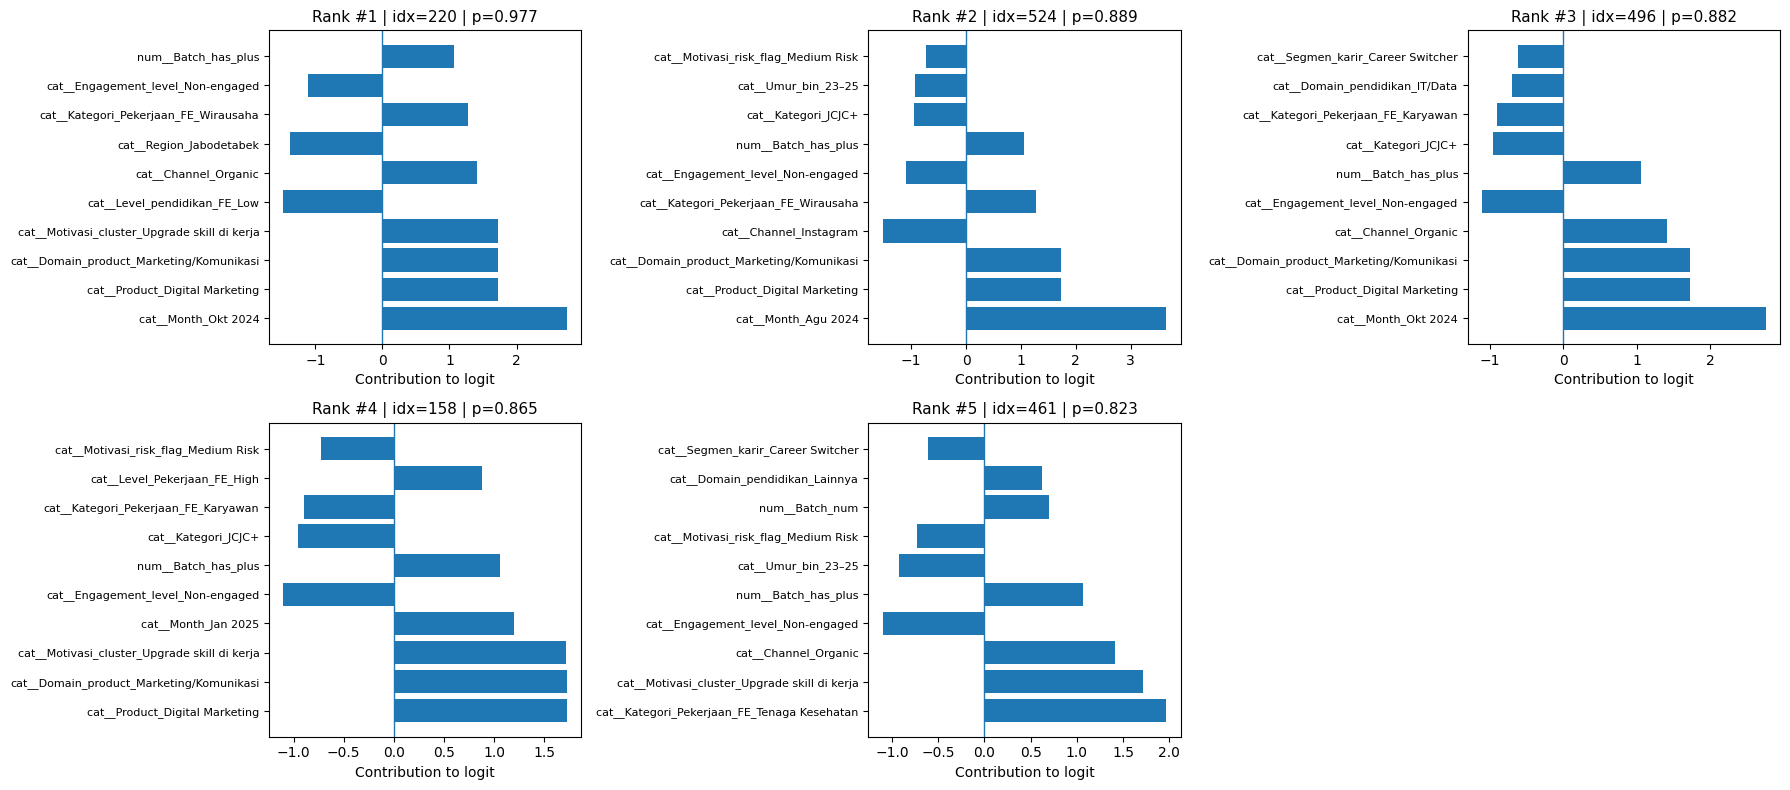

In [174]:
# ambil Top-5 index (urut dari skor tertinggi)
top5_idx = [int(i) for i in topk_idx[:5]]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.ravel()

for i, idx in enumerate(top5_idx):
  header, up, down = explain_one(model_pipe, X_test, row_idx=idx, top_n=8)

  df = (
    pd.concat([up.assign(_sign=1), down.assign(_sign=-1)], ignore_index=True)
    .copy()
  )
  df["contrib"] = pd.to_numeric(df["contrib"], errors="coerce").fillna(0.0)

  df = df.reindex(df["contrib"].abs().sort_values(ascending=False).index).head(10)

  ax = axes[i]
  y = np.arange(len(df))[::-1]
  ax.barh(y, df["contrib"].values[::-1])
  ax.set_yticks(y)
  ax.set_yticklabels(df["feature"].values[::-1], fontsize=8)

  ax.axvline(0, linewidth=1)
  ax.set_title(f"Rank #{i+1} | idx={idx} | p={header['pred_proba']:.3f}", fontsize=11)
  ax.set_xlabel("Contribution to logit")

axes[5].axis("off")
plt.tight_layout()
plt.show()

1. Grafik ini menjelaskan “kenapa peserta Top-K kepilih” secara per-individu, dengan menampilkan fitur yang paling mendorong skor prediksi naik (push up) dan turun (push down) untuk masing-masing peserta di Top-5.
2. Sumbu X = kontribusi fitur ke logit (skor sebelum jadi probabilitas): batang ke kanan menaikkan peluang (lebih mungkin tersalur), batang ke kiri menurunkan peluang; garis 0 adalah batas netral.
3. Insight: peserta dengan probabilitas tertinggi biasanya “didrive” oleh kombinasi fitur tertentu (mis. channel/produk/month/segmen/engagement).

# Model Tuning #2 (Fine Tune)

## Scorer CV metric MRR@K

- Recall@K itu cuma “ketemu / nggak ketemu” itu nilainya 0 atau 1. Kalau positifnya cuma 1, Recall@K jadi saklek: positif masuk Top-K? 1. Nggak? 0.
- Jadi banyak model/parameter beda-beda tapi skornya sama, susah milih yang terbaik.
- MRR@K itu “seberapa cepat ketemunya” jadi kalau positif ketemu di rank 1 nilainya besar, rank 50 nilainya kecil, di luar K nilainya 0. Jadi GridSearch dapat sinyal yang lebih halus buat milih parameter yang bikin ranking makin naik.

In [175]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

K_FOR_CV = 50

def mrr_at_k(y_true, y_score, k=50):
  y_true = np.asarray(y_true)
  y_score = np.asarray(y_score)

  pos_idx = np.where(y_true == 1)[0]
  if len(pos_idx) == 0:
    return 0.0

  order = np.argsort(-y_score)
  ranks = [np.where(order == i)[0][0] + 1 for i in pos_idx]  # 1-based
  best_rank = np.min(ranks)
  return (1.0 / best_rank) if best_rank <= k else 0.0

# Scorer untuk GridSearchCV: (estimator, X, y)
def mrr_scorer(estimator, X, y):
  proba = estimator.predict_proba(X)[:, 1]
  return mrr_at_k(y, proba, k=K_FOR_CV)

# CV
y_arr = np.asarray(y_train)
n_pos = int((y_arr == 1).sum())
if n_pos < 2:
  raise ValueError(f"Positif di TRAIN cuma {n_pos}. CV ranking tidak stabil. Tambah data / ubah split.")

n_splits = min(5, n_pos)
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
print(f"[SAFE CV] positives(train)={n_pos}, n_splits={n_splits}, K={K_FOR_CV}")

gs = GridSearchCV(
  estimator=model_pipe,
  param_grid=param_grid,
  scoring=mrr_scorer,
  cv=cv,
  n_jobs=-1,
  error_score="raise",
  return_train_score=True
)

gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV MRR@K:", gs.best_score_)

[SAFE CV] positives(train)=6, n_splits=5, K=50
Best params: {'clf__C': 100}
Best CV MRR@K: 0.325


In [176]:
from sklearn import set_config
from IPython.display import display

# aktifkan mode diagram
set_config(display="diagram")

# Pipeline yang dipakai GridSearchCV (best estimator)
display(gs.best_estimator_)

# Pipeline awal (sebelum GS)
display(model_pipe)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spa

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spa

## Penalty/solver with MRR@K scorer

In [177]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [178]:
param_grid = [
  {"clf__solver": ["lbfgs"], "clf__C": [0.01, 0.1, 1, 10, 100]}, # lbfgs (anggap L2 default)
  {"clf__solver": ["liblinear"], "clf__penalty": ["l2"], "clf__C": [0.01, 0.1, 1, 10, 100]},
  {"clf__solver": ["liblinear"], "clf__penalty": ["l1"], "clf__C": [0.01, 0.1, 1, 10, 100]},
]

# CV aman: stratified + n_splits <= jumlah positif
y_arr = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
n_pos = int((y_arr == 1).sum())
n_splits = min(5, max(2, n_pos))
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

gs = GridSearchCV(
  estimator=model_pipe,
  param_grid=param_grid,
  scoring=mrr_scorer,
  cv=cv,
  n_jobs=-1,
  error_score="raise",
  return_train_score=True
)

gs.fit(X_train, y_train)

print("positives(train)=", n_pos, "| n_splits=", n_splits)
print("Best params:", gs.best_params_)
print("Best CV MRR@K:", gs.best_score_)

best_model = gs.best_estimator_

positives(train)= 6 | n_splits= 5
Best params: {'clf__C': 10, 'clf__solver': 'lbfgs'}
Best CV MRR@K: 0.32666666666666666


## Holdout Evaluation

In [179]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn import set_config

In [180]:
# Config
K_FOR_CV   = 50
N_REPEATS  = 10
RANDOM_SEED = 42

# pastikan y_train jadi array 1D
y_arr = y_train.values if hasattr(y_train, "values") else np.asarray(y_train)
n_pos = int((y_arr == 1).sum())
if n_pos < 2:
  raise ValueError(f"Positif di TRAIN cuma {n_pos}. Repeated CV ranking tidak stabil. Tambah data / ubah split.")

# n_splits harus <= jumlah positif supaya tiap fold dapat minimal 1 positif
n_splits = min(5, n_pos)
n_splits = max(2, n_splits)

cv = RepeatedStratifiedKFold(
  n_splits=n_splits,
  n_repeats=N_REPEATS,
  random_state=RANDOM_SEED
)

print(f"[REPEATED CV] positives(train)={n_pos} | n_splits={n_splits} | n_repeats={N_REPEATS} | K={K_FOR_CV}")

[REPEATED CV] positives(train)=6 | n_splits=5 | n_repeats=10 | K=50


In [181]:
# Metric: MRR@K (lebih stabil untuk kasus positif sangat sedikit)
def mrr_at_k(y_true, y_score, k=50):
  y_true = np.asarray(y_true)
  y_score = np.asarray(y_score)

  pos_idx = np.where(y_true == 1)[0]
  if len(pos_idx) == 0:
    return 0.0  # anti-NaN

  order = np.argsort(-y_score)  # ranking desc
  ranks = []
  for i in pos_idx:
    r = int(np.where(order == i)[0][0]) + 1
    ranks.append(r)

  best_rank = min(ranks)
  return 1.0 / best_rank if best_rank <= k else 0.0

def mrr_scorer(estimator, X, y):
  proba = estimator.predict_proba(X)[:, 1]
  return mrr_at_k(y, proba, k=K_FOR_CV)

In [182]:
# Cek dulu split CV: pastikan tiap fold ada positif
bad = []
for i, (tr_idx, te_idx) in enumerate(cv.split(X_train, y_arr), start=1):
  pos_te = int((y_arr[te_idx] == 1).sum())
  if pos_te == 0:
    bad.append(i)

if bad:
  raise ValueError(
    f"Ada fold tanpa positif pada repeated-CV (fold idx: {bad[:10]}...). "
    f"Solusi: turunkan n_splits (<=positives) atau pakai split lain."
  )

In [183]:
# GridSearchCV (C + optional penalty/solver)
param_grid = {
  "clf__C": [0.01, 0.1, 1, 10, 100],
  "clf__solver": ["lbfgs", "liblinear"],
  "clf__penalty": ["l2"],  # (lbfgs hanya support l2)
}

gs = GridSearchCV(
  estimator=model_pipe,
  param_grid=param_grid,
  scoring=mrr_scorer,
  cv=cv,
  n_jobs=-1,
  error_score="raise",
  return_train_score=True,
  verbose=0
)

gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV MRR@K:", gs.best_score_)

Best params: {'clf__C': 100, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV MRR@K: 0.38304403820475535


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [184]:
# Ringkas hasil top-5 setting param
res = pd.DataFrame(gs.cv_results_)
show_cols = ["rank_test_score", "mean_test_score", "std_test_score", "mean_train_score", "std_train_score", "params"]
display(res.sort_values("rank_test_score")[show_cols].head(5))

# Diagram pipeline (seperti gambar kotak-kotak itu)
set_config(display="diagram")
display(gs.best_estimator_) # best pipeline

,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score,params
9,1,0.383044,0.403898,1.0,0.0,"{'clf__C': 100, 'clf__penalty': 'l2', 'clf__so..."
5,2,0.376607,0.423011,1.0,0.0,"{'clf__C': 1, 'clf__penalty': 'l2', 'clf__solv..."
7,3,0.376500,0.407741,1.0,0.0,"{'clf__C': 10, 'clf__penalty': 'l2', 'clf__sol..."
8,4,0.369757,0.407666,1.0,0.0,"{'clf__C': 100, 'clf__penalty': 'l2', 'clf__so..."
6,5,0.367387,0.398869,1.0,0.0,"{'clf__C': 10, 'clf__penalty': 'l2', 'clf__sol..."


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spa

# Top-K Plot


In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [186]:
best_model = gs.best_estimator_
y_true = y_test.values if hasattr(y_test, "values") else np.asarray(y_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

N = len(y_true)
total_pos = int((y_true == 1).sum())
prevalence = total_pos / N if N else 0.0
print(f"Holdout N={N} | positives={total_pos} | prevalence={prevalence:.4f}")

Holdout N=610 | positives=1 | prevalence=0.0016


In [187]:
# helper Top-K
def topk_table(y_true, y_score, K_list):
  y_true = np.asarray(y_true)
  y_score = np.asarray(y_score)

  order = np.argsort(-y_score)
  y_sorted = y_true[order]
  total_pos = int((y_true == 1).sum())
  N = len(y_true)

  rows = []
  for k in K_list:
    k = int(min(k, N))
    captured = int(y_sorted[:k].sum())
    precision_k = captured / k if k > 0 else 0.0
    recall_k = captured / total_pos if total_pos > 0 else 0.0
    lift_k = (precision_k / (total_pos / N)) if (total_pos > 0 and N > 0) else np.nan
    rows.append([k, captured, precision_k, recall_k, lift_k])

  df = pd.DataFrame(rows, columns=["K", "Positives captured", "Precision@K", "Recall@K", "Lift@K"])
  return df

# pilih K yang relevan (misalnya fokus intervensi Top-50)
K_list = [5, 10, 20, 30, 50, 60, 100]
K_list = sorted(set([k for k in K_list if k <= N]))

df_k = topk_table(y_true, y_proba, K_list)
df_show = df_k.copy()
df_show["Precision@K"] = (df_show["Precision@K"] * 100).round(2)
df_show["Recall@K"] = (df_show["Recall@K"] * 100).round(2)
df_show["Lift@K"] = df_show["Lift@K"].round(2)
display(df_show)

,K,Positives captured,Precision@K,Recall@K,Lift@K
0,5,0,0.00,0.0,0.00
1,10,0,0.00,0.0,0.00
2,20,0,0.00,0.0,0.00
3,30,0,0.00,0.0,0.00
4,50,1,2.00,100.0,12.20
5,60,1,1.67,100.0,10.17
6,100,1,1.00,100.0,6.10


## Precision@K & Recall@K (Top-K only)

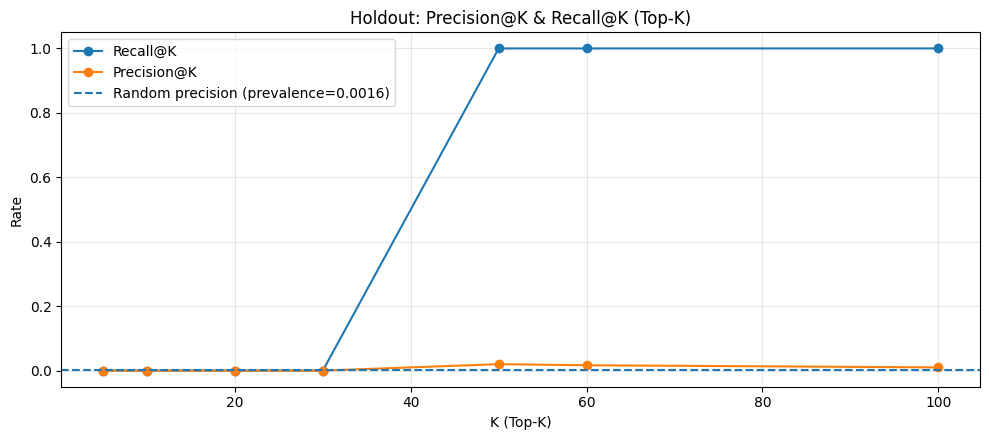

In [188]:
plt.figure(figsize=(10,4.5))
plt.plot(df_k["K"], df_k["Recall@K"], marker="o", label="Recall@K")
plt.plot(df_k["K"], df_k["Precision@K"], marker="o", label="Precision@K")
plt.axhline(prevalence, linestyle="--", label=f"Random precision (prevalence={prevalence:.4f})")
plt.xlabel("K (Top-K)")
plt.ylabel("Rate")
plt.title("Holdout: Precision@K & Recall@K (Top-K)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Lift@K (Top-K only)

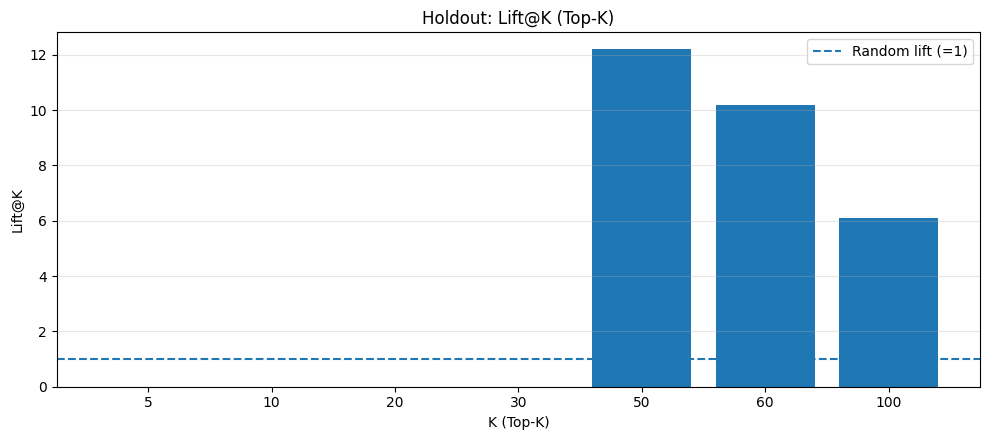

In [189]:
plt.figure(figsize=(10,4.5))
plt.bar(df_k["K"].astype(str), df_k["Lift@K"])
plt.axhline(1.0, linestyle="--", label="Random lift (=1)")
plt.xlabel("K (Top-K)")
plt.ylabel("Lift@K")
plt.title("Holdout: Lift@K (Top-K)")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Confusion matrix versi "Top-K dianggap positif"

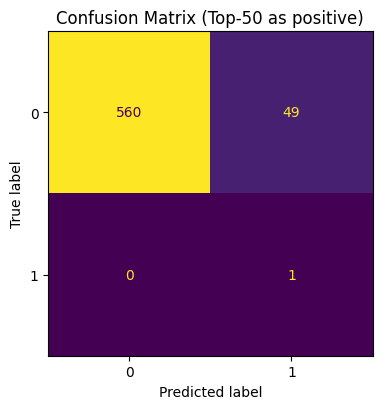

In [190]:
K_main = 50
K_main = min(K_main, N)

order = np.argsort(-y_proba)
topk_idx = order[:K_main]
y_pred_topk = np.zeros_like(y_true, dtype=int)
y_pred_topk[topk_idx] = 1

cm = confusion_matrix(y_true, y_pred_topk, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])
fig, ax = plt.subplots(figsize=(4.8,4.2))
disp.plot(ax=ax, values_format="d", colorbar=False)
ax.set_title(f"Confusion Matrix (Top-{K_main} as positive)")
plt.tight_layout()
plt.show()

# Dashboard Akhir

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [203]:
# Config
K_MAIN = 50
K_LIST = [10, 20, 30, 50, 60, 100]

# Data
y_true  = y_test.values if hasattr(y_test, "values") else np.asarray(y_test)
y_score = best_model.predict_proba(X_test)[:, 1]

N = len(y_true)
pos = int((y_true == 1).sum())
prev = pos / N if N else 0.0

order = np.argsort(-y_score)
pos_idx = np.where(y_true == 1)[0]
best_rank = None if len(pos_idx) == 0 else min(int(np.where(order == i)[0][0]) + 1 for i in pos_idx)

def metrics_topk(k):
  k = int(min(k, N))
  topk = order[:k]
  y_pred = np.zeros_like(y_true, dtype=int); y_pred[topk] = 1
  tp = int(((y_true==1) & (y_pred==1)).sum())
  fp = int(((y_true==0) & (y_pred==1)).sum())
  prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
  lift = prec/prev if prev>0 else np.nan
  return {"K": k, "Precision@K": prec, "Lift@K": lift}

K_LIST = [k for k in K_LIST if k <= N]
df = pd.DataFrame([metrics_topk(k) for k in K_LIST])

k_main = min(K_MAIN, N)
prec_main = float(df.loc[df["K"].eq(k_main), "Precision@K"].values[0]) if (k_main in df["K"].values) else 0.0
lift_main = float(df.loc[df["K"].eq(k_main), "Lift@K"].values[0]) if (k_main in df["K"].values) else np.nan

/tmp/ipython-input-3536327802.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


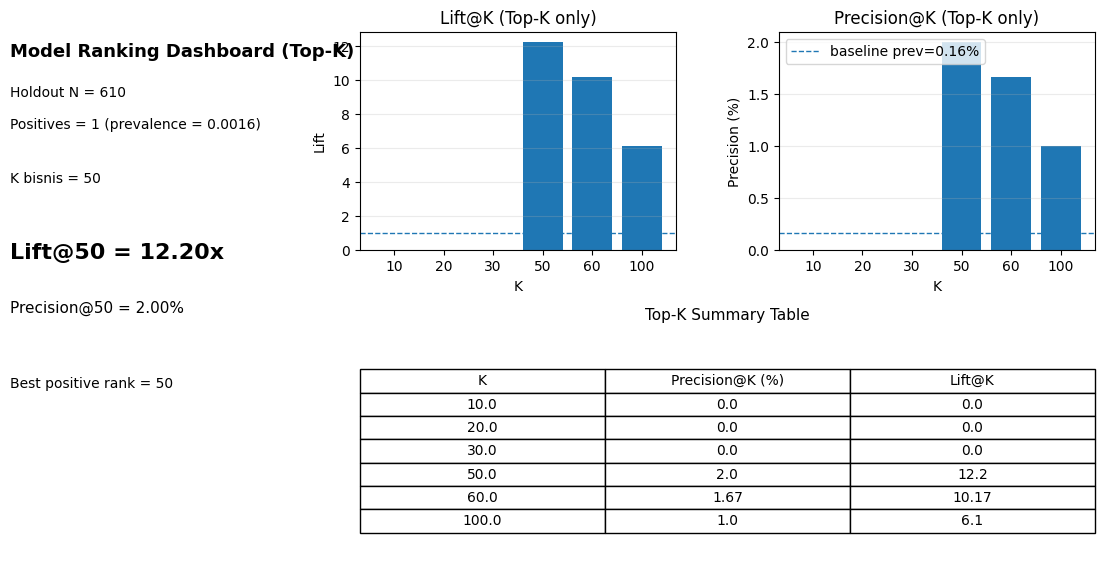

In [205]:
# Dashboard
fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(
  2, 3,
  width_ratios=[1.25, 1.6, 1.6],
  height_ratios=[1.0, 1.1],
  wspace=0.35, hspace=0.35
)

# KPI panel
ax_kpi = fig.add_subplot(gs[:, 0])
ax_kpi.axis("off")
ax_kpi.text(0.0, 0.98, "Model Ranking Dashboard (Top-K)", fontsize=13, fontweight="bold", va="top")
ax_kpi.text(0.0, 0.88, f"Holdout N = {N}", fontsize=10)
ax_kpi.text(0.0, 0.82, f"Positives = {pos} (prevalence = {prev:.4f})", fontsize=10)
ax_kpi.text(0.0, 0.72, f"K bisnis = {k_main}", fontsize=10)

ax_kpi.text(0.0, 0.58, f"Lift@{k_main} = {lift_main:.2f}x" if prev>0 else f"Lift@{k_main} = N/A",
  fontsize=16, fontweight="bold")
ax_kpi.text(0.0, 0.48, f"Precision@{k_main} = {prec_main*100:.2f}%", fontsize=11)

if best_rank is None:
  ax_kpi.text(0.0, 0.34, "Best positive rank = N/A (no positive in holdout)", fontsize=10)
else:
  ax_kpi.text(0.0, 0.34, f"Best positive rank = {best_rank}", fontsize=10)

# Lift@K bar
ax_lift = fig.add_subplot(gs[0, 1])
ax_lift.bar(df["K"].astype(str), df["Lift@K"])
ax_lift.axhline(1.0, ls="--", linewidth=1)
ax_lift.set_title("Lift@K (Top-K only)")
ax_lift.set_xlabel("K"); ax_lift.set_ylabel("Lift")
ax_lift.grid(True, axis="y", alpha=0.25)

# Precision@K bar + baseline
ax_prec = fig.add_subplot(gs[0, 2])
ax_prec.bar(df["K"].astype(str), df["Precision@K"]*100)
ax_prec.axhline(prev*100, ls="--", linewidth=1, label=f"baseline prev={prev*100:.2f}%")
ax_prec.set_title("Precision@K (Top-K only)")
ax_prec.set_xlabel("K"); ax_prec.set_ylabel("Precision (%)")
ax_prec.grid(True, axis="y", alpha=0.25)
ax_prec.legend(loc="upper left")

# Table embedded (BOTTOM RIGHT, spanning 2 cols)
ax_tbl = fig.add_subplot(gs[1, 1:])
ax_tbl.axis("off")

df_tbl = df.copy()
df_tbl["Precision@K (%)"] = (df_tbl["Precision@K"]*100).round(2)
df_tbl["Lift@K"] = df_tbl["Lift@K"].round(2)
df_tbl = df_tbl[["K", "Precision@K (%)", "Lift@K"]]

table = ax_tbl.table(
  cellText=df_tbl.values,
  colLabels=df_tbl.columns,
  loc="center",
  cellLoc="center",
  colLoc="center"
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.0, 1.4)
ax_tbl.set_title("Top-K Summary Table", fontsize=11, pad=8)

plt.tight_layout()
plt.show()